# Bayesian filtering: tracking multiple sensors using radio pings

## Load the libraries we need

Load the third-party libraries.

In [1]:
import numpy as np
from scipy import special
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import csv
import json
import math
import time
import sys
import os

Load our `localize_SMC` module.

In [2]:
import localize_SMC

## Load the data

The data currently exists in a set of JSON files (one for each time window) in the format produced by [tools/get_radio_obs.py](https://github.com/WildflowerSchools/sensei/blob/master/tools/get_radio_obs.py) from the [sensei repository](https://github.com/WildflowerSchools/sensei).

In [3]:
data_json_path = './data/json/'

In [4]:
json_input_files = [x for x in os.listdir(data_json_path) if x.endswith('.json')]

In [5]:
dataframes = []

In [6]:
for json_input_file in json_input_files:
    with open(os.path.join(data_json_path, json_input_file), 'r') as input_fullpath:
        dataframes.append(pd.read_json(input_fullpath))

In [7]:
all_data = pd.concat(dataframes, ignore_index = True)

In [8]:
all_data

local_id local_type         observed_at  remote_id remote_type  rssi
0              8       area 2017-11-28 14:00:00      11061       child   -88
1              8       area 2017-11-28 14:00:00      11060       child   -91
2             12       area 2017-11-28 14:00:00      11060       child   -83
3             13       area 2017-11-28 14:00:00      11067       child   -86
4              9       area 2017-11-28 14:00:00      11067       child   -82
5              9       area 2017-11-28 14:00:00      11060       child   -85
6              9       area 2017-11-28 14:00:00      11061       child   -83
7          11060      child 2017-11-28 14:00:00      11061       child   -71
8          11060      child 2017-11-28 14:00:00      11067       child   -69
9          11062      child 2017-11-28 14:00:00      11067       child   -81
10         11067      child 2017-11-28 14:00:00      11060       child   -69
11         11067      child 2017-11-28 14:00:00      11061       child   -71
12         11061      child 2017-11-28 14:00:00      11060       child   -71
13         11061      child 2017-11-28 14:00:00      11067       child   -70
14          5613    teacher 2017-11-28 14:00:00          9        area   -78
15            11       area 2017-11-28 14:00:00      11062       child   -73
16            11       area 2017-11-28 14:00:00      11061       child   -74
17            11       area 2017-11-28 14:00:00      11060       child   -72
18         11065      child 2017-11-28 14:00:00      11060       child   -69
19         11065      child 2017-11-28 14:00:00      11067       child   -55
20         11066      child 2017-11-28 14:00:00      11062       child   -66
21       1208464   material 2017-11-28 14:00:00      39282       child   -79
22       1208463   material 2017-11-28 14:00:00      11067       child   -77
23         11067      child 2017-11-28 14:00:00      39282       child   -77
24         11060      child 2017-11-28 14:00:00      39282       child   -75
25         39282      child 2017-11-28 14:00:00      11061       child   -53
26         39282      child 2017-11-28 14:00:00      11067       child   -76
27         39282      child 2017-11-28 14:00:00      47422       child   -68
28         39282      child 2017-11-28 14:00:00      11060       child   -75
29         11061      child 2017-11-28 14:00:00      39282       child   -52
...          ...        ...                 ...        ...         ...   ...
108424        11       area 2017-11-28 20:00:00      11060       child   -67
108425        11       area 2017-11-28 20:00:00      11067       child   -73
108426         8       area 2017-11-28 20:00:00       5612     teacher   -89
108427      5612    teacher 2017-11-28 20:00:00      11067       child   -87
108428      5612    teacher 2017-11-28 20:00:00      11060       child   -85
108429      5612    teacher 2017-11-28 20:00:00         12        area   -79
108430   1208463   material 2017-11-28 20:00:00      11067       child   -81
108431     11067      child 2017-11-28 20:00:00    1208463    material   -82
108432     11067      child 2017-11-28 20:00:00    1208471    material   -81
108433     11061      child 2017-11-28 20:00:00    1208471    material   -71
108434   1208471   material 2017-11-28 20:00:00      11067       child   -80
108435   1208471   material 2017-11-28 20:00:00      11060       child   -84
108436   1208471   material 2017-11-28 20:00:00      11061       child   -71
108437        12       area 2017-11-28 20:00:00      62461       child   -75
108438     11060      child 2017-11-28 20:00:00    1208463    material   -82
108439      5612    teacher 2017-11-28 20:00:00    1208464    material   -81
108440   1208464   material 2017-11-28 20:00:00      11060       child   -76
108441     11060      child 2017-11-28 20:00:00    1208464    material   -76
108442     11061      child 2017-11-28 20:00:00    1208464    material   -83
108443      5613    teacher 2017-11-28 20:00:00    1208464    material   -74
1084

## Filter the data

Calculate a set of summary statistics for the pings sent by each sensor.

In [9]:
sensor_diagnostics = all_data.groupby('remote_id')['observed_at'].agg(['nunique', 'min', 'max']).rename(
    columns = {'nunique': 'n_times', 'min': 'min_time', 'max': 'max_time'}
)

In [10]:
sensor_diagnostics

n_times            min_time            max_time
remote_id                                                 
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00

Sort by the total number of time windows in which each sensor sent pings.

In [11]:
sensor_diagnostics.sort_values('n_times')

n_times            min_time            max_time
remote_id                                                 
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00

A handful of sensors sent pings in very few time windows (e.g., fewer than 200 time windows out of over 2,000 time windows). Eventually, our algorithms need to robust enough to handle these kinds of situations (e.g., by inferring from the data which sensors are actually present on the mesh). For now, though, we probably want to remove these sensors from the data before doing any analysis.

Sort by the earliest time that each sensor sent pings.

In [12]:
sensor_diagnostics.sort_values('min_time')

n_times            min_time            max_time
remote_id                                                 
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00

A couple of the sensors didn't send any pings for the first hour and a half or so. Similarly, we probably want to remove these sensors from the data before doing any analysis.

Sort by the latest time that each sensor sent pings.

In [13]:
sensor_diagnostics.sort_values('max_time')

n_times            min_time            max_time
remote_id                                                 
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00

One sensor stopped sending pings after 24 minutes and then a punch of sensors started to cut out after a couple of hours. We probably want to remove the first sensor and truncate the entire data set after 16:00 UTC.

Apply these rules to produce a list of the sensors we want to keep in the data.

In [14]:
usable_sensors = sensor_diagnostics[(sensor_diagnostics['n_times'] > 200) &
                                    (sensor_diagnostics['min_time'] < pd.Timestamp('2017-11-28 14:30')) &
                                    (sensor_diagnostics['max_time'] > pd.Timestamp('2017-11-28 16:00'))].index.values.tolist()

In [15]:
usable_sensors

[8L,
 9L,
 10L,
 11L,
 12L,
 13L,
 5612L,
 5613L,
 11060L,
 11061L,
 11065L,
 11066L,
 11067L,
 39282L,
 41582L,
 47422L,
 62459L,
 1208461L,
 1208463L,
 1208464L,
 1208468L,
 1208469L,
 1208471L]

We also want to remove the sensor with entity ID 8. That sensor is in the bathroom in the basement, and its data won't make sense in our current two-dimensional model.

In [16]:
usable_sensors.remove(8)

Subtract our usable sensor list from the overall list of sensors so we can see which sensors we are removing.

In [17]:
set(sensor_diagnostics.index.values.tolist()) - set(usable_sensors)

{8L, 11062L, 31986L, 47423L, 62461L}

These correspond to the problematic sensors we identified above.

Filter out these sensors and remove all data after 16:00 UTC to produce the dataset we will use for all subsequent analysis.

In [18]:
usable_data = all_data[(all_data['remote_id'].isin(usable_sensors)) &
                       (all_data['local_id'].isin(usable_sensors)) &
                       (all_data['observed_at'] <= pd.Timestamp('2017-11-28 16:00'))].reset_index(drop=True)

In [19]:
usable_data

local_id local_type         observed_at  remote_id remote_type  rssi
0            12       area 2017-11-28 14:00:00      11060       child   -83
1            13       area 2017-11-28 14:00:00      11067       child   -86
2             9       area 2017-11-28 14:00:00      11067       child   -82
3             9       area 2017-11-28 14:00:00      11060       child   -85
4             9       area 2017-11-28 14:00:00      11061       child   -83
5         11060      child 2017-11-28 14:00:00      11061       child   -71
6         11060      child 2017-11-28 14:00:00      11067       child   -69
7         11067      child 2017-11-28 14:00:00      11060       child   -69
8         11067      child 2017-11-28 14:00:00      11061       child   -71
9         11061      child 2017-11-28 14:00:00      11060       child   -71
10        11061      child 2017-11-28 14:00:00      11067       child   -70
11         5613    teacher 2017-11-28 14:00:00          9        area   -78
12           11       area 2017-11-28 14:00:00      11061       child   -74
13           11       area 2017-11-28 14:00:00      11060       child   -72
14        11065      child 2017-11-28 14:00:00      11060       child   -69
15        11065      child 2017-11-28 14:00:00      11067       child   -55
16      1208464   material 2017-11-28 14:00:00      39282       child   -79
17      1208463   material 2017-11-28 14:00:00      11067       child   -77
18        11067      child 2017-11-28 14:00:00      39282       child   -77
19        11060      child 2017-11-28 14:00:00      39282       child   -75
20        39282      child 2017-11-28 14:00:00      11061       child   -53
21        39282      child 2017-11-28 14:00:00      11067       child   -76
22        39282      child 2017-11-28 14:00:00      47422       child   -68
23        39282      child 2017-11-28 14:00:00      11060       child   -75
24        11061      child 2017-11-28 14:00:00      39282       child   -52
25        11061      child 2017-11-28 14:00:00      47422       child   -67
26        47422      child 2017-11-28 14:00:00      11065       child   -62
27        47422      child 2017-11-28 14:00:00      39282       child   -68
28           13       area 2017-11-28 14:00:00      47422       child   -88
29        11065      child 2017-11-28 14:00:00      47422       child   -61
...         ...        ...                 ...        ...         ...   ...
40417     11066      child 2017-11-28 16:00:00    1208469    material   -91
40418     62459      child 2017-11-28 16:00:00         11        area   -77
40419     47422      child 2017-11-28 16:00:00         11        area   -73
40420     39282      child 2017-11-28 16:00:00    1208463    material   -70
40421     11067      child 2017-11-28 16:00:00    1208463    material   -85
40422     39282      child 2017-11-28 16:00:00    1208464    material   -73
40423     11060      child 2017-11-28 16:00:00      41582       child   -89
40424     47422      child 2017-11-28 16:00:00    1208471    material   -88
40425     11061      child 2017-11-28 16:00:00    1208471    material   -76
40426     47422      child 2017-11-28 16:00:00      41582       child   -88
40427        12       area 2017-11-28 16:00:00      41582       child   -79
40428   1208471   material 2017-11-28 16:00:00      47422       child   -87
40429     39282      child 2017-11-28 16:00:00      41582       child   -89
40430     62459      child 2017-11-28 16:00:00      11065       child   -64
40431     11061      child 2017-11-28 16:00:00    1208463    material   -84
40432     11065      child 2017-11-28 16:00:00      62459       child   -66
40433     41582      child 2017-11-28 16:00:00    1208463    material   -83
40434   1208471   material 2017-11-28 16:00:00      41582       child   -89
40435     41582      child 2017-11-28 16:00:00         12        area   -80
40436     62459      child 2017-11-28 16:00:00    1208463    material   -84
40437     62459      child 2017-11-28 16:00:00    12084

## Extract entity IDs

In [20]:
child_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'child'].local_id),
                              pd.unique(usable_data[usable_data.remote_type == 'child'].remote_id)).tolist()
material_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'material'].local_id),
                                 pd.unique(usable_data[usable_data.remote_type == 'material'].remote_id)).tolist()
teacher_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'teacher'].local_id),
                                pd.unique(usable_data[usable_data.remote_type == 'teacher'].remote_id)).tolist()
area_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'area'].local_id),
                             pd.unique(usable_data[usable_data.remote_type == 'area'].remote_id)).tolist()

In [21]:
child_entity_ids

[11060L, 11061L, 11065L, 11066L, 11067L, 39282L, 41582L, 47422L, 62459L]

In [22]:
material_entity_ids

[1208461L, 1208463L, 1208464L, 1208468L, 1208469L, 1208471L]

In [23]:
teacher_entity_ids

[5612L, 5613L]

In [24]:
area_entity_ids

[9L, 10L, 11L, 12L, 13L]

## Define the variable structure for the model

In [25]:
variable_structure = localize_SMC.SensorVariableStructure(child_entity_ids,
                                                          material_entity_ids,
                                                          teacher_entity_ids,
                                                          area_entity_ids)

In [26]:
variable_structure.moving_entity_ids

[11060L,
 11061L,
 11065L,
 11066L,
 11067L,
 39282L,
 41582L,
 47422L,
 62459L,
 1208461L,
 1208463L,
 1208464L,
 1208468L,
 1208469L,
 1208471L,
 5612L,
 5613L]

In [27]:
variable_structure.fixed_entity_ids

[9L, 10L, 11L, 12L, 13L]

In [28]:
variable_structure.entity_ids

[11060L,
 11061L,
 11065L,
 11066L,
 11067L,
 39282L,
 41582L,
 47422L,
 62459L,
 1208461L,
 1208463L,
 1208464L,
 1208468L,
 1208469L,
 1208471L,
 5612L,
 5613L,
 9L,
 10L,
 11L,
 12L,
 13L]

## Restructure the data for use in the model

### Create time structure

Add a new data column with an integer index for time.

In [29]:
usable_data=usable_data.assign(
    t_index = ((usable_data.observed_at - usable_data.observed_at.min())/np.timedelta64(10, 's')).astype(int)
)

Create an array which represents all possible time index values in the observed time span (including time index values with no ping data that therefore don't appear in our data).

In [30]:
t_indices = np.arange(usable_data.t_index.min(), usable_data.t_index.max() + 1)
num_timesteps = len(t_indices)

See if there were any timesteps in which we received no data.

In [31]:
np.setdiff1d(t_indices, usable_data['t_index']).tolist()

[241, 242, 243]

There were three subsequent timesteps in which no ping data was recorded. We already knew this from [earlier analyses](https://wildflowerschools.github.io/ping_statistics/).

Set up a parallel vector of actual timestamps (including timestamps with no ping data that therefore don't appear in our data).

In [32]:
t = pd.date_range(usable_data['observed_at'].min(), usable_data['observed_at'].max(), freq='10S')

### Restructure ping data

We need to restructure this data into two flat structures. For each pair of sensors that talk to each other, `y_discrete_t` should encode the data for whether a ping was received in each timestep and `y_continuous_t` should encode the data for the measured RSSI of the ping if it was received.

We'll do this in two steps. First, we'll structure the data into an array format which includes all sensors and then we'll extract the subset of sensors that actually communicate and flatten the result.

First, initialize the arrays. For `y_discrete_t`, we'll use 0 to indicate that a ping was received and 1 to indicate that a ping was not received (don't ask). For `y_continuous_t`, we'll convert the integer RSSI values to floats (since we're treating RSSI as a continuous variable) and we'll just enter a 0.0 value for RSSI if no ping was received.

In [33]:
y_discrete_t_all_sensors = np.ones((num_timesteps, variable_structure.num_sensors, variable_structure.num_sensors), dtype='int')
y_continuous_t_all_sensors = np.zeros((num_timesteps, variable_structure.num_sensors, variable_structure.num_sensors), dtype='float')

Step through the data, copying the information into these arrays.

In [34]:
for row in range(usable_data.shape[0]):
    y_discrete_t_all_sensors[usable_data.iloc[row, 6],
                             variable_structure.entity_ids.index(usable_data.iloc[row, 3]),
                             variable_structure.entity_ids.index(usable_data.iloc[row, 0])] = 0
    y_continuous_t_all_sensors[usable_data.iloc[row, 6],
                               variable_structure.entity_ids.index(usable_data.iloc[row, 3]),
                               variable_structure.entity_ids.index(usable_data.iloc[row, 0])] = usable_data.iloc[row, 5]

Apply some basic sanity checks.

In [35]:
np.sum(y_discrete_t_all_sensors == 0)

40447

In [36]:
np.sum(y_continuous_t_all_sensors != 0.0)

40447

In [37]:
len(usable_data)

40447

In [38]:
y_discrete_t = variable_structure.extract_y_variables(y_discrete_t_all_sensors)
y_continuous_t = variable_structure.extract_y_variables(y_continuous_t_all_sensors)

Apply our sanity checks again.

In [39]:
np.sum(y_discrete_t == 0)

40447

In [40]:
np.sum(y_continuous_t != 0.0)

40447

In [41]:
len(usable_data)

40447

## Create the model

### Room geometry

In [42]:
feet_to_meters = 12*2.54/100

In [43]:
room_size = np.array([(19.0 + 4.0/12.0 + 15.0/12.0 + 43.0 + 2.0/12.0 + 2.0)*feet_to_meters,
                      (11.0 + 9.0/12.0)*feet_to_meters])

In [44]:
room_size

array([20.0406,  3.5814])

In [45]:
room_corners = np.array([[0.0, 0.0], room_size])

In [46]:
room_corners

array([[ 0.    ,  0.    ],
       [20.0406,  3.5814]])

### Positions of fixed sensors

Here are the rough positions of the fixed sensors, taken from the notes we made when we installed.

In [47]:
fixed_sensor_positions = np.array ([[(19.0 + 4.0/12.0 + 15.0/12.0 + 2.0)*feet_to_meters,
                                     (11.0 + 9.0/12.0 - 1.0)*feet_to_meters],
                                   [(2.0)*feet_to_meters,
                                    (11.0 + 9.0/12.0 - 1.0)*feet_to_meters],
                                   [(19.0 + 4.0/12.0 + 15.0/12.0 + 43.0 + 2.0/12.0 + 1.0)*feet_to_meters,
                                    (3.0)*feet_to_meters],
                                   [(19.0 + 4.0/12.0 + 15.0/12.0 + 15.0)*feet_to_meters,
                                    (1.0)*feet_to_meters],
                                    [(19.0 + 4.0/12.0 + 15.0/12.0 +3.0)*feet_to_meters,
                                    (3.0)*feet_to_meters]])

In [48]:
fixed_sensor_positions

array([[ 6.8834,  3.2766],
       [ 0.6096,  3.2766],
       [19.7358,  0.9144],
       [10.8458,  0.3048],
       [ 7.1882,  0.9144]])

### Transition model

In [49]:
moving_sensor_drift = 1.0 # Just a placeholder for now. With 10 seconds between timesteps, we need to rethink our motion model

### Sensor response model

#### Ping success probability

In [50]:
receive_probability_zero_distance = 1.0 # Assume that we hear 100% of pings if sensors are right next to each other
reference_distance = 10.0 # Aproximately half the length of the classroom; approximately the median inter-sensor distance
receive_probability_reference_distance = 0.135 # Approximately the median ping success rate from data above
scale_factor = reference_distance/np.log(receive_probability_reference_distance/receive_probability_zero_distance)

In [51]:
def ping_success_probability(distances):
    return receive_probability_zero_distance*np.exp(distances/scale_factor)

#### RSSI

In [52]:
rssi_untruncated_mean_intercept = -69.18 # Mean RSSI at 1 meter (log(distance)=0); from analysis of rssi.random_walk.csv
rssi_untruncated_mean_slope = -20.0 # Creates a 1/r^2 fall-off
rssi_untruncated_std_dev = 5.70 # Noise value; from analysis of rssi.random_walk.csv
lower_rssi_cutoff = -96.0001 # Set just below lowest observed value above

In [53]:
def rssi_untruncated_mean(distance):
    return rssi_untruncated_mean_intercept + rssi_untruncated_mean_slope*np.log10(distance)

In [54]:
def rssi_truncated_mean(distance):
    return stats.truncnorm.stats(a=(lower_rssi_cutoff - rssi_untruncated_mean(distance))/rssi_untruncated_std_dev,
                                 b=np.inf,
                                 loc=rssi_untruncated_mean(distance),
                                 scale=rssi_untruncated_std_dev,
                                 moments='m')

In [55]:
def rssi_samples(distances):
    return stats.truncnorm.rvs(a=(lower_rssi_cutoff - rssi_untruncated_mean(distances))/rssi_untruncated_std_dev,
                               b=np.inf,
                               loc=rssi_untruncated_mean(distances),
                               scale=rssi_untruncated_std_dev)

In [56]:
def left_truncnorm_logpdf(x, untruncated_mean, untruncated_std_dev, left_cutoff):
    logf = np.array(np.subtract(stats.norm.logpdf(x, loc=untruncated_mean, scale=untruncated_std_dev),
                                np.log(1 - stats.norm.cdf(left_cutoff, loc=untruncated_mean, scale=untruncated_std_dev))))
    logf[x < left_cutoff] = -np.inf
    return logf

In [57]:
def rssi_log_pdf(rssi, distance):
    return left_truncnorm_logpdf(rssi,
                                 rssi_untruncated_mean(distance),
                                 rssi_untruncated_std_dev,
                                 lower_rssi_cutoff)

### Initialize the model object

In [58]:
sensor_model = localize_SMC.SensorModel(
    variable_structure,
    room_corners, fixed_sensor_positions,
    moving_sensor_drift,
    ping_success_probability,
    rssi_samples, rssi_log_pdf
)

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the real data using a particle filter

Set the number of particles and initialize variables.

In [59]:
num_timesteps_test = 50 # Just calculating the first 100 timesteps for now to save debug cycle time
t_test = t[:num_timesteps_test]

In [60]:
num_particles = 10000
x_discrete_particles_trajectory = np.zeros((num_timesteps_test, num_particles, variable_structure.num_x_discrete_vars), dtype = 'int')
x_continuous_particles_trajectory = np.zeros((num_timesteps_test, num_particles, variable_structure.num_x_continuous_vars), dtype = 'float')
log_weights_trajectory = np.zeros((num_timesteps_test, num_particles), dtype = 'float')
ancestors_trajectory = np.zeros((num_timesteps_test, num_particles), dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [61]:
time_start = time.clock()
x_discrete_particles_initial, x_continuous_particles_initial, log_weights_initial = sensor_model.generate_initial_particles(num_particles)
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0180258133333


In [62]:
time_start = time.clock()
x_discrete_particles_trajectory[0], x_continuous_particles_trajectory[0], log_weights_trajectory[0], ancestors_trajectory[0] = sensor_model.generate_next_particles(x_discrete_particles_initial, x_continuous_particles_initial, log_weights_initial, y_discrete_t[0],  y_continuous_t[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 2.0519872


Calculate the particles for all times $t>0$.

In [63]:
sys.stdout.write('t_index =')
sys.stdout.flush()
time_start = time.clock()
for t_index in range(1, num_timesteps_test):
    sys.stdout.write(' {}'.format(t_index))
    sys.stdout.flush()
    x_discrete_particles_trajectory[t_index], x_continuous_particles_trajectory[t_index], log_weights_trajectory[t_index], ancestors_trajectory[t_index] = sensor_model.generate_next_particles(x_discrete_particles_trajectory[t_index - 1], x_continuous_particles_trajectory[t_index - 1], log_weights_trajectory[t_index - 1], y_discrete_t[t_index], y_continuous_t[t_index])
print'\nTime elapsed = {}'.format(time.clock()-time_start)

t_index = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
Time elapsed = 97.5336849067


Calculate and plot the maximum particle weight for each time step. When the maximum particle weight increases to 1.0, our particle filter has collapsed around a single value.

In [64]:
max_weights = np.max(np.exp(log_weights_trajectory), axis=1)

Calculate and plot the number of particles actually sampled at each time step. If the number of particles actually sampled decreases to 1, our particle filter has collapsed around a single value.

In [65]:
num_sampled_particles = np.array([len(np.unique(ancestors_trajectory[t_index])) for t_index in range(1, num_timesteps_test)])

Calculate the sample means and sample standard deviations of continuous $\mathbf{X}$ variables for the particles at each time $t$.

In [66]:
x_continuous_mean_particle = np.average(
    x_continuous_particles_trajectory, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_continuous_vars).reshape((num_timesteps_test, num_particles, sensor_model.num_x_continuous_vars))
)

In [67]:
x_continuous_squared_mean_particle = np.average(
    np.square(x_continuous_particles_trajectory), 
    axis=1,
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_continuous_vars).reshape((num_timesteps_test, num_particles, variable_structure.num_x_continuous_vars))
)

In [68]:
x_continuous_sd_particle = np.sqrt(np.abs(x_continuous_squared_mean_particle - np.square(x_continuous_mean_particle)))

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Now we want to run the same calculation, but with simulated sensor data. This allows us to see how accurately the model can infer positions when the conditional probability distributions of the actual data match the assumptions in the model exactly.

Set the number of timesteps and initialize the variables.

In [69]:
num_timesteps_sim = 50
t_sim = np.zeros(num_timesteps_sim, dtype='float')
x_discrete_t_sim = np.zeros((num_timesteps_sim, variable_structure.num_x_discrete_vars), dtype='int')
x_continuous_t_sim = np.zeros((num_timesteps_sim, variable_structure.num_x_continuous_vars), dtype='float')
y_discrete_t_sim = np.zeros((num_timesteps_sim, variable_structure.num_y_discrete_vars), dtype='int')
y_continuous_t_sim = np.zeros((num_timesteps_sim, variable_structure.num_y_continuous_vars), dtype='float')

Calculate the simulated data for $t=0$.

In [70]:
t_sim[0] = 0.0

In [71]:
x_discrete_t_sim[0], x_continuous_t_sim[0] = sensor_model.x_initial_sample()

In [72]:
y_discrete_t_sim[0], y_continuous_t_sim[0] = sensor_model.y_bar_x_sample(x_discrete_t_sim[0], x_continuous_t_sim[0])

Calculate the simulated data for $t>0$.

In [73]:
timestep_size_sim = 10.0

In [74]:
for t_index in range(1,num_timesteps_sim):
    t_sim[t_index] = t_sim[t_index - 1] + timestep_size_sim
    x_discrete_t_sim[t_index], x_continuous_t_sim[t_index] = sensor_model.x_bar_x_prev_sample(x_discrete_t_sim[t_index - 1],
                                                                                      x_continuous_t_sim[t_index - 1])
    y_discrete_t_sim[t_index], y_continuous_t_sim[t_index] = sensor_model.y_bar_x_sample(x_discrete_t_sim[t_index],
                                                                    x_continuous_t_sim[t_index])

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the simulated data using a particle filter

Set the number of particles and initialize variables.

In [75]:
num_particles_sim = 10000
x_discrete_particles_trajectory_sim = np.zeros((num_timesteps_sim, num_particles_sim, variable_structure.num_x_discrete_vars), dtype = 'int')
x_continuous_particles_trajectory_sim = np.zeros((num_timesteps_sim, num_particles_sim, variable_structure.num_x_continuous_vars), dtype = 'float')
log_weights_trajectory_sim = np.zeros((num_timesteps_sim, num_particles_sim), dtype = 'float')
ancestors_trajectory_sim = np.zeros((num_timesteps_sim, num_particles_sim), dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [76]:
time_start = time.clock()
x_discrete_particles_initial_sim, x_continuous_particles_initial_sim, log_weights_initial_sim = sensor_model.generate_initial_particles(num_particles_sim)
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0203217066667


In [77]:
time_start = time.clock()
x_discrete_particles_trajectory_sim[0], x_continuous_particles_trajectory_sim[0], log_weights_trajectory_sim[0], ancestors_trajectory_sim[0] = sensor_model.generate_next_particles(x_discrete_particles_initial_sim, x_continuous_particles_initial_sim, log_weights_initial_sim, y_discrete_t_sim[0],  y_continuous_t_sim[0])
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 2.02604245333


Calculate the particles for all times $t>0$.

In [78]:
sys.stdout.write('t_index =')
sys.stdout.flush()
time_start = time.clock()
for t_index in range(1, num_timesteps_sim):
    sys.stdout.write(' {}'.format(t_index))
    sys.stdout.flush()
    x_discrete_particles_trajectory_sim[t_index], x_continuous_particles_trajectory_sim[t_index], log_weights_trajectory_sim[t_index], ancestors_trajectory_sim[t_index] = sensor_model.generate_next_particles(
        x_discrete_particles_trajectory_sim[t_index - 1],
        x_continuous_particles_trajectory_sim[t_index - 1],
        log_weights_trajectory_sim[t_index - 1],
        y_discrete_t_sim[t_index],
        y_continuous_t_sim[t_index])
print'\nTime elapsed = {}'.format(time.clock()-time_start)

t_index = 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
Time elapsed = 98.9399394133


Calculate and plot the maximum particle weight for each time step. When the maximum particle weight increases to 1.0, our particle filter has collapsed around a single value.

In [79]:
max_weights_sim = np.max(np.exp(log_weights_trajectory_sim), axis=1)

Calculate and plot the number of particles actually sampled at each time step. If the number of particles actually sampled decreases to 1, our particle filter has collapsed around a single value.

In [80]:
num_sampled_particles_sim = np.array([len(np.unique(ancestors_trajectory_sim[t_index])) for t_index in range(1, num_timesteps_sim)])

Calculate the sample means and sample standard deviations of continuous $\mathbf{X}$ variables for the particles at each time $t$.

In [81]:
x_continuous_mean_particle_sim = np.average(
    x_continuous_particles_trajectory_sim, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_continuous_vars).reshape((num_timesteps_sim, num_particles_sim, variable_structure.num_x_continuous_vars))
)

In [82]:
x_continuous_squared_mean_particle_sim = np.average(
    np.square(x_continuous_particles_trajectory_sim), 
    axis=1,
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_continuous_vars).reshape((num_timesteps_sim, num_particles_sim, variable_structure.num_x_continuous_vars))
)

In [83]:
x_continuous_sd_particle_sim = np.sqrt(np.abs(x_continuous_squared_mean_particle_sim - np.square(x_continuous_mean_particle_sim)))

## Define variable names

At many points below, we'll need the names of various $\mathbf{X}$ and $\mathbf{Y}$ variables so we can display results in different formats.

### Define the names of the sensors and the spatial dimensions

Define the names of the sensors

In [84]:
child_sensor_names = ['Child sensor {}'.format(id) for id in child_entity_ids]
material_sensor_names = ['Material sensor {}'.format(id) for id in material_entity_ids]
teacher_sensor_names = ['Teacher sensor {}'.format(id) for id in teacher_entity_ids]
area_sensor_names = ['Area sensor {}'.format(id) for id in area_entity_ids]
    
moving_sensor_names = child_sensor_names + material_sensor_names + teacher_sensor_names
fixed_sensor_names = area_sensor_names
sensor_names = moving_sensor_names + fixed_sensor_names

Define the names of the spatial dimensions

In [85]:
dimension_names = [
    '$l$',
    '$w$'
]

### Define the names of the $\mathbf{X}$ variables

First, we define the names of the discrete $\mathbf{X}$ variables.

For now, we have no discrete $\mathbf{X}$ variables. In the future, we may include things like discrete variables for whether or not a sensor is present on the mesh, but for now, this is just a placeholder.

In [86]:
x_discrete_names = []

Now we want to define the names of the continuous $\mathbf{X}$ variables. We approach this similarly to how we extracted the $\mathbf{Y}$ variables from the data above. First, we define a matrix with all of the sensors down one axis and all of the spatial dimensions across the other axis Then we use a boolean mask to extract and flatten those quantities that refer to the state variables we are actually tracking (the moving sensors).

Construct the matrix of all possible continuous $\mathbf{X}$ variable names.

In [87]:
sensor_position_name_matrix = [['{} {} position'.format(sensor_name, dimension_name)
                                for dimension_name in dimension_names]
                               for sensor_name in sensor_names]

In [88]:
x_continuous_names = variable_structure.extract_x_variables(np.array(sensor_position_name_matrix)).tolist()

### Define the names of the $\mathbf{Y}$ variables

We can use the machinery we built above to extract the $\mathbf{Y}$ variable names from a matrix of all possible sensor pairs.

Construct the matrix of all possible discrete $\mathbf{Y}$ variable names.

In [89]:
y_discrete_name_matrix = [['Status of ping from {} to {}'.format(sending_sensor_name, receiving_sensor_name)
                           for receiving_sensor_name in sensor_names]
                          for sending_sensor_name in sensor_names]

Construct the matrix of all possible continuous $\mathbf{Y}$ variable names.

In [90]:
y_continuous_name_matrix = [['RSSI of ping from {} to {}'.format(sending_sensor_name, receiving_sensor_name)
                             for receiving_sensor_name in sensor_names]
                            for sending_sensor_name in sensor_names]

Use our matrix to extract a flattened list of allowed variable names.

In [91]:
y_discrete_names = variable_structure.extract_y_variables(np.array(y_discrete_name_matrix)).tolist()

In [92]:
y_continuous_names = variable_structure.extract_y_variables(np.array(y_continuous_name_matrix)).tolist()

Define the names of the different ping statuses.

In [93]:
ping_status_names = [
    'Received',
    'Not received'
]
num_ping_statuses = len(ping_status_names)

Print out all of these variables to make sure they are what we expect.

In [94]:
x_discrete_names

[]

In [95]:
x_continuous_names

['Child sensor 11060 $l$ position',
 'Child sensor 11060 $w$ position',
 'Child sensor 11061 $l$ position',
 'Child sensor 11061 $w$ position',
 'Child sensor 11065 $l$ position',
 'Child sensor 11065 $w$ position',
 'Child sensor 11066 $l$ position',
 'Child sensor 11066 $w$ position',
 'Child sensor 11067 $l$ position',
 'Child sensor 11067 $w$ position',
 'Child sensor 39282 $l$ position',
 'Child sensor 39282 $w$ position',
 'Child sensor 41582 $l$ position',
 'Child sensor 41582 $w$ position',
 'Child sensor 47422 $l$ position',
 'Child sensor 47422 $w$ position',
 'Child sensor 62459 $l$ position',
 'Child sensor 62459 $w$ position',
 'Material sensor 1208461 $l$ position',
 'Material sensor 1208461 $w$ position',
 'Material sensor 1208463 $l$ position',
 'Material sensor 1208463 $w$ position',
 'Material sensor 1208464 $l$ position',
 'Material sensor 1208464 $w$ position',
 'Material sensor 1208468 $l$ position',
 'Material sensor 1208468 $w$ position',
 'Material sensor 120846

In [96]:
y_discrete_names

['Status of ping from Child sensor 11060 to Child sensor 11061',
 'Status of ping from Child sensor 11060 to Child sensor 11065',
 'Status of ping from Child sensor 11060 to Child sensor 11066',
 'Status of ping from Child sensor 11060 to Child sensor 11067',
 'Status of ping from Child sensor 11060 to Child sensor 39282',
 'Status of ping from Child sensor 11060 to Child sensor 41582',
 'Status of ping from Child sensor 11060 to Child sensor 47422',
 'Status of ping from Child sensor 11060 to Child sensor 62459',
 'Status of ping from Child sensor 11060 to Material sensor 1208461',
 'Status of ping from Child sensor 11060 to Material sensor 1208463',
 'Status of ping from Child sensor 11060 to Material sensor 1208464',
 'Status of ping from Child sensor 11060 to Material sensor 1208468',
 'Status of ping from Child sensor 11060 to Material sensor 1208469',
 'Status of ping from Child sensor 11060 to Material sensor 1208471',
 'Status of ping from Child sensor 11060 to Teacher sensor 5

In [97]:
y_continuous_names

['RSSI of ping from Child sensor 11060 to Child sensor 11061',
 'RSSI of ping from Child sensor 11060 to Child sensor 11065',
 'RSSI of ping from Child sensor 11060 to Child sensor 11066',
 'RSSI of ping from Child sensor 11060 to Child sensor 11067',
 'RSSI of ping from Child sensor 11060 to Child sensor 39282',
 'RSSI of ping from Child sensor 11060 to Child sensor 41582',
 'RSSI of ping from Child sensor 11060 to Child sensor 47422',
 'RSSI of ping from Child sensor 11060 to Child sensor 62459',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208461',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208463',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208464',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208468',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208469',
 'RSSI of ping from Child sensor 11060 to Material sensor 1208471',
 'RSSI of ping from Child sensor 11060 to Teacher sensor 5612',
 'RSSI of ping from Chil

In [98]:
variable_structure.num_x_discrete_vars

0

In [99]:
variable_structure.num_x_continuous_vars

34

In [100]:
variable_structure.num_y_discrete_vars

350

In [101]:
variable_structure.num_y_continuous_vars

350

In [102]:
num_ping_statuses

2

## Explore and visualize the data

We want to do some basic data exploration to inform the probability models we will use for the particle filter.

### Ping success rate

First, we calculate the ping success rate for each pair of sensors.

In [103]:
ping_success_rate = pd.DataFrame.from_items([
    ('y_discrete_name', y_discrete_names),
    ('success_rate', np.sum(y_discrete_t == 0, axis=0)/float(num_timesteps))
])

In [104]:
pd.set_option('display.max_colwidth', -1)

In [105]:
ping_success_rate

y_discrete_name  \
0    Status of ping from Child sensor 11060 to Child sensor 11061        
1    Status of ping from Child sensor 11060 to Child sensor 11065        
2    Status of ping from Child sensor 11060 to Child sensor 11066        
3    Status of ping from Child sensor 11060 to Child sensor 11067        
4    Status of ping from Child sensor 11060 to Child sensor 39282        
5    Status of ping from Child sensor 11060 to Child sensor 41582        
6    Status of ping from Child sensor 11060 to Child sensor 47422        
7    Status of ping from Child sensor 11060 to Child sensor 62459        
8    Status of ping from Child sensor 11060 to Material sensor 1208461   
9    Status of ping from Child sensor 11060 to Material sensor 1208463   
10   Status of ping from Child sensor 11060 to Material sensor 1208464   
11   Status of ping from Child sensor 11060 to Material sensor 1208468   
12   Status of ping from Child sensor 11060 to Material sensor 1208469   
13   Status of ping from Child sensor 11060 to Material sensor 1208471   
14   Status of ping from Child sensor 11060 to Teacher sensor 5612       
15   Status of ping from Child sensor 11060 to Teacher sensor 5613       
16   Status of ping from Child sensor 11060 to Area sensor 9             
17   Status of ping from Child sensor 11060 to Area sensor 10            
18   Status of ping from Child sensor 11060 to Area sensor 11            
19   Status of ping from Child sensor 11060 to Area sensor 12            
20   Status of ping from Child sensor 11060 to Area sensor 13            
21   Status of ping from Child sensor 11061 to Child sensor 11060        
22   Status of ping from Child sensor 11061 to Child sensor 11065        
23   Status of ping from Child sensor 11061 to Child sensor 11066        
24   Status of ping from Child sensor 11061 to Child sensor 11067        
25   Status of ping from Child sensor 11061 to Child sensor 39282        
26   Status of ping from Child sensor 11061 to Child sensor 41582        
27   Status of ping from Child sensor 11061 to Child sensor 47422        
28   Status of ping from Child sensor 11061 to Child sensor 62459        
29   Status of ping from Child sensor 11061 to Material sensor 1208461   
..                                                                 ...   
320  Status of ping from Area sensor 11 to Child sensor 11066            
321  Status of ping from Area sensor 11 to Child sensor 11067            
322  Status of ping from Area sensor 11 to Child sensor 39282            
323  Status of ping from Area sensor 11 to Child sensor 41582            
324  Status of ping from Area sensor 11 to Child sensor 47422            
325  Status of ping from Area sensor 11 to Child sensor 62459            
326  Status of ping from Area sensor 11 to Teacher sensor 5612           
327  Status of ping from Area sensor 11 to Teacher sensor 5613           
328  Status of ping from Area sensor 12 to Child sensor 11060            
329  Status of ping from Area sensor 12 to Child sensor 11061            
330  Status of ping from Area sensor 12 to Child sensor 11065            
331  Status of ping from Area sensor 12 to Child sensor 11066            
332  Status of ping from Area sensor 12 to Child sensor 11067            
333  Status of ping from Area sensor 12 to Child sensor 39282            
334  Status of ping from Area sensor 12 to Child sensor 41582            
335  Status of ping from Area sensor 12 to Child sensor 47422            
336  Status of ping from Area sensor 12 to Child sensor 62459            
337  Status of ping from Area sensor 12 to Teacher sensor 5612           
338  Status of ping from Area sensor 12 to Teacher sensor 5613           
339  Status of ping from Area sensor 13 to Child sensor 11060            
340  Status of ping from Area sensor 13 to Child sensor 11061            
341  Status of ping from Area sensor 13 to Child sensor 11065            
342  Status of ping from Area sensor 13 to Child sensor 110

It looks like most sensor pairs have a success rate below 30%. A few have no pings recorded at all. Calculate the median success rate across all pairs.

In [106]:
ping_success_rate['success_rate'].median()

0.13522884882108183

Plot a histogram

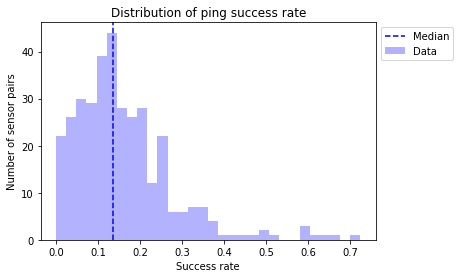

In [107]:
plt.hist(ping_success_rate['success_rate'],
         bins=30,
         facecolor='blue',
         alpha=0.3,
         label='Data')
plt.axvline(ping_success_rate['success_rate'].median(),
            linestyle='dashed',
            color='blue',
            label='Median')
plt.xlabel('Success rate')
plt.ylabel('Number of sensor pairs')
plt.title('Distribution of ping success rate')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

As a rough check on our data restructuring above, we can run the same histogram from the original dataframe. Note that this will omit the handful of pairs with no ping data, but that will only affect the far left side of the chart.

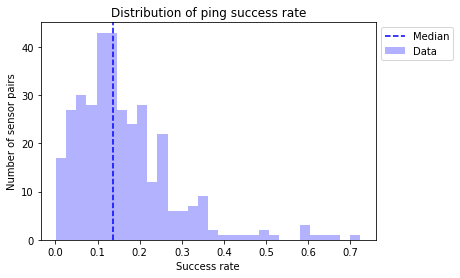

In [108]:
ping_count = usable_data.groupby(['remote_id', 'local_id']).agg({'observed_at': 'nunique'}).rename(columns={'observed_at': 'N'})
ping_count['N'] = ping_count['N']/num_timesteps
ping_count = ping_count.rename(columns={'N': 'success_rate'})
plt.hist(ping_count['success_rate'],
         bins=30,
         facecolor='blue',
         alpha=0.3,
         label='Data')
plt.axvline(ping_count['success_rate'].median(),
            linestyle='dashed',
            color='blue',
            label='Median')
plt.xlabel('Success rate')
plt.ylabel('Number of sensor pairs')
plt.title('Distribution of ping success rate')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

We don't know how this lines up with distance because we don't have ground truth distance data, but we might guess that the median success rate (about 13.5%) is typical for the presumed median distance between sensors (about 10 meters, roughly half the length of the room).

### Signal strength

Now we want to look at the distribution of measured RSSI values, but we need to take care to remove the zero values where no ping was received.

In [109]:
measured_rssi_values = y_continuous_t[y_continuous_t != 0.0]

In [110]:
measured_rssi_values.shape

(40447L,)

In [111]:
np.median(measured_rssi_values)

-80.0

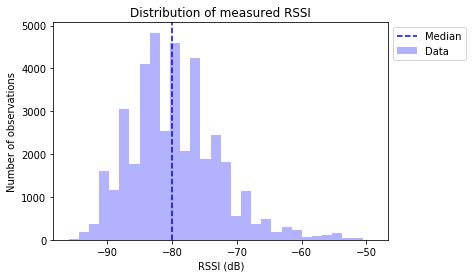

In [112]:
plt.hist(measured_rssi_values,
         bins=30,
         facecolor='blue',
         alpha=0.3,
         label='Data')
plt.axvline(np.median(measured_rssi_values),
            linestyle='dashed',
            color='blue',
            label='Median')
plt.xlabel('RSSI (dB)')
plt.ylabel('Number of observations')
plt.title('Distribution of measured RSSI')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

As a rough check on our data restructuring above, we can run the same histogram from the original dataframe.

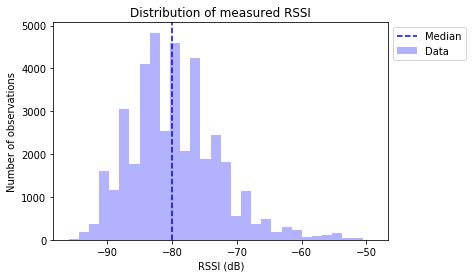

In [113]:
plt.hist(usable_data['rssi'],
         bins=30,
         facecolor='blue',
         alpha=0.3,
         label='Data')
plt.axvline(usable_data['rssi'].median(),
            linestyle='dashed',
            color='blue',
            label='Median')
plt.xlabel('RSSI (dB)')
plt.ylabel('Number of observations')
plt.title('Distribution of measured RSSI')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Again, we don't know how this lines up with distance because we don't have ground truth distance data, but we might guess that the median measured RSSI value (about -80 dB) is typical for the presumed median distance between sensors (about 10 meters, roughly half the length of the room).

## Explore and visualize model inputs

Generate 1,000 samples of `x_initial_sample()` and check that they have the properties we expect.

In [114]:
time_start = time.clock()
x_discrete_initial_samples, x_continuous_initial_samples = sensor_model.x_initial_sample(1000)
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.00249600000001


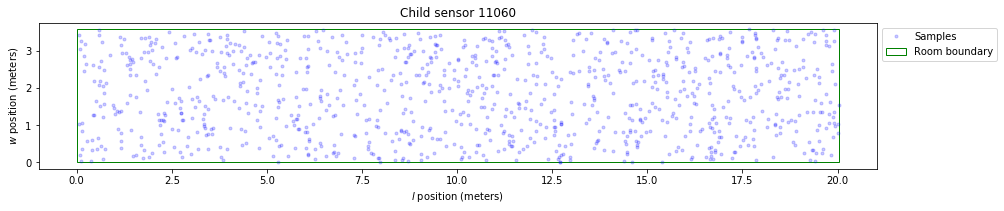

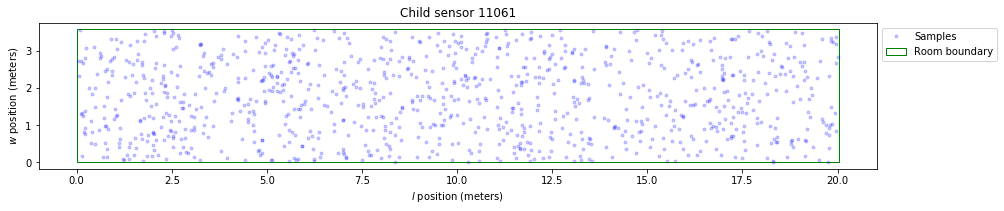

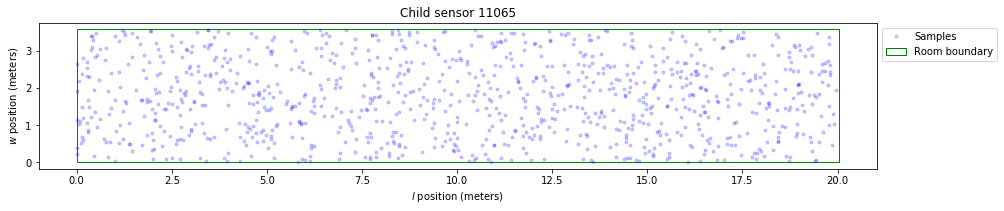

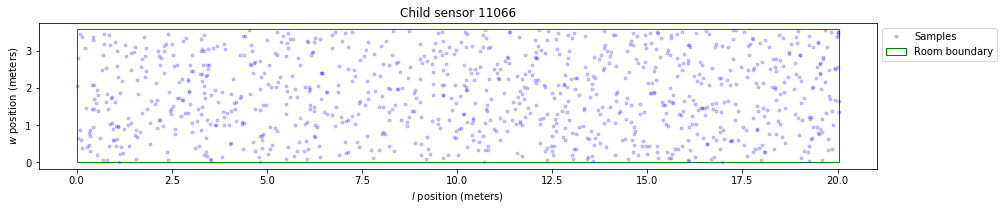

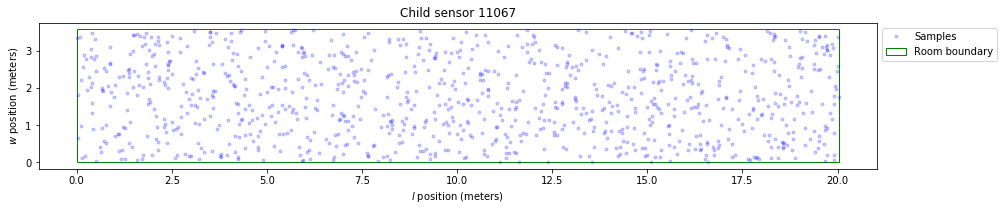

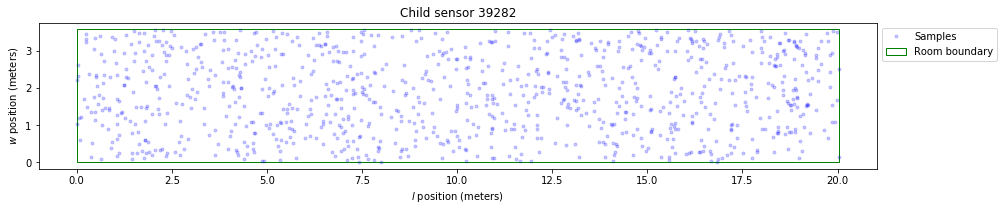

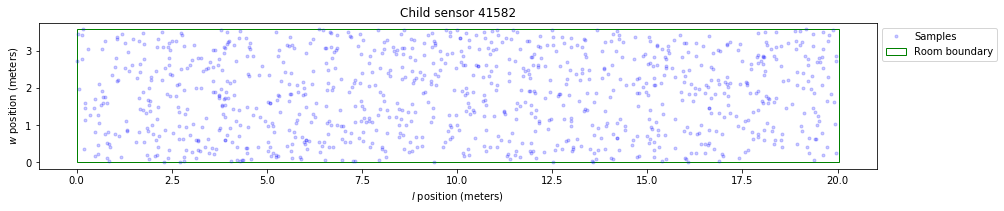

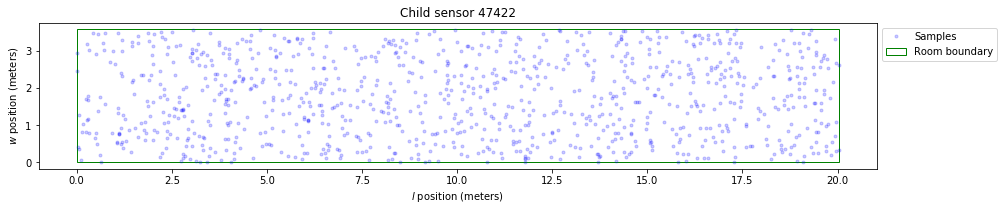

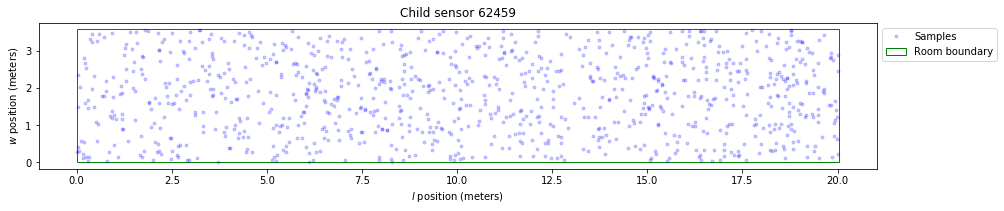

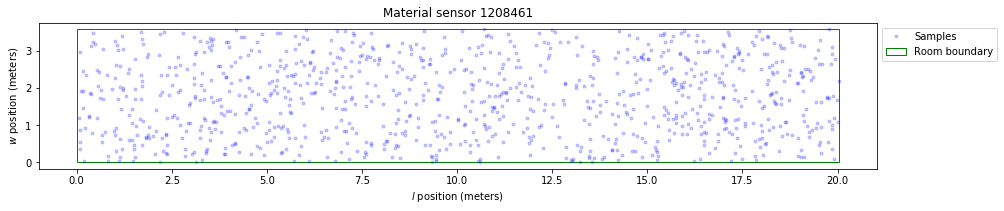

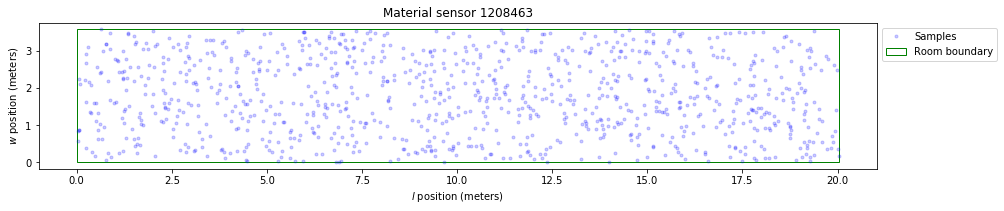

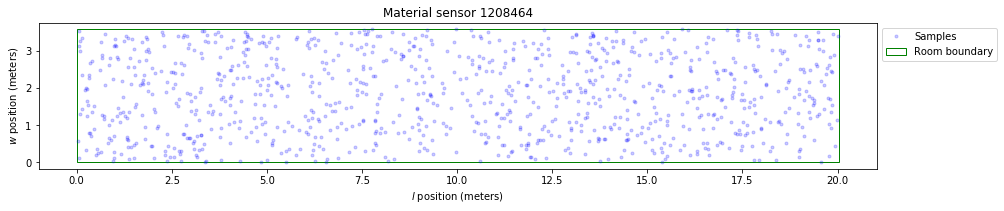

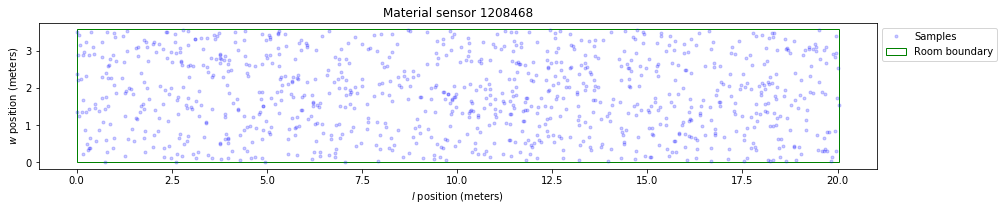

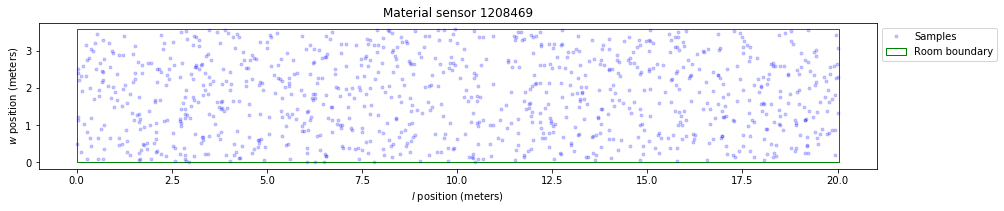

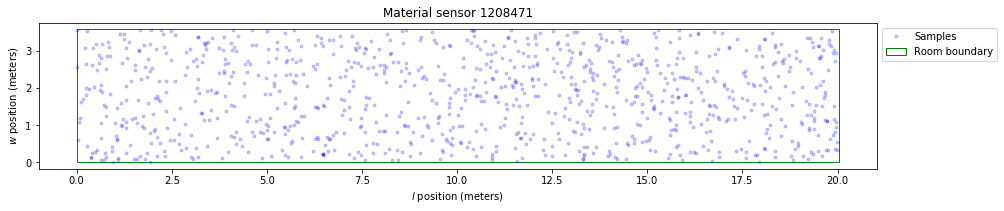

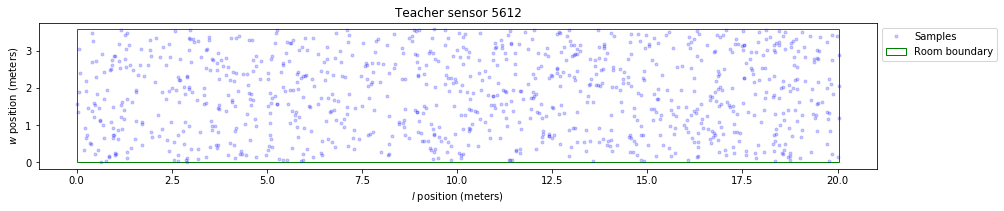

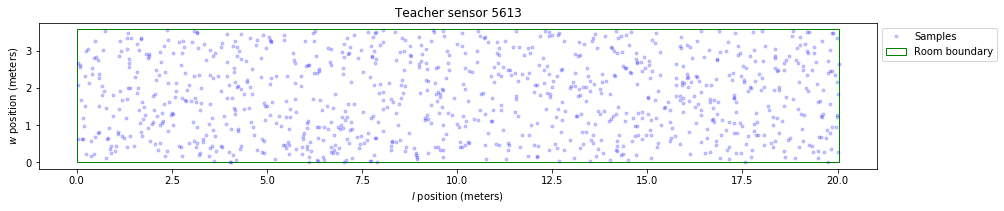

In [115]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(sensor_model.num_moving_sensors):
    plt.plot(x_continuous_initial_samples[:,sensor_index*2],
             x_continuous_initial_samples[:,sensor_index*2 + 1],
             'b.',
             alpha = 0.2,
             label="Samples")
    plt.title(sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(dimension_names[1]))
    ax=plt.gca()
    ax.add_patch(patches.Rectangle((0,0),
                                   room_size[0],
                                   room_size[1],
                                   fill=False,
                                   color='green',
                                   label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

Choose an arbitrary test value for $\mathbf{X}$, drawn from the initial distribution, that we can use to test the various functions below.

In [116]:
test_x_discrete_value, test_x_continuous_value = sensor_model.x_initial_sample()

Generate 1,000 samples from `x_bar_x_prev_sample()` (using our test value for $\mathbf{X}_{t-1}$) to make sure they have the properties we expect.

In [117]:
time_start = time.clock()
x_discrete_bar_x_prev_samples, x_continuous_bar_x_prev_samples = sensor_model.x_bar_x_prev_sample(np.array([]),
                                                                                                  np.tile(test_x_continuous_value,
                                                                                                          (1000,1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 0.0192814933333


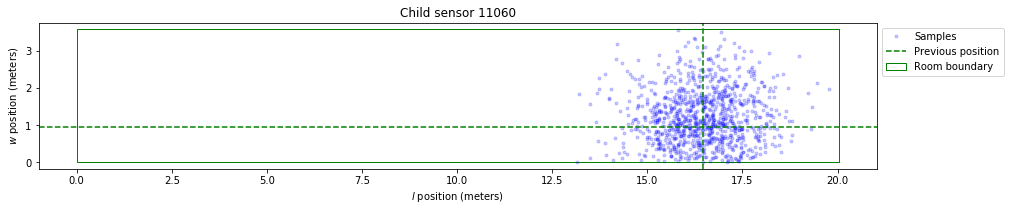

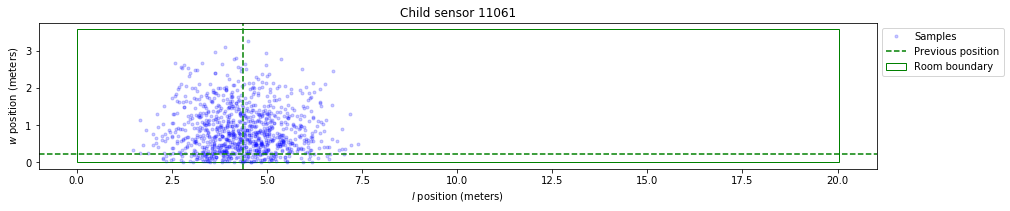

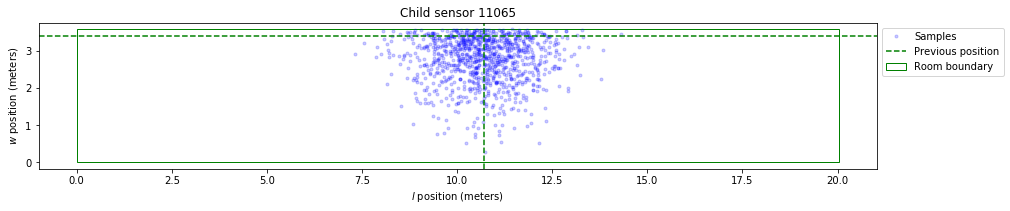

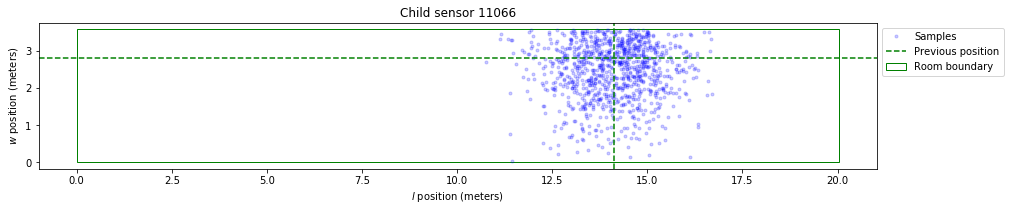

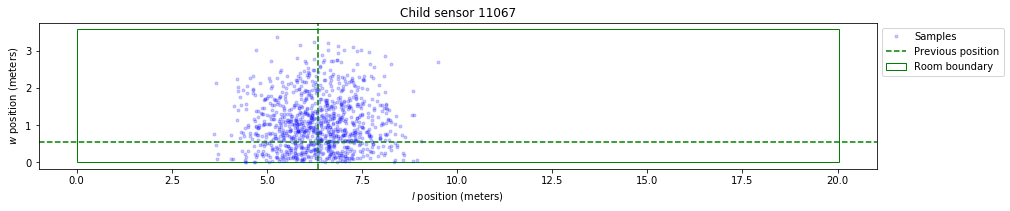

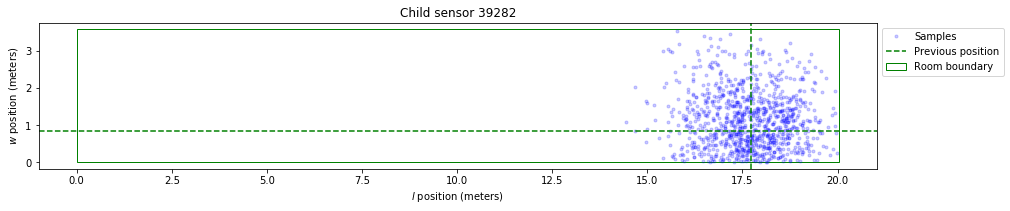

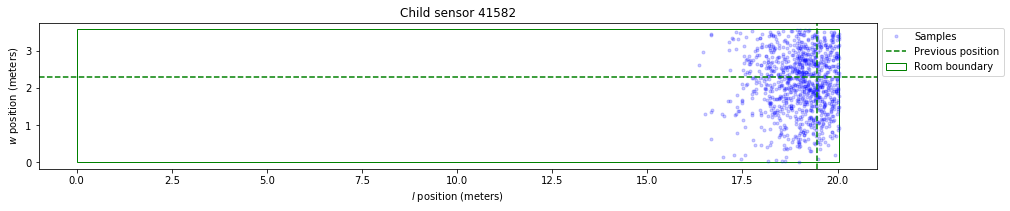

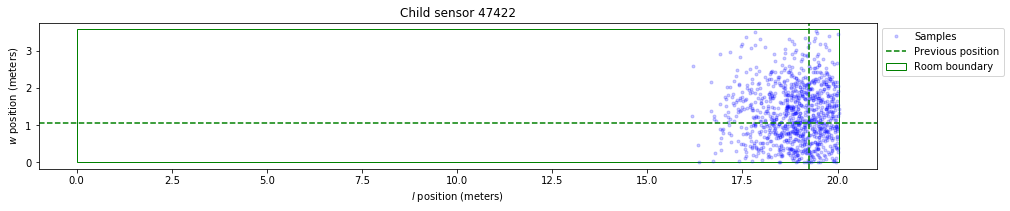

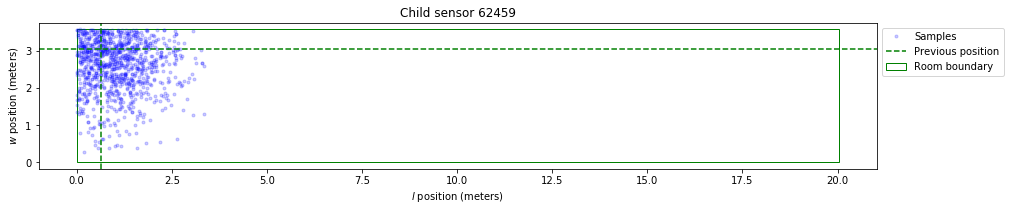

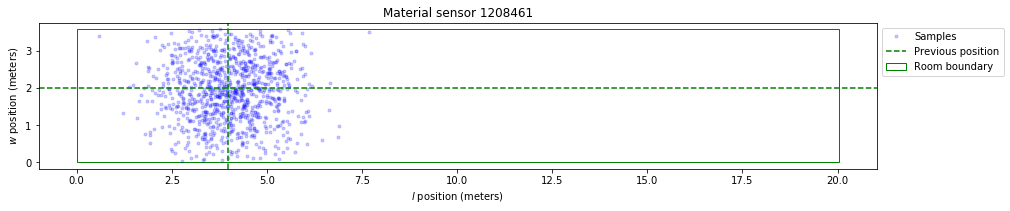

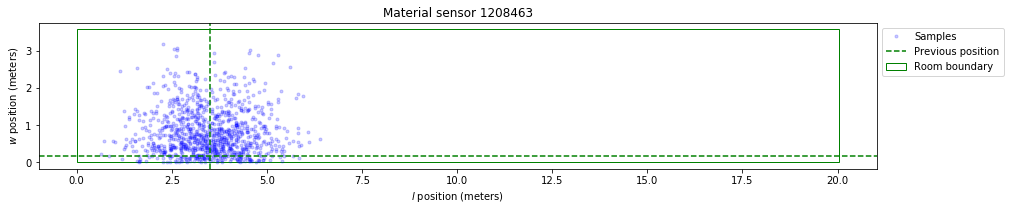

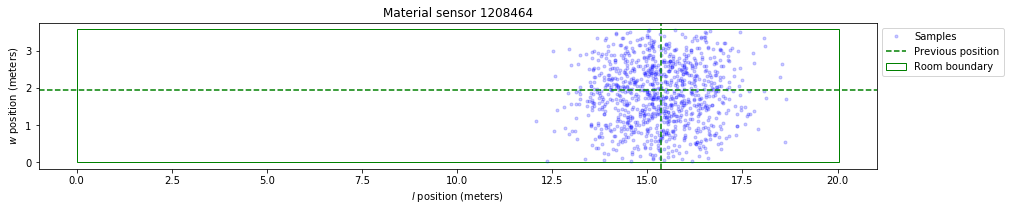

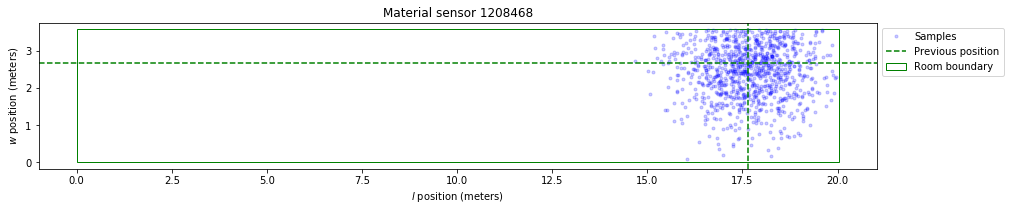

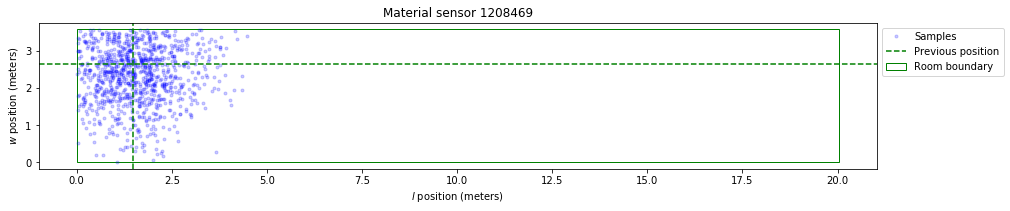

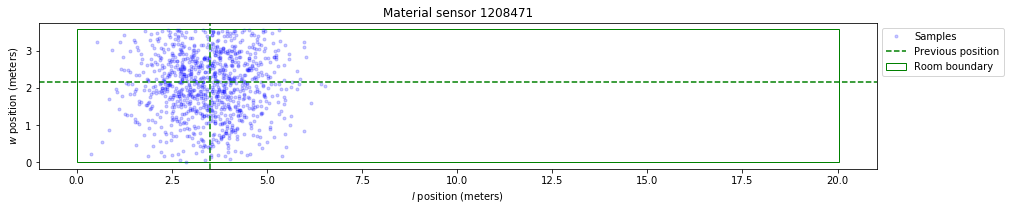

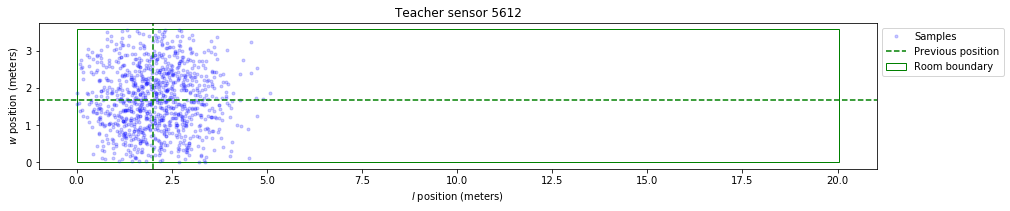

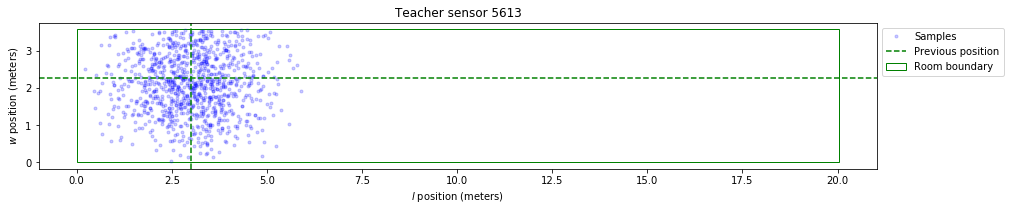

In [118]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(sensor_model.num_moving_sensors):
    plt.plot(x_continuous_bar_x_prev_samples[:,sensor_index*2],
             x_continuous_bar_x_prev_samples[:,sensor_index*2 + 1],
             'b.',
             alpha=0.2,
            label='Samples')
    plt.title(sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(dimension_names[1]))
    plt.axvline(x=test_x_continuous_value[sensor_index*2],
                linestyle='dashed',
                color='green',
                label='Previous position')
    plt.axhline(y=test_x_continuous_value[sensor_index*2 + 1], linestyle='dashed', color='green')
    ax=plt.gca()
    ax.add_patch(patches.Rectangle((0,0),
                                   room_size[0],
                                   room_size[1],
                                   fill=False,
                                   color='green',
                                   label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

Generate 1,000 samples from `y_discrete_bar_x_sample()` (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [119]:
time_start = time.clock()
y_discrete_bar_x_samples = sensor_model.y_discrete_bar_x_sample(np.tile(test_x_discrete_value, (1000,1)),
                                                                np.tile(test_x_continuous_value, (1000,1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 11.1670481067


In [120]:
distances_test_x_continuous_value = sensor_model.distances(sensor_model.sensor_positions(test_x_continuous_value))

Plot the results for 10 randomly chosen discrete $\mathbf{Y}$ variables.

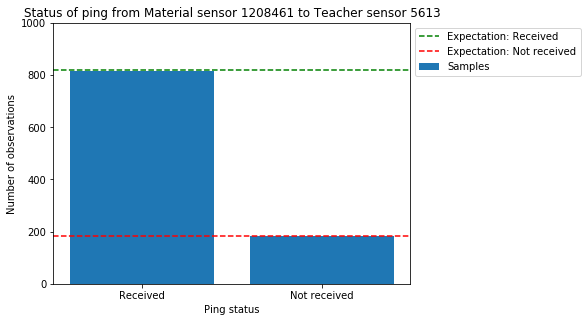

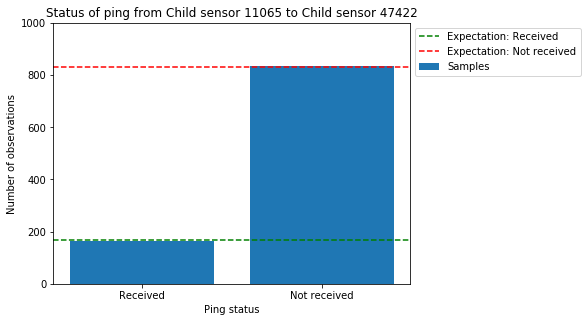

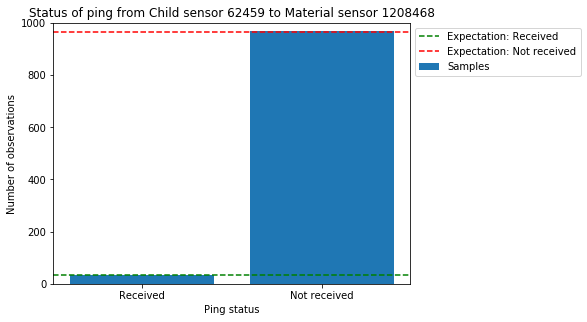

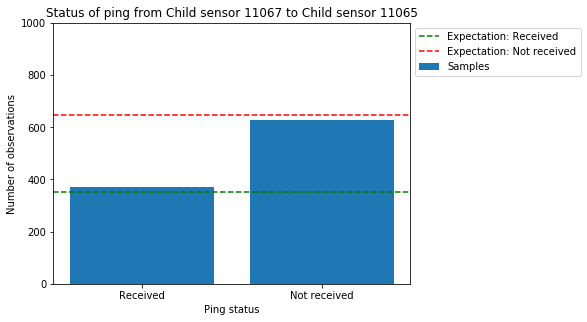

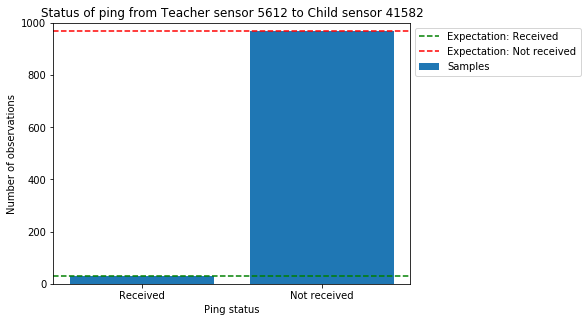

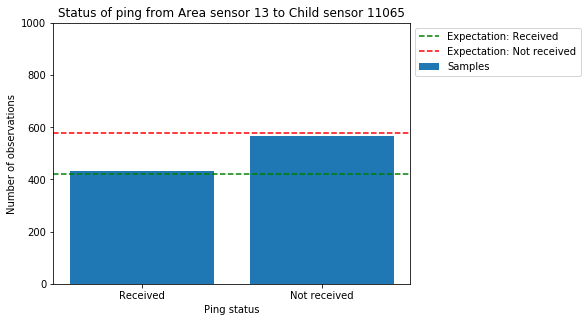

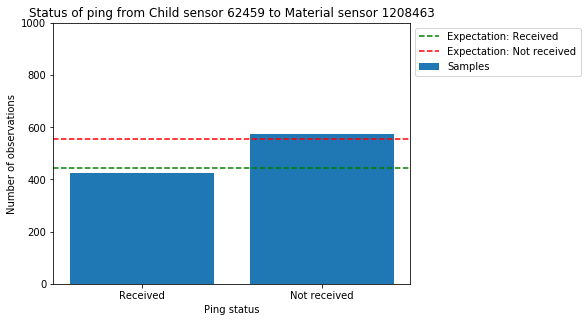

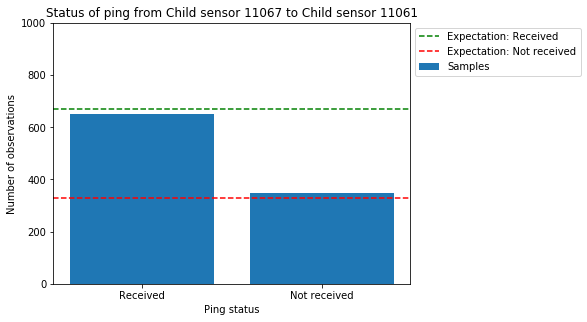

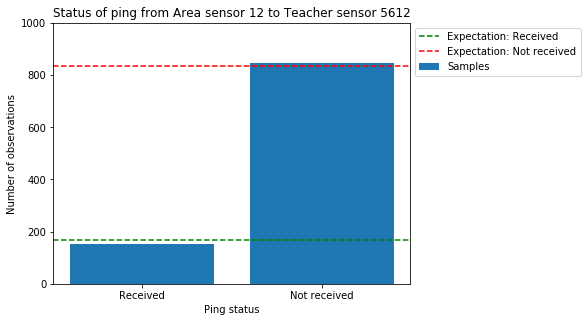

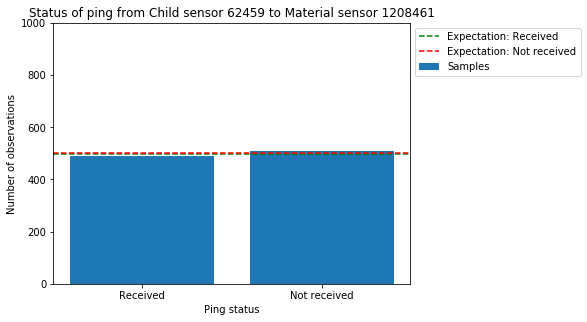

In [121]:
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    plt.bar(range(num_ping_statuses), np.bincount(y_discrete_bar_x_samples[:,y_discrete_var_index]), label='Samples')
    for ping_status_index in range(num_ping_statuses):
        plt.axhline(y=sensor_model.ping_success_probabilities_array(distances_test_x_continuous_value[y_discrete_var_index])[ping_status_index]*1000,
                    linestyle='dashed',
                    color=['green', 'red'][ping_status_index],
                    label='Expectation: {}'.format(ping_status_names[ping_status_index]))
    plt.xticks(range(num_ping_statuses), ping_status_names)
    plt.xlabel('Ping status')
    plt.ylabel('Number of observations')
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.ylim(0, 1000)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Generate 100,000 samples from `y_continuous_bar_x_sample()` (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [122]:
time_start = time.clock()
y_continuous_bar_x_samples = sensor_model.y_continuous_bar_x_sample(np.tile(test_x_discrete_value, (100000, 1)),
                                                                    np.tile(test_x_continuous_value, (100000, 1)))
print'Time elapsed = {}'.format(time.clock()-time_start)

Time elapsed = 18.2446344533


Plot these samples for 10 randomly chosen continuous $\mathbf{Y}$ variables.

C:\Users\tcqui\Anaconda2\envs\sensor_localization\lib\site-packages\scipy\stats\_continuous_distns.py:5374: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


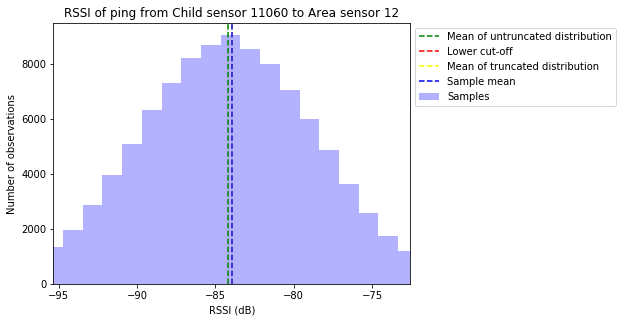

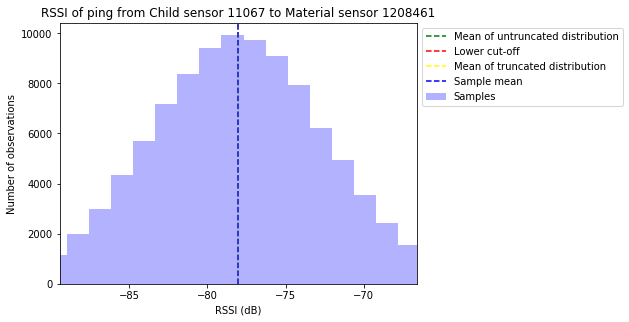

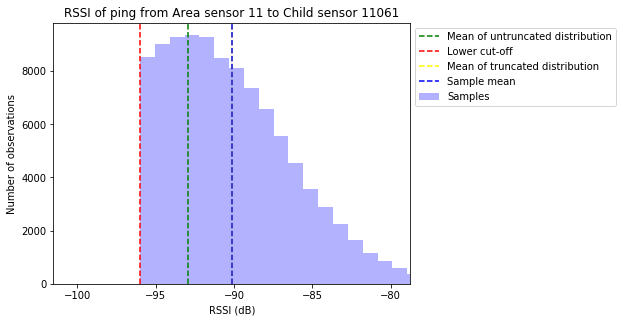

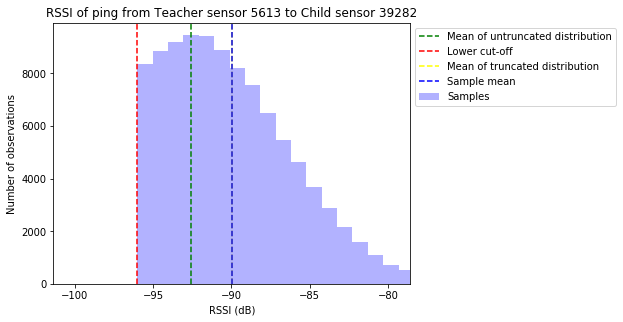

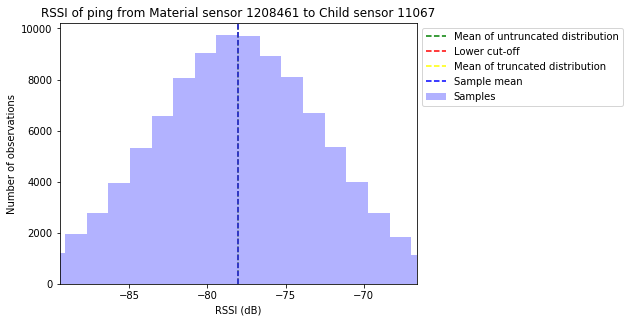

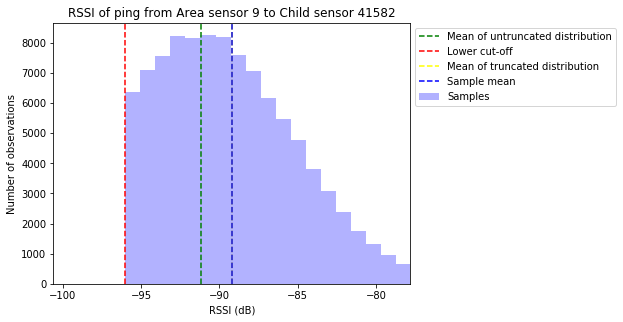

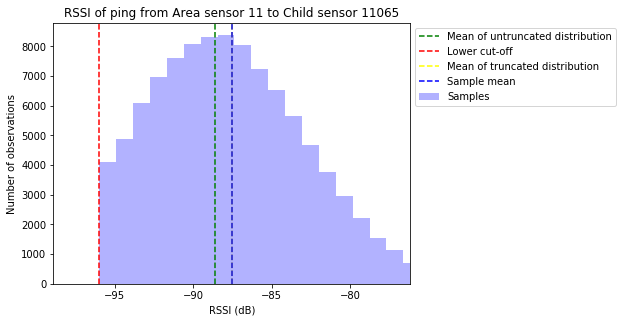

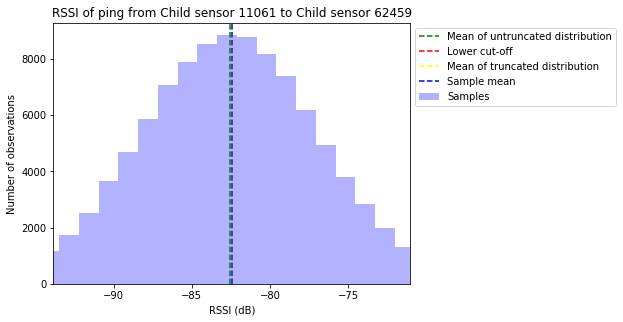

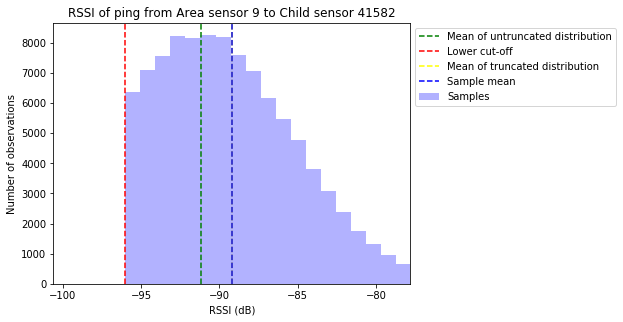

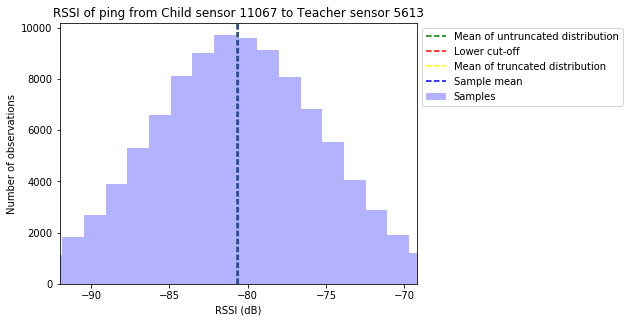

In [123]:
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    plt.hist(y_continuous_bar_x_samples[:,y_continuous_var_index],
             bins=30,
             facecolor='blue',
             alpha=0.3,
             label='Samples')
    plt.axvline(x=rssi_untruncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
                linestyle='dashed',
                color='green',
                label='Mean of untruncated distribution')
    plt.axvline(lower_rssi_cutoff,
                linestyle='dashed',
                color='red',
                label='Lower cut-off')
    plt.axvline(x=rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
                linestyle='dashed',
                color='yellow',
                label='Mean of truncated distribution')
    plt.axvline(np.mean(y_continuous_bar_x_samples[:,y_continuous_var_index]),
                linestyle='dashed',
                color='blue',
                label='Sample mean')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Number of observations')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlim(rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]) - 2*rssi_untruncated_std_dev,
             rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]) + 2*rssi_untruncated_std_dev)
    plt.show()

Using our test value for $\mathbf{X}$, plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on each sensor reading (holding the values of all of the other sensor readings fixed), to make sure it has the shape we expect. First we plot the dependence on the discrete sensor variables for 10 randomly chosen variables.

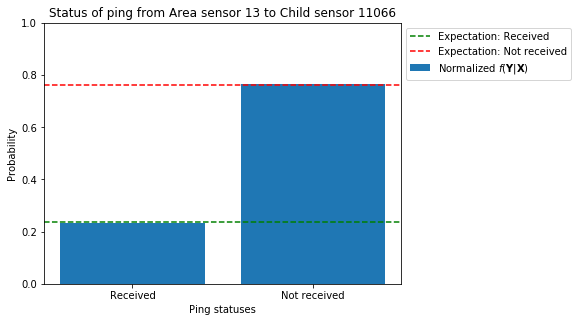

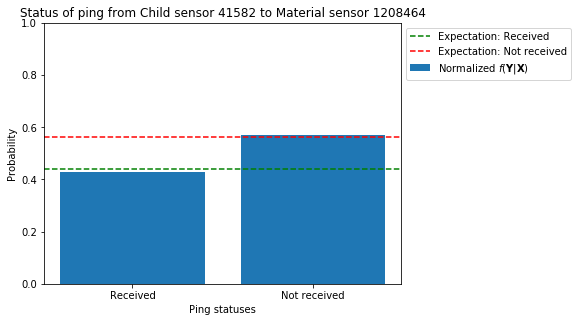

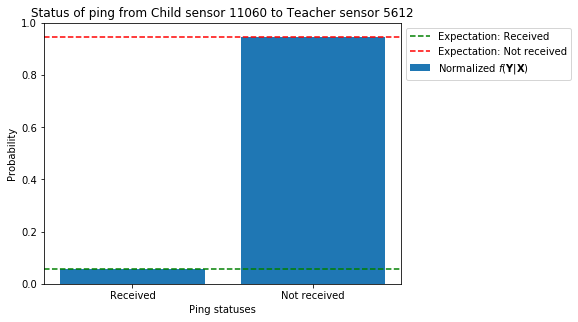

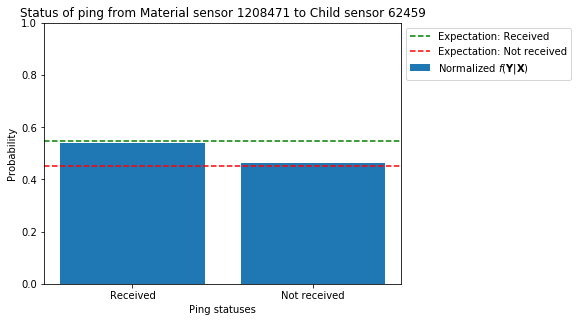

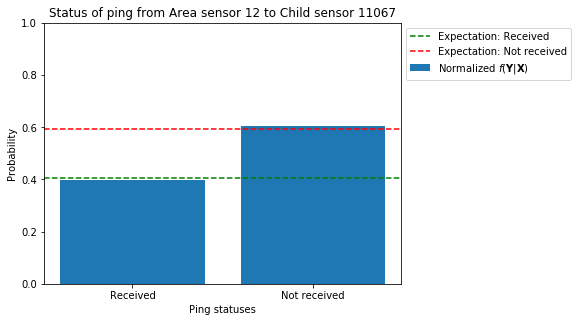

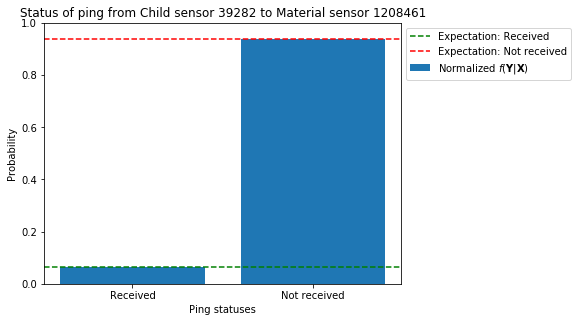

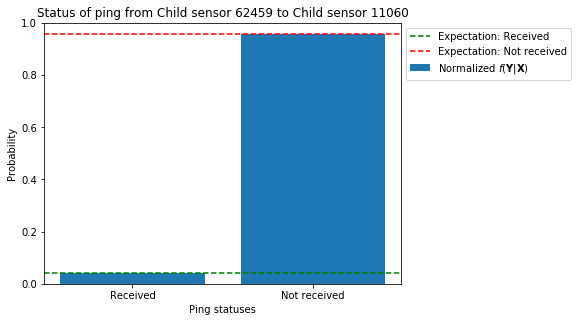

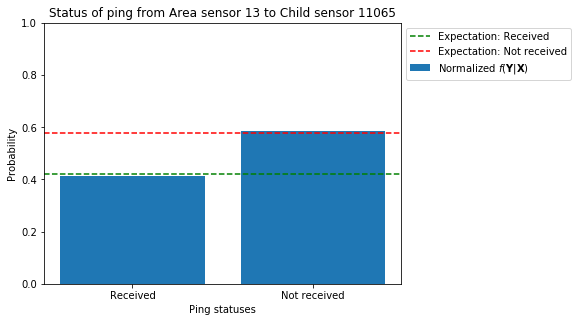

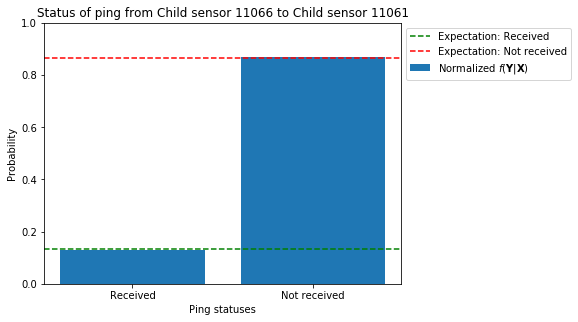

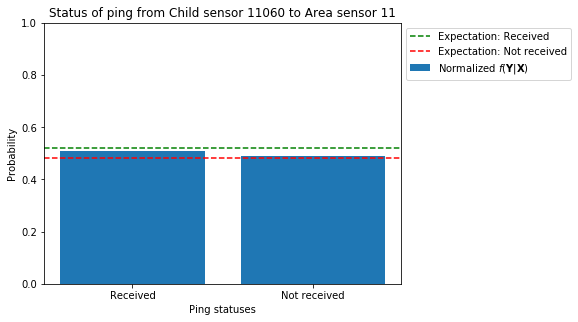

In [124]:
mean_rssi_values = rssi_truncated_mean(distances_test_x_continuous_value)
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    test_y_discrete_value = np.repeat(0, variable_structure.num_y_discrete_vars)
    test_y_continuous_value = np.copy(mean_rssi_values)
    log_probability_range = np.zeros(2, dtype='float')
    log_probability_density_range = np.zeros(100, dtype='float')
    rssi_range=np.linspace(mean_rssi_values[y_discrete_var_index] - 2*rssi_untruncated_std_dev,
                           mean_rssi_values[y_discrete_var_index] + 2*rssi_untruncated_std_dev,
                           100)
    for rssi_index in range(len(rssi_range)):
        test_y_continuous_value[y_discrete_var_index] = rssi_range[rssi_index]
        log_probability_density_range[rssi_index] = sensor_model.y_bar_x_log_pdf(test_x_discrete_value,
                                                                                 test_x_continuous_value,
                                                                                 test_y_discrete_value,
                                                                                 test_y_continuous_value)
    log_probability_range[0] = special.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0])
    test_y_discrete_value[y_discrete_var_index] = 1
    test_y_continuous_value = mean_rssi_values
    log_probability_range[1] = sensor_model.y_bar_x_log_pdf(test_x_discrete_value,
                                                            test_x_continuous_value,
                                                            test_y_discrete_value,
                                                            test_y_continuous_value)
    log_probability_range = log_probability_range - special.logsumexp(log_probability_range)
    plt.bar(range(num_ping_statuses),
            np.exp(log_probability_range),
            label='Normalized $f(\mathbf{Y}|\mathbf{X})$')
    for ping_status_index in range(num_ping_statuses):
        plt.axhline(y=sensor_model.ping_success_probabilities_array(distances_test_x_continuous_value[y_discrete_var_index])[ping_status_index],
                    linestyle='dashed',
                    color=['green', 'red'][ping_status_index],
                    label='Expectation: {}'.format(ping_status_names[ping_status_index]))
    plt.xticks(range(num_ping_statuses), ping_status_names)
    plt.ylim(0,1)
    plt.xlabel('Ping statuses')
    plt.ylabel('Probability')
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Now we plot the dependence on the continuous sensor variables for 10 randomly chosen variables.

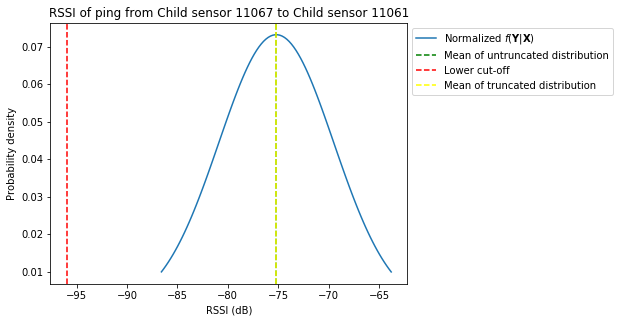

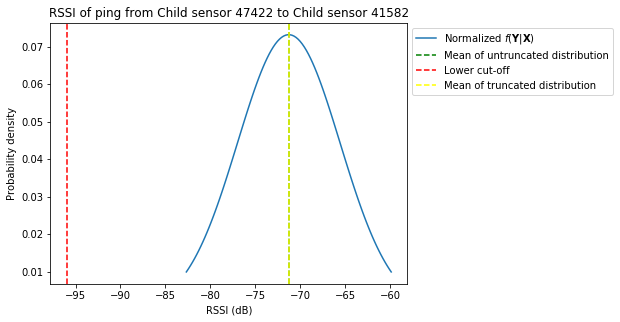

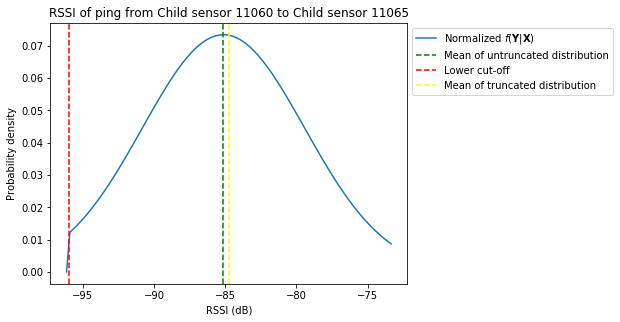

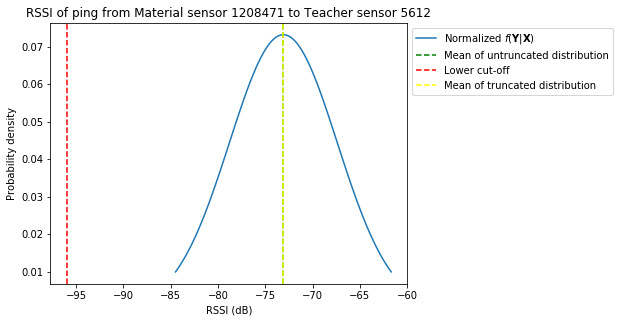

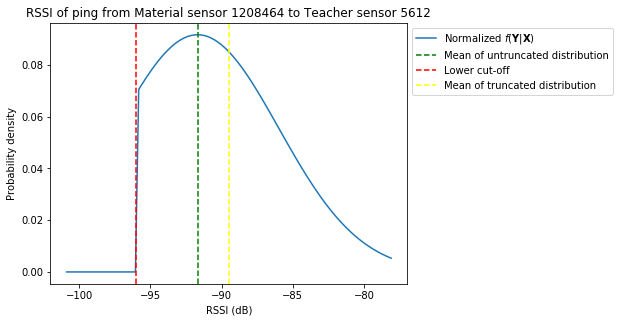

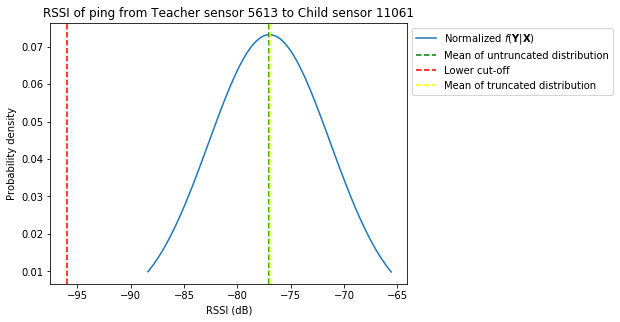

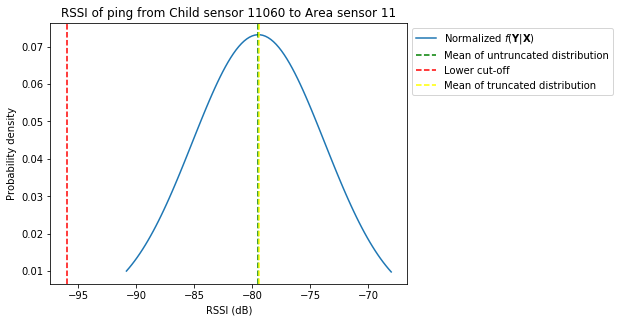

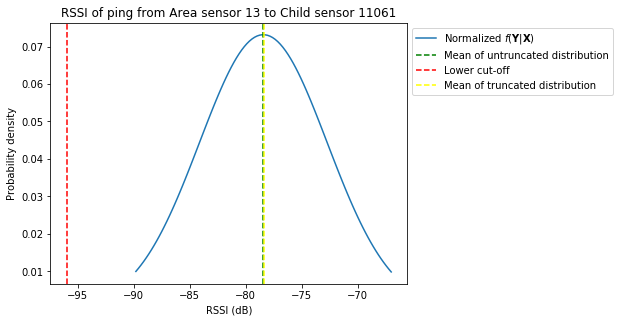

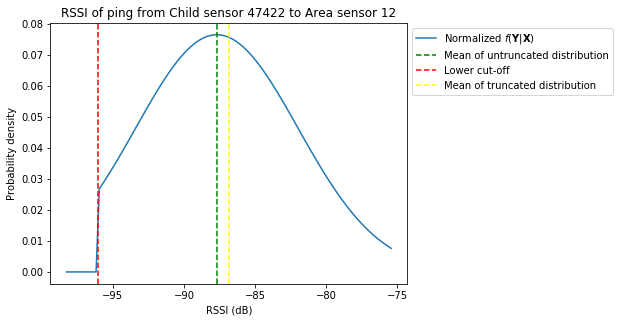

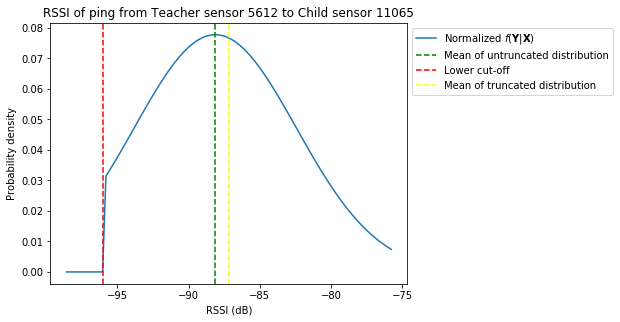

In [125]:
mean_rssi_values = rssi_truncated_mean(distances_test_x_continuous_value)
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    test_y_discrete_value = np.repeat(0, variable_structure.num_y_discrete_vars)
    test_y_continuous_value = np.copy(mean_rssi_values)
    log_probability_density_range = np.zeros(100, dtype='float')
    rssi_range=np.linspace(mean_rssi_values[y_continuous_var_index] - 2*rssi_untruncated_std_dev,
                           mean_rssi_values[y_continuous_var_index] + 2*rssi_untruncated_std_dev,
                           100)
    for rssi_index in range(len(rssi_range)):
        test_y_continuous_value[y_continuous_var_index] = rssi_range[rssi_index]
        log_probability_density_range[rssi_index] = sensor_model.y_bar_x_log_pdf(test_x_discrete_value,
                                                                                 test_x_continuous_value,
                                                                                 test_y_discrete_value,
                                                                                 test_y_continuous_value)
    log_probability_density_range = log_probability_density_range - (special.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0]))
    plt.plot(rssi_range, np.exp(log_probability_density_range), label='Normalized $f(\mathbf{Y} | \mathbf{X})$')
    plt.axvline(x=rssi_untruncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
                linestyle='dashed',
                color='green',
                label='Mean of untruncated distribution')
    plt.axvline(lower_rssi_cutoff,
                linestyle='dashed',
                color='red',
                label='Lower cut-off')
    plt.axvline(x=rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
                linestyle='dashed',
                color='yellow',
                label='Mean of truncated distribution')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Probability density')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Explore and visualize model outputs

### Real data

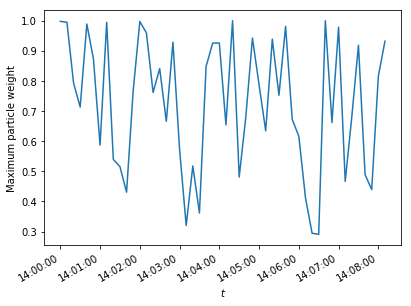

In [126]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test[:num_timesteps_test], max_weights)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Maximum particle weight')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

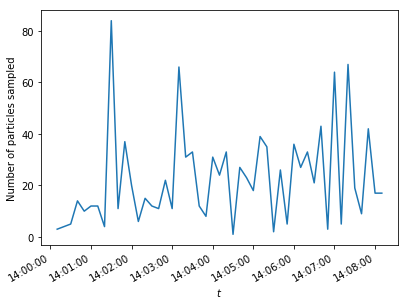

In [127]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test[1:num_timesteps_test], num_sampled_particles)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of particles sampled')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample means of the particles.

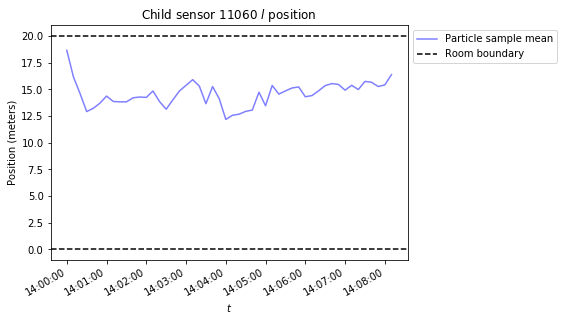

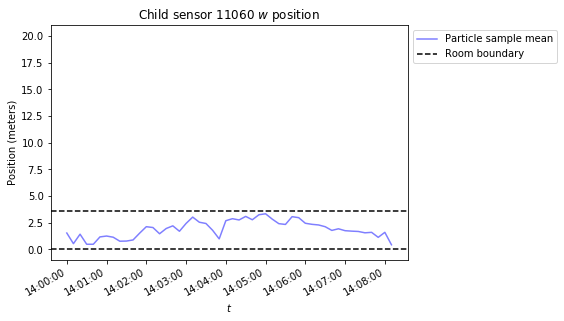

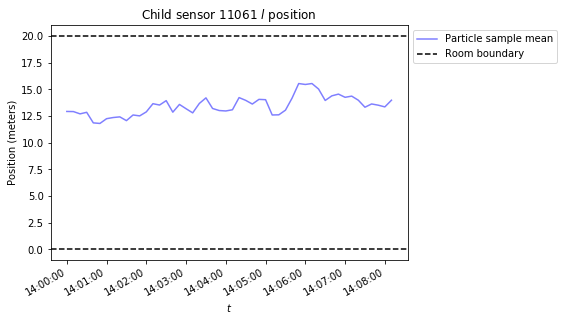

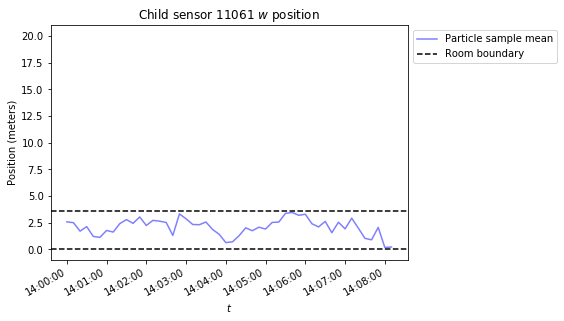

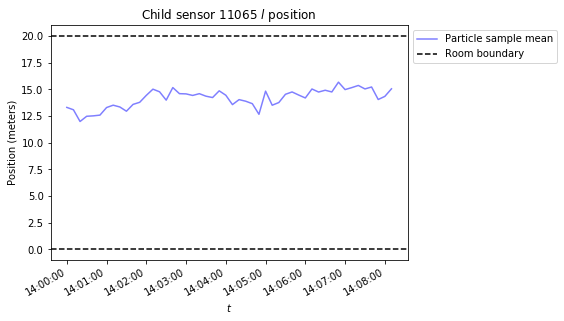

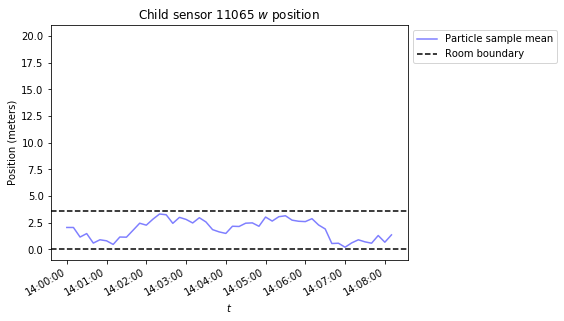

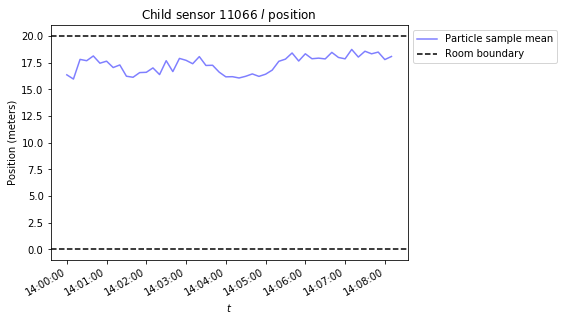

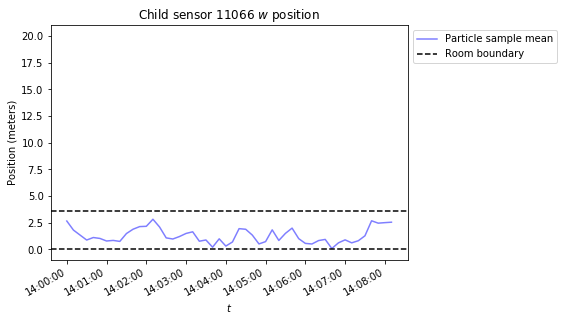

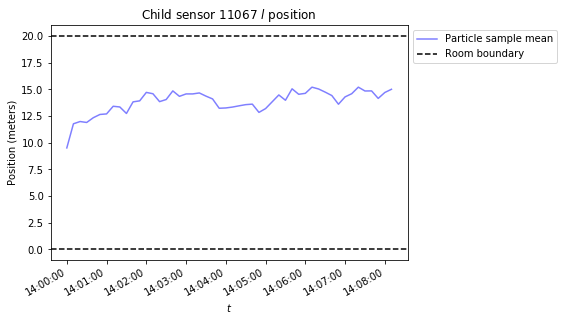

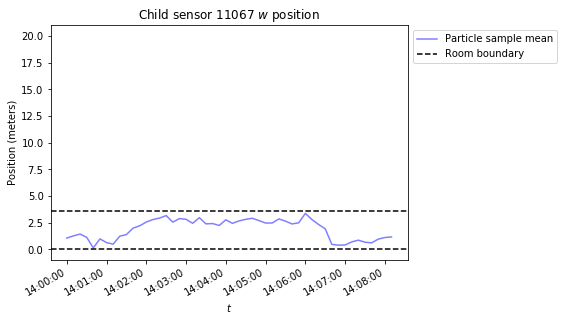

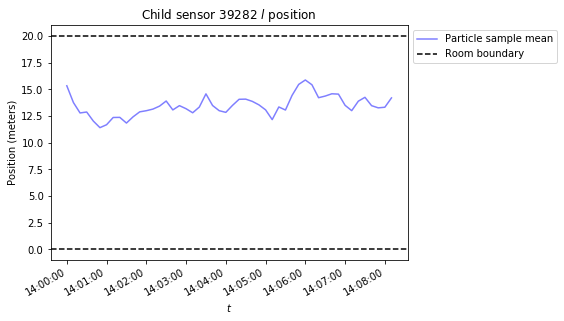

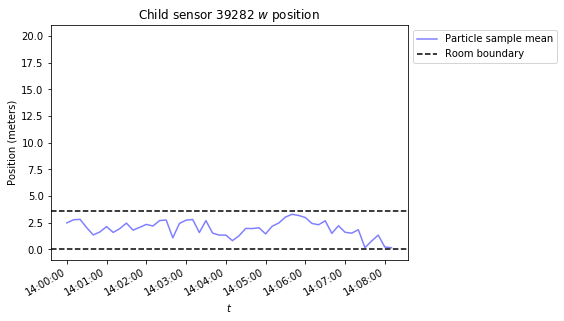

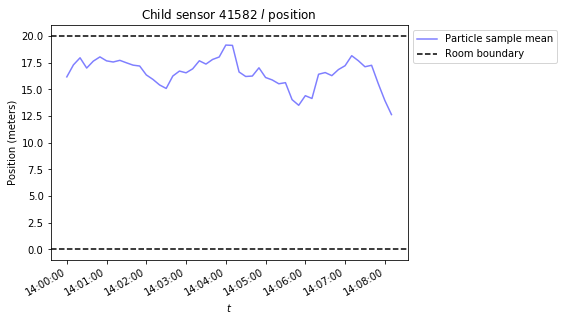

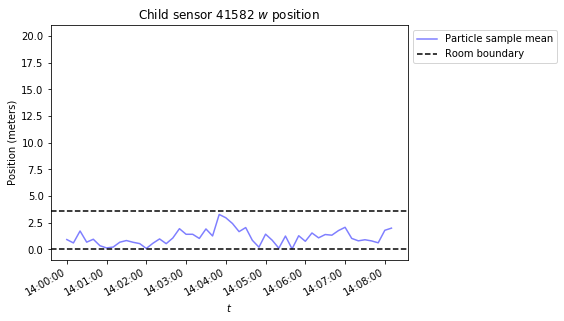

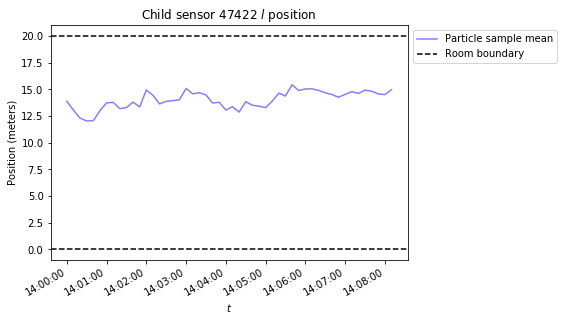

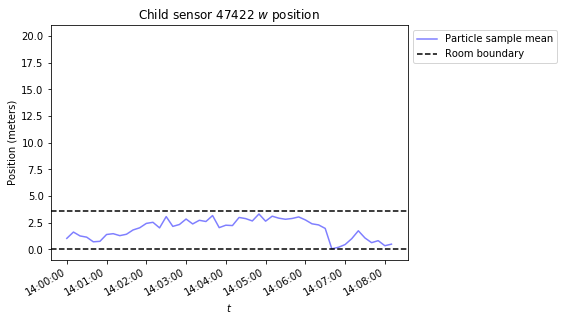

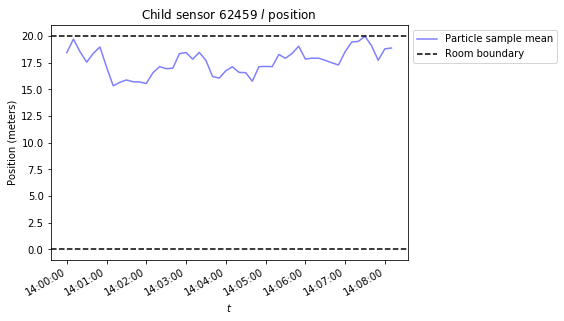

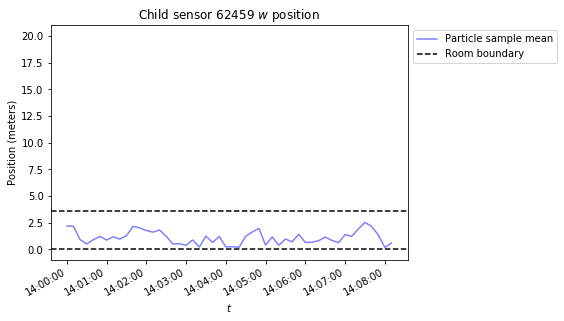

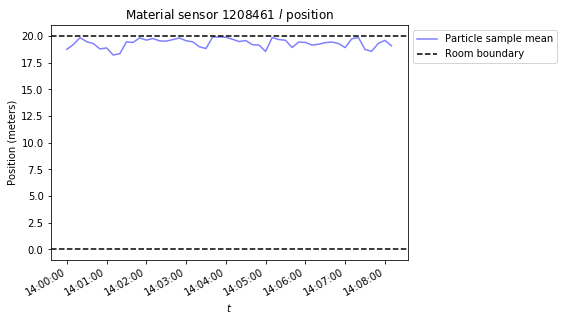

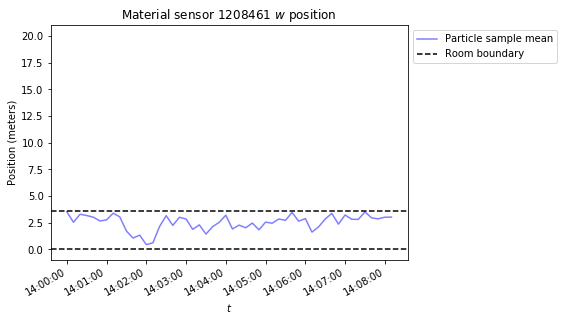

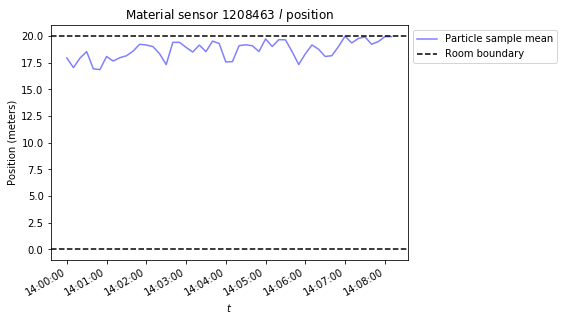

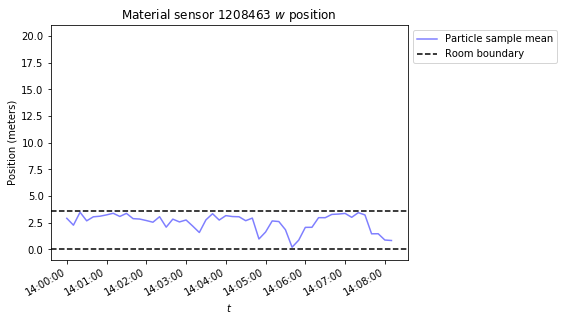

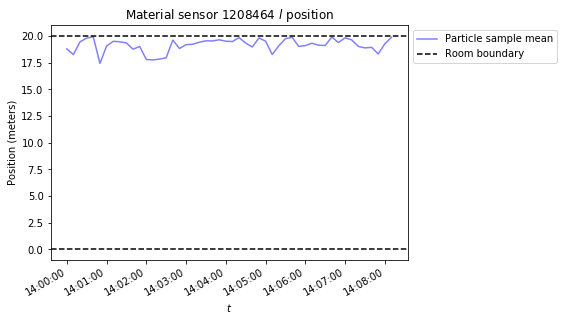

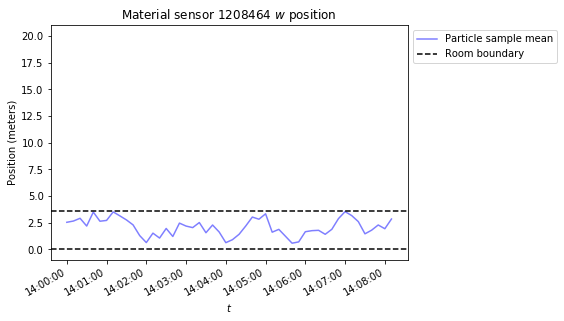

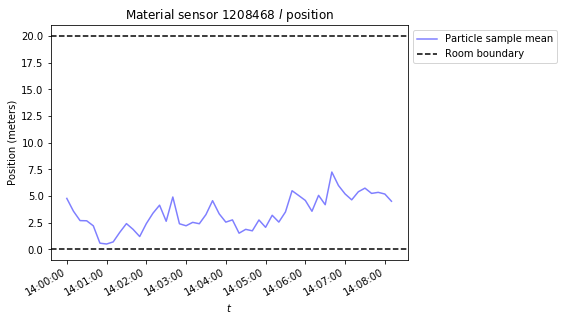

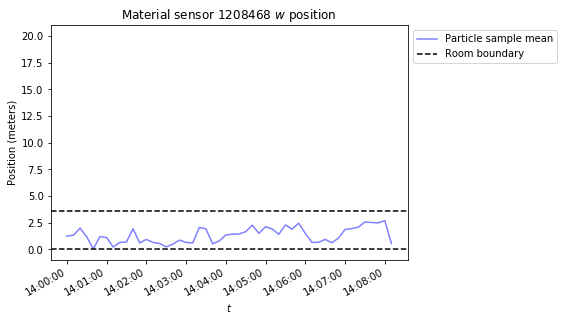

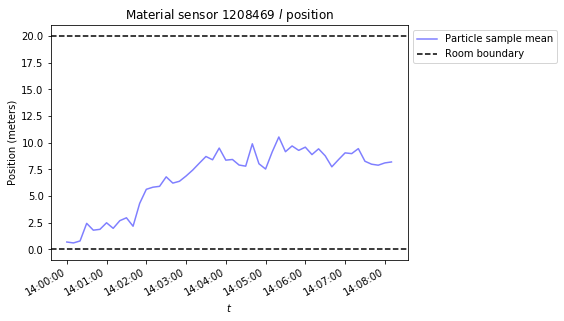

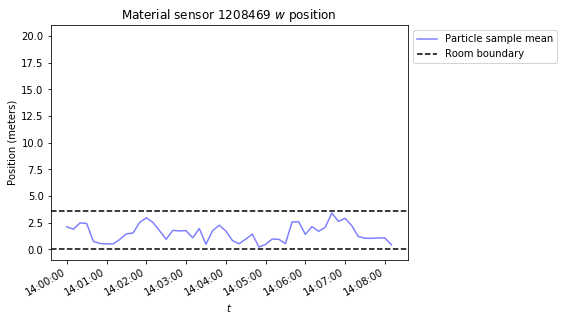

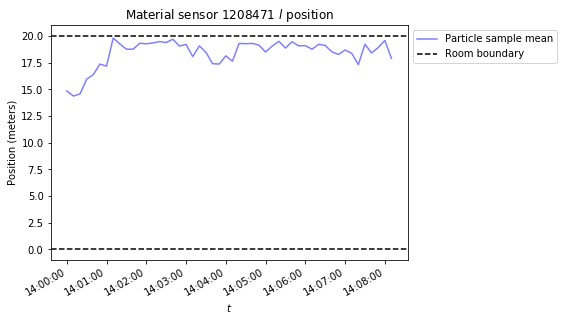

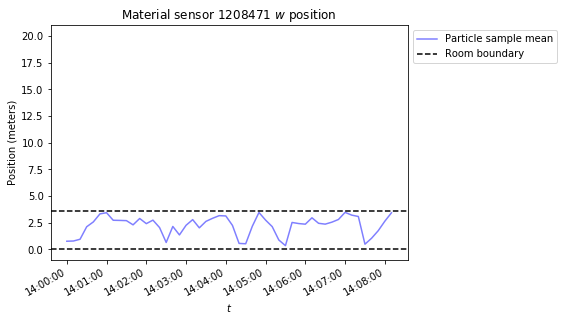

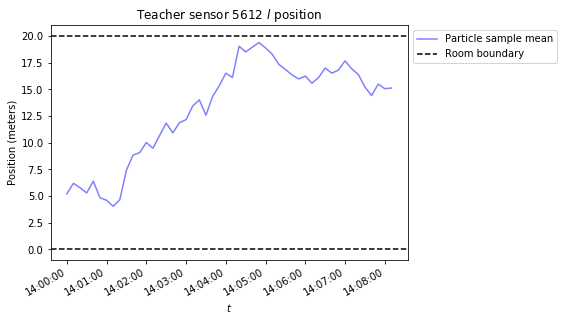

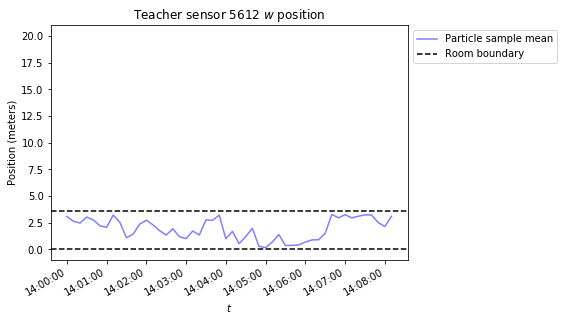

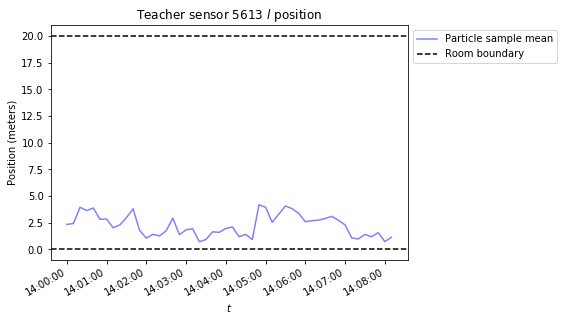

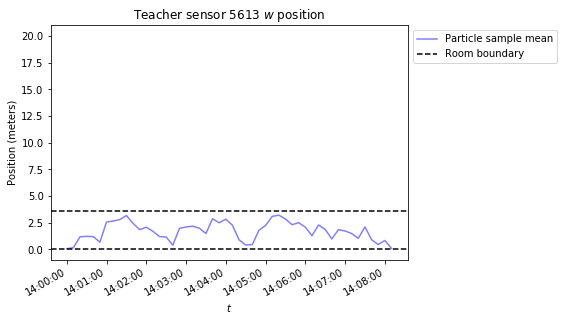

In [128]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_test[:num_timesteps_test], x_continuous_mean_particle[:,x_var_index], 'b-', alpha=0.5, label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles (i.e., sample means plus/minus sample standard deviations)

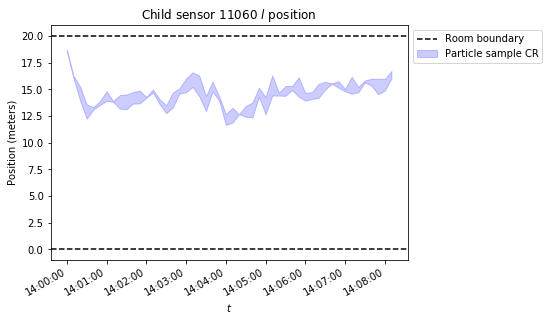

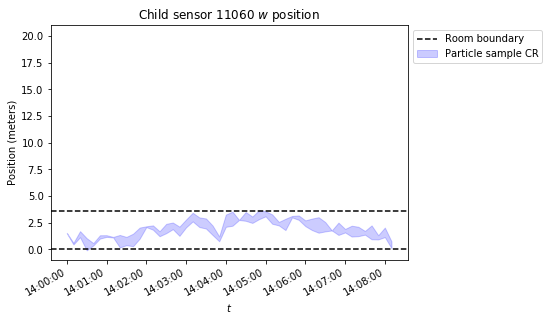

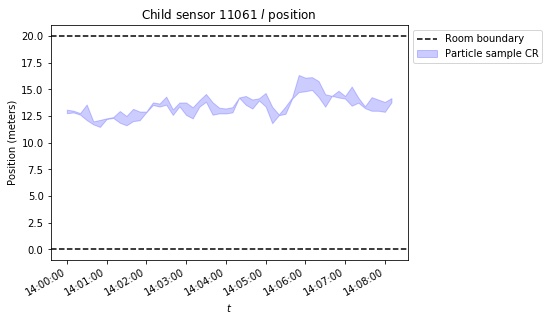

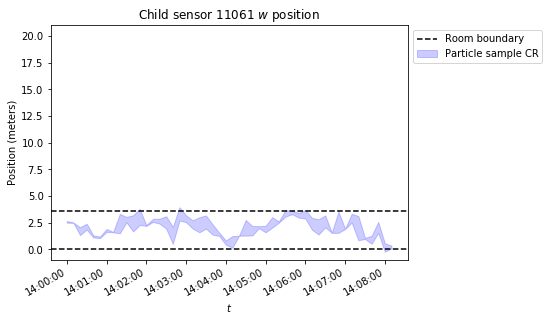

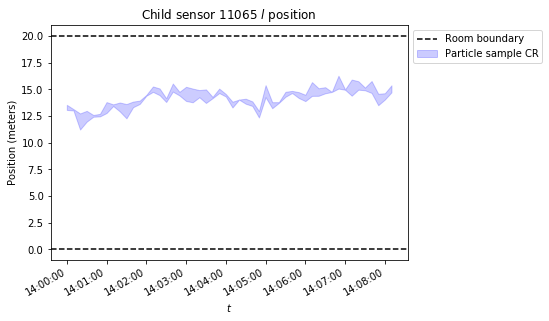

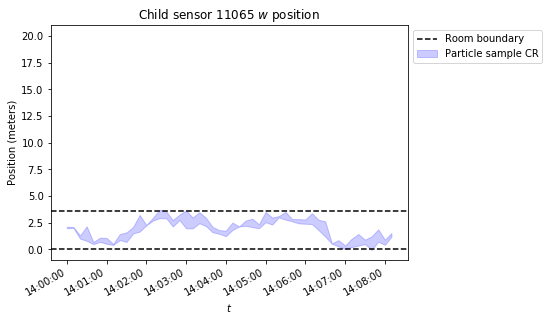

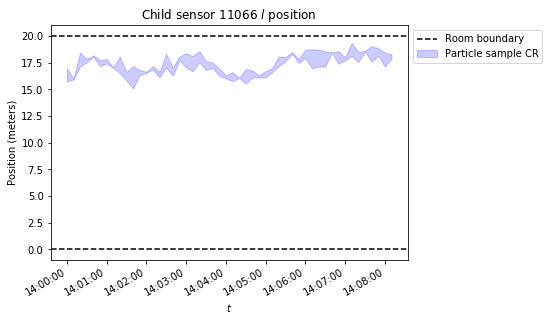

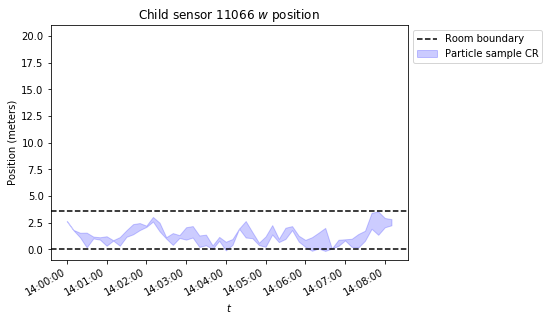

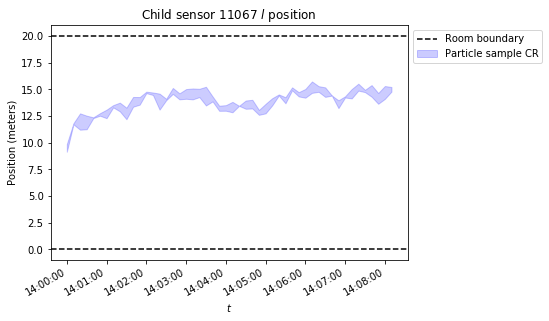

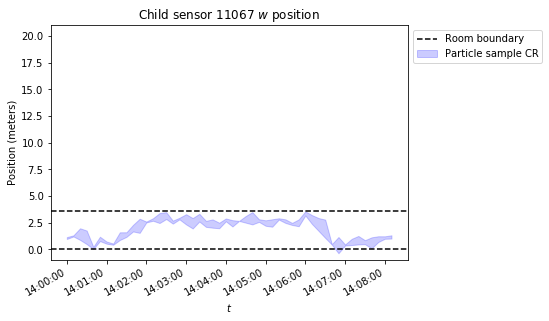

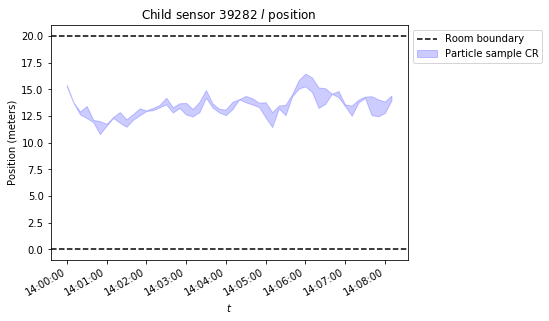

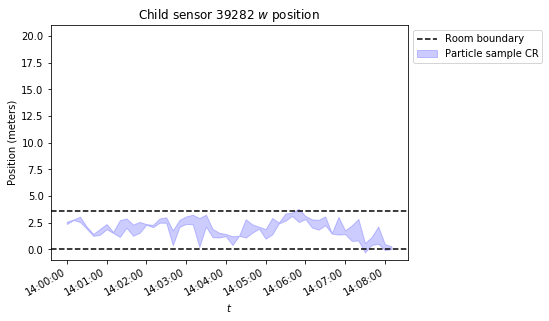

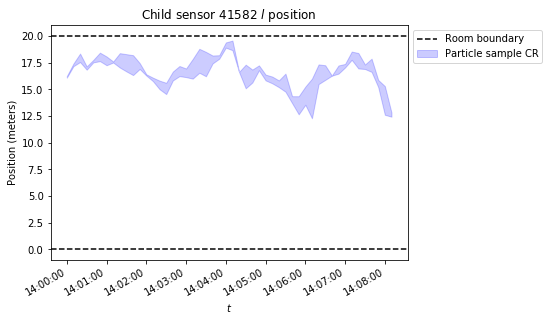

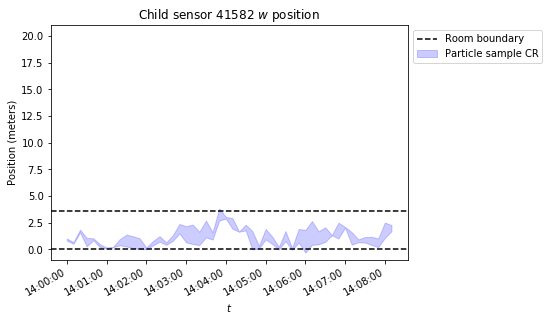

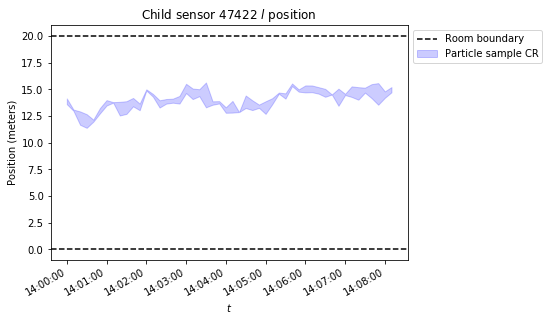

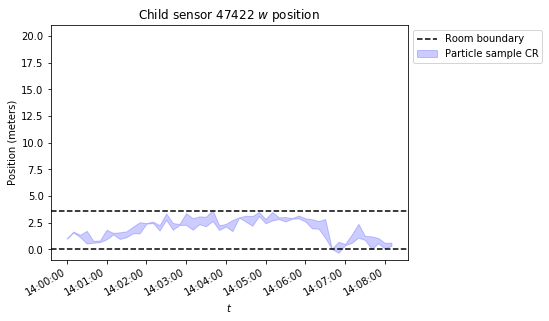

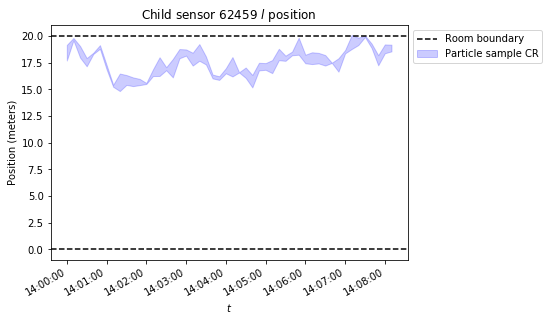

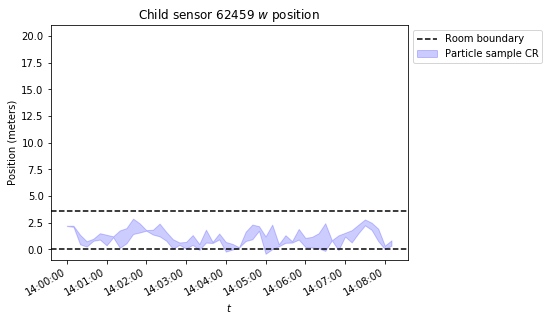

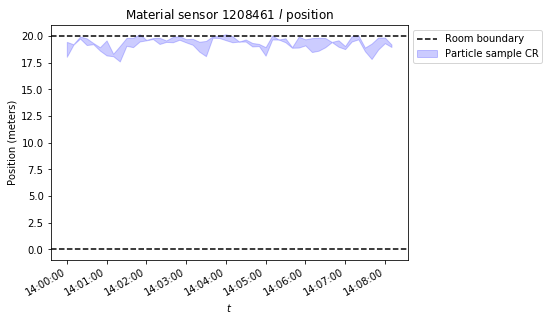

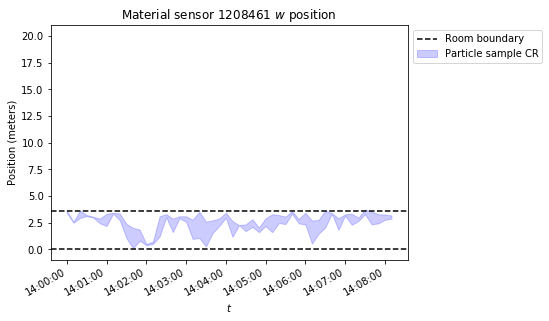

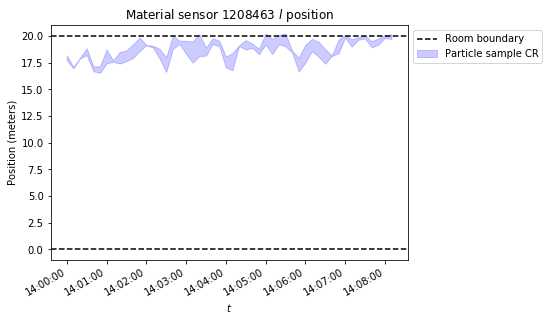

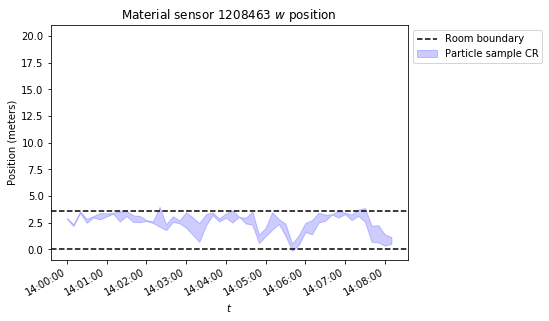

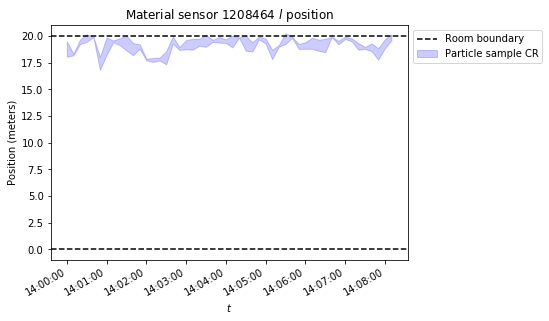

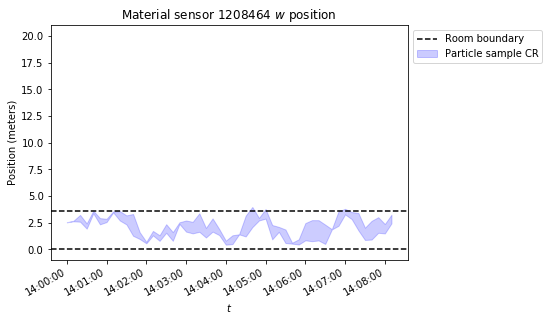

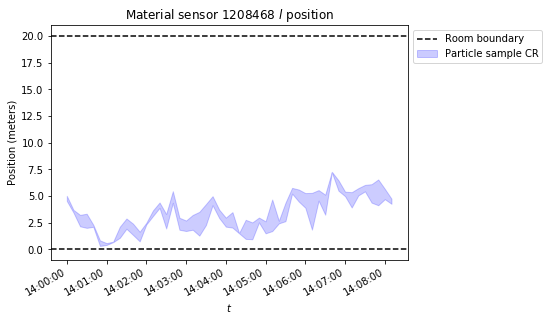

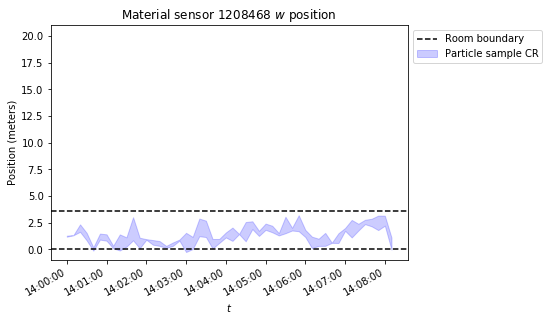

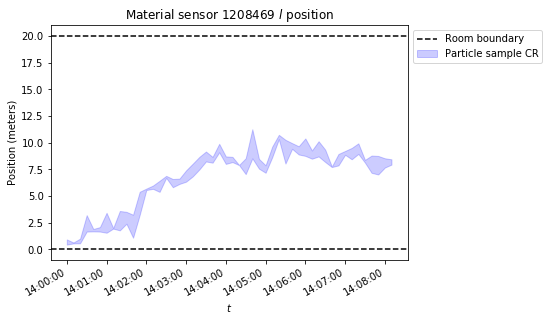

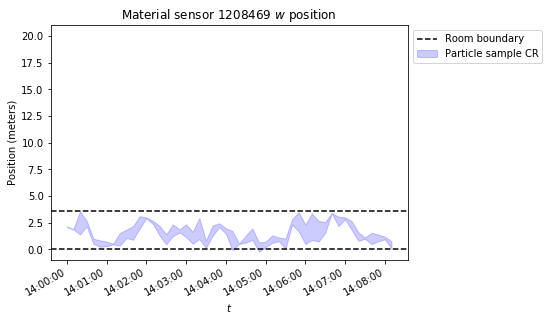

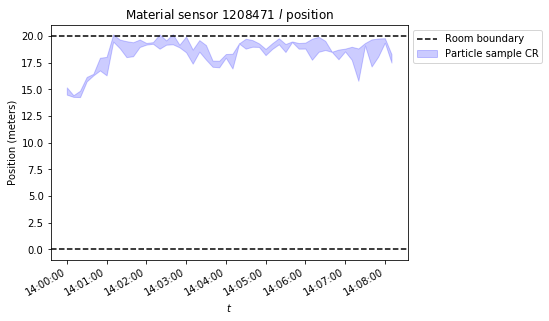

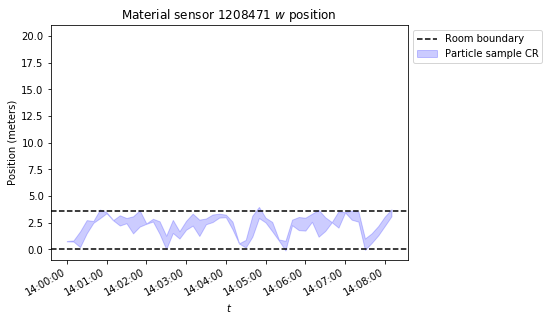

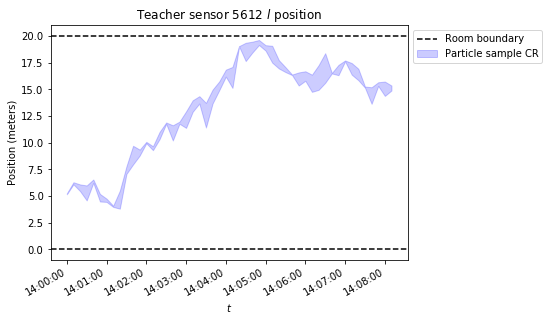

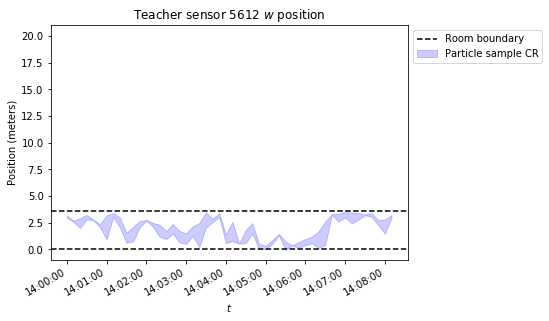

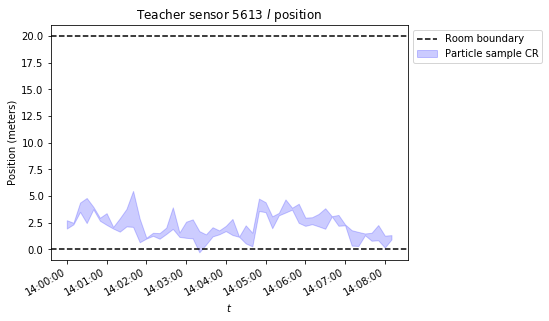

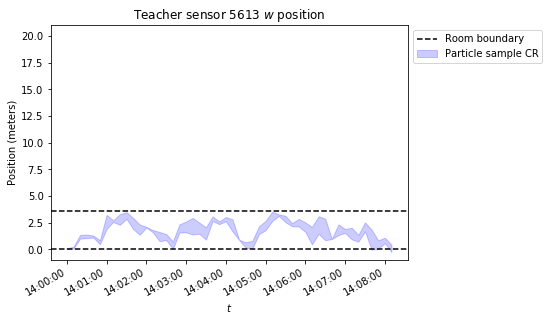

In [129]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.fill_between(
        t_test[:num_timesteps_test],
        x_continuous_mean_particle[:,x_var_index] - x_continuous_sd_particle[:, x_var_index],
        x_continuous_mean_particle[:,x_var_index] + x_continuous_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

### Simulation

Plot the positions of the sensors to make sure they have the properties we expect.

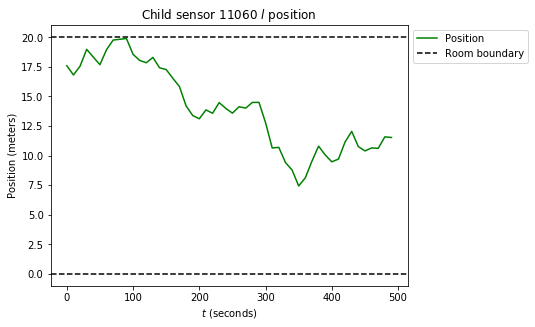

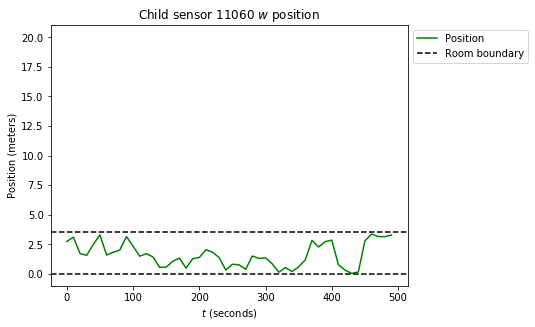

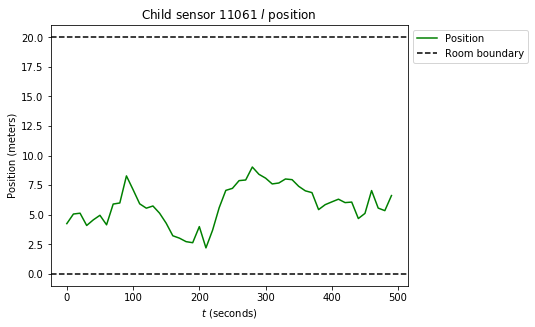

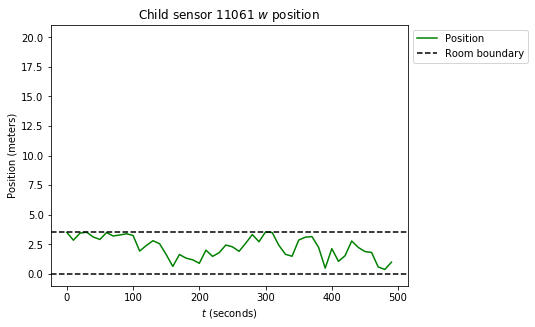

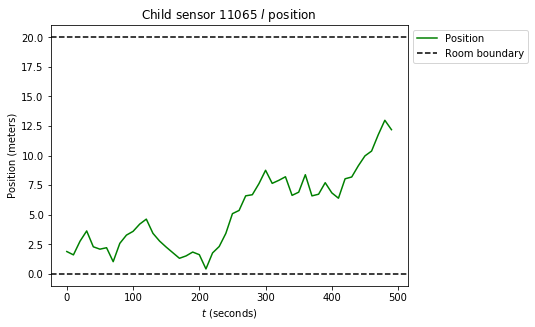

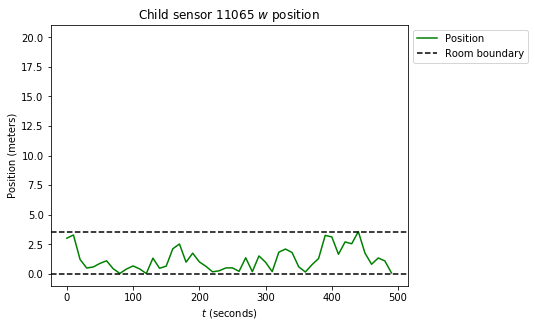

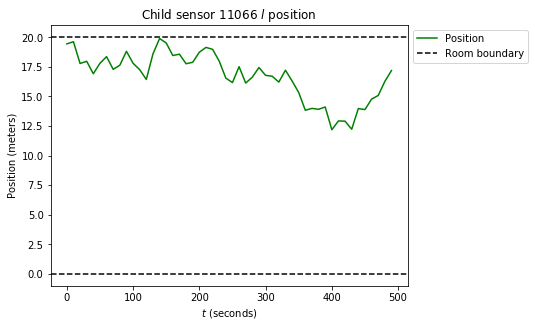

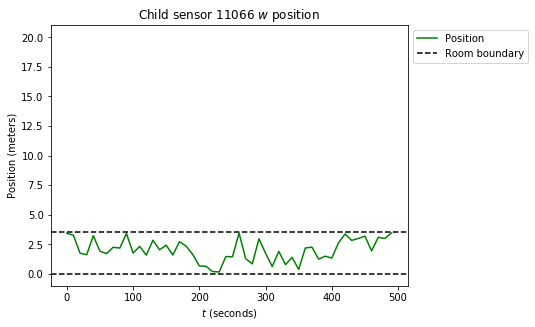

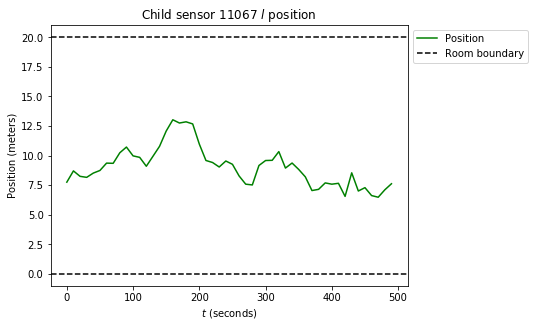

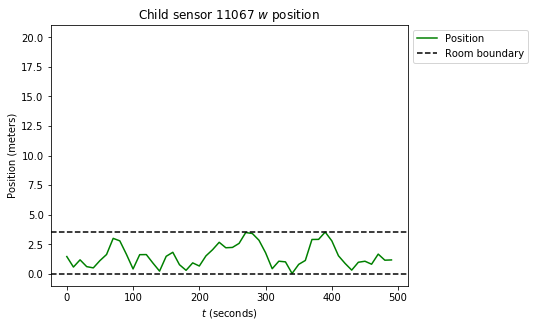

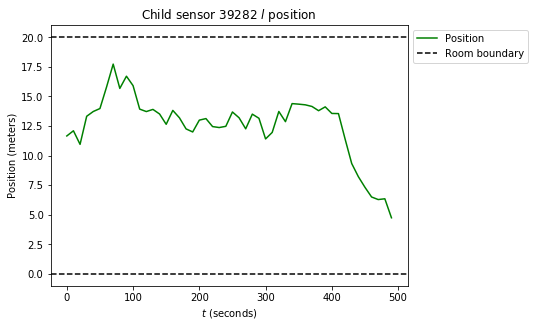

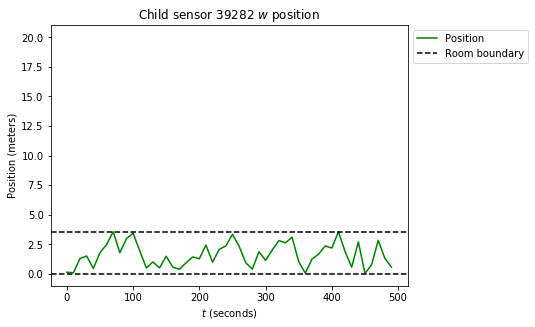

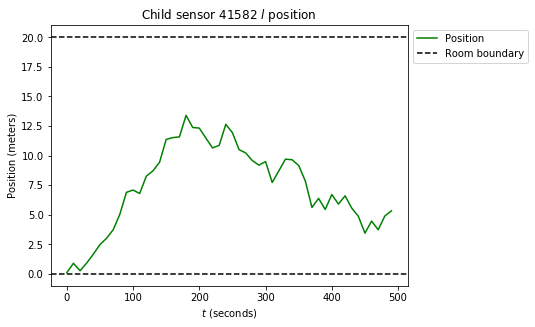

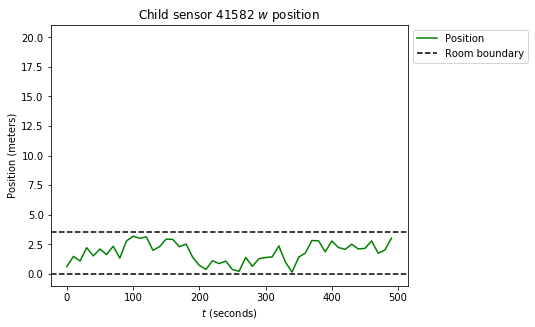

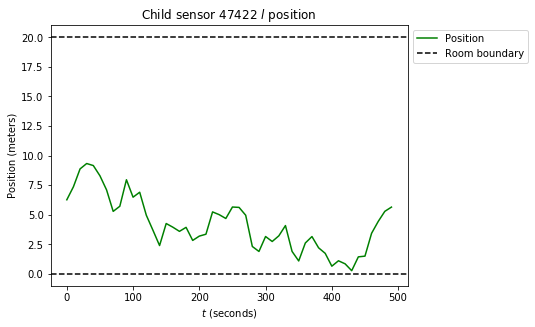

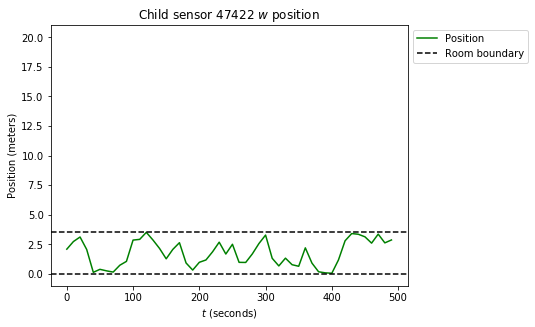

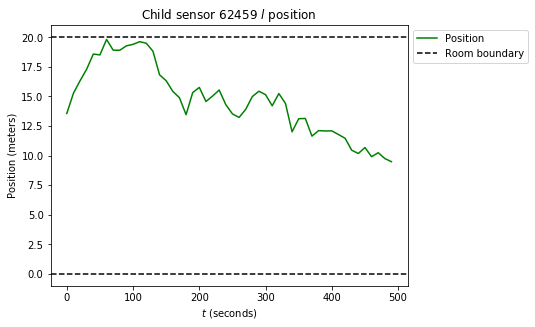

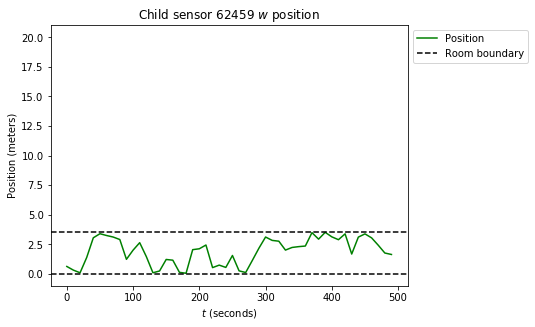

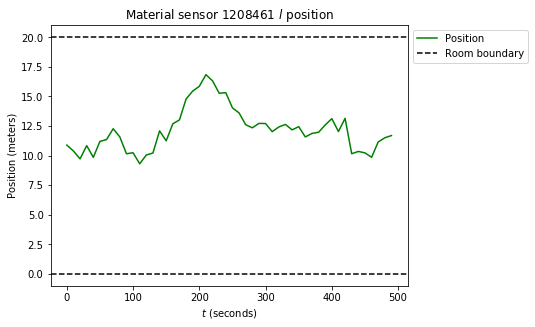

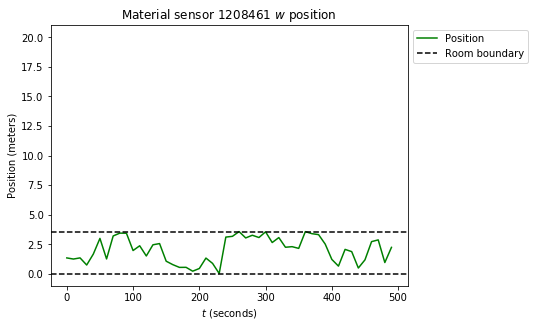

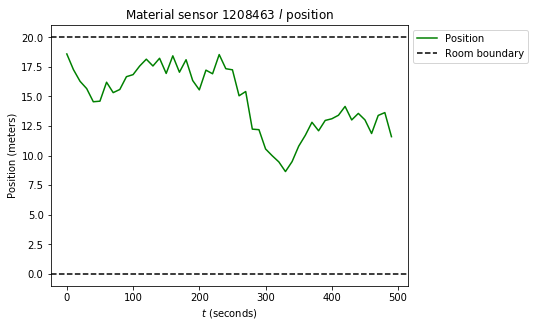

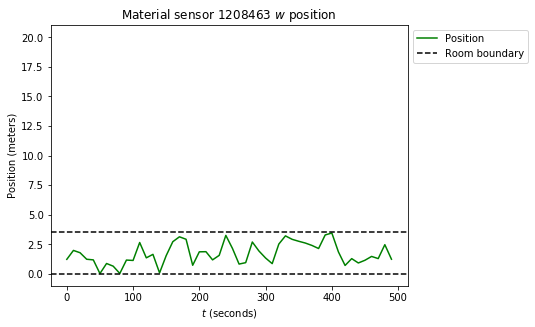

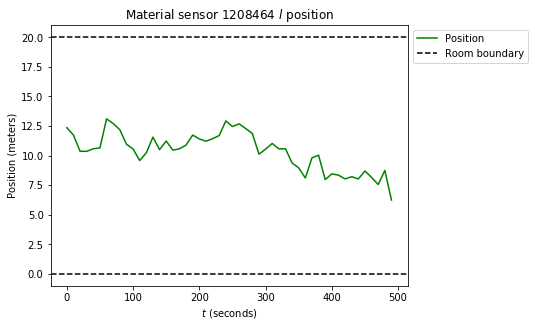

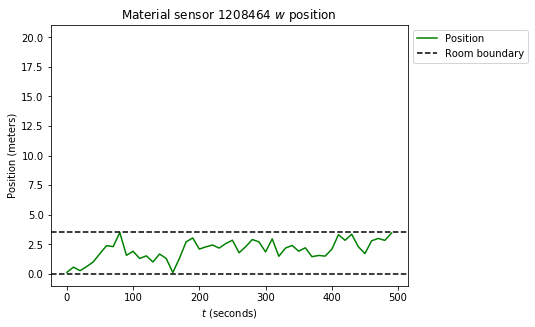

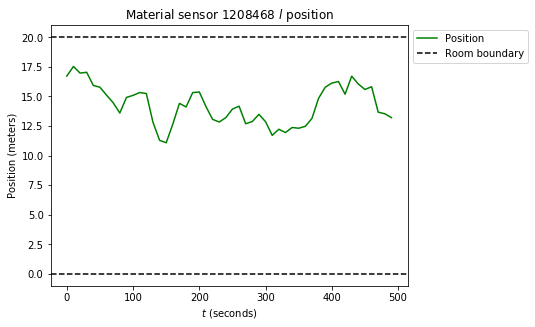

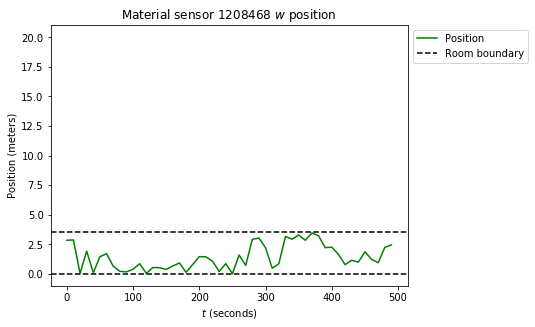

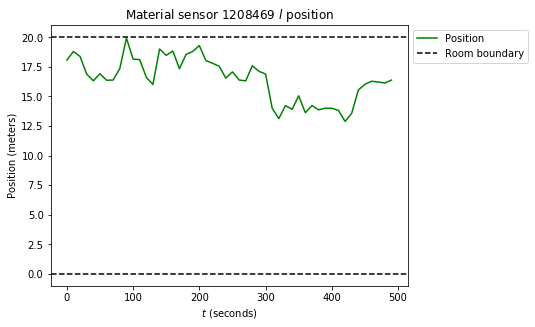

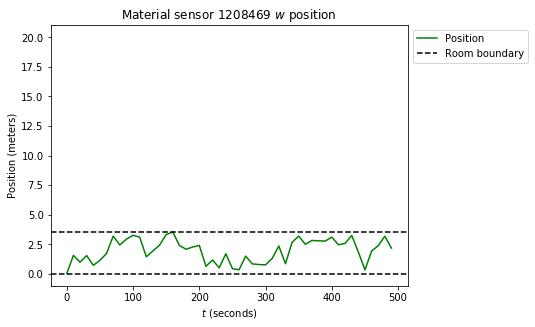

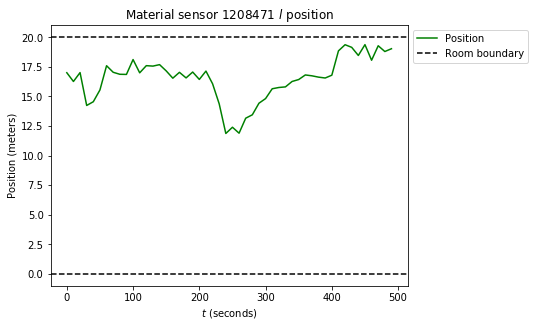

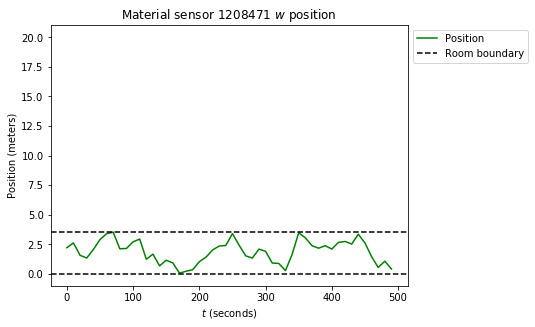

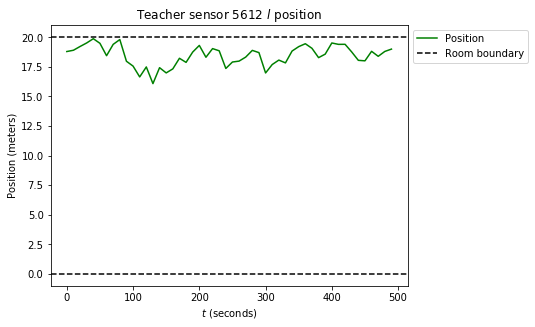

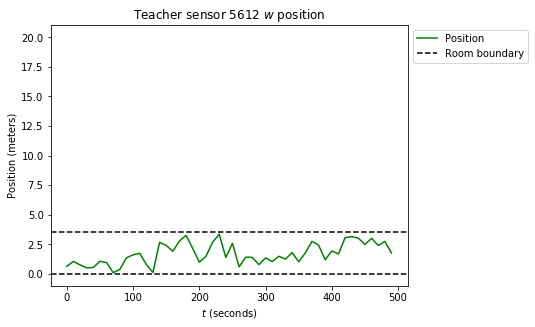

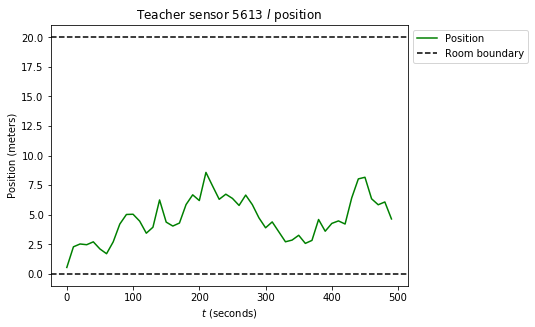

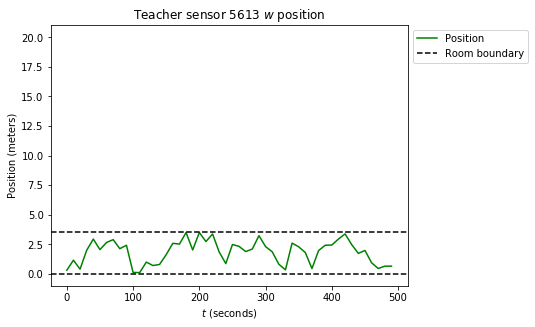

In [130]:
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:, x_var_index], 'g-', label='Position')
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.plot
    plt.xlabel('$t$ (seconds)')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For 10 randomly chosen pairs of sensors, plot the measured ping statuses against the distance between the sensors. We should see more missed pings for larger distances, but with a lot of noise.

In [131]:
distances_t_sim = sensor_model.distances(sensor_model.sensor_positions(x_continuous_t_sim))

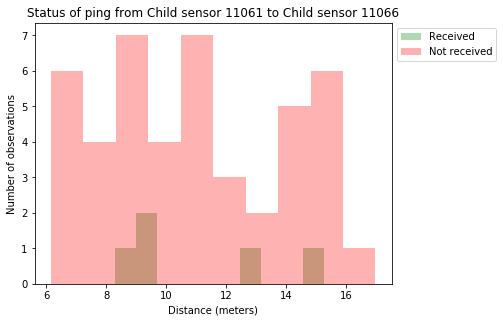

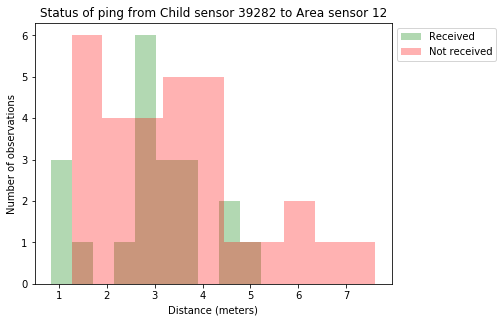

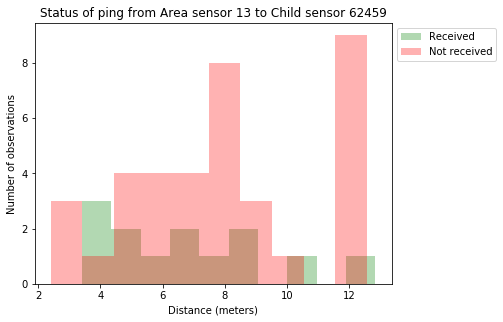

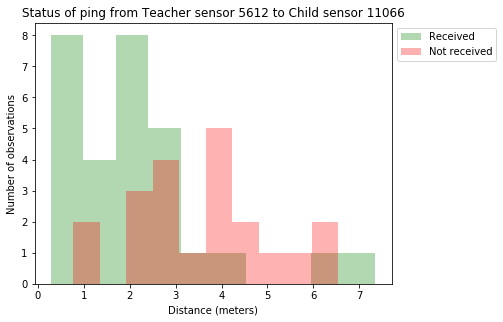

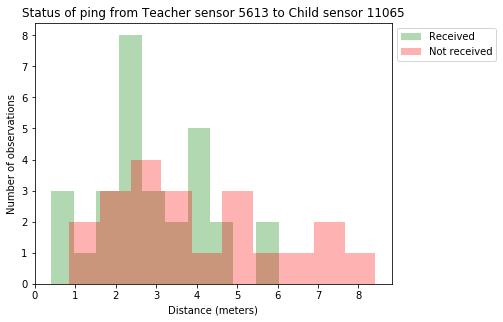

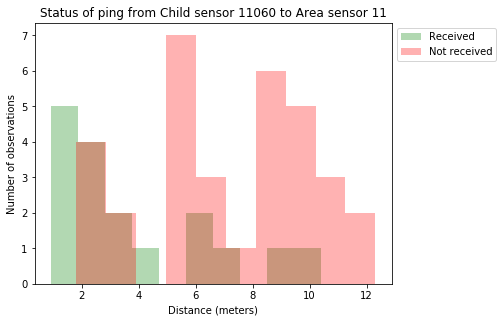

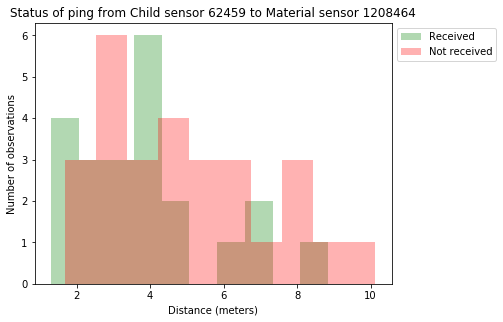

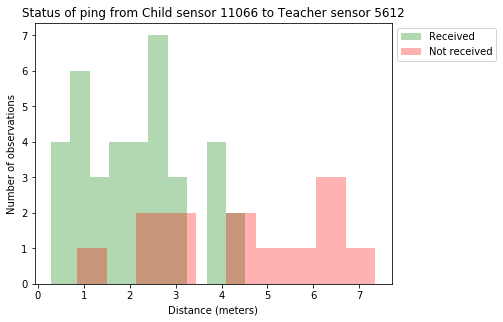

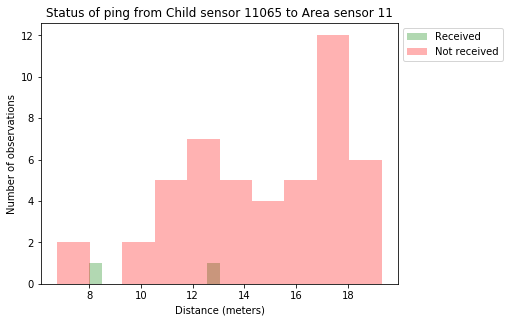

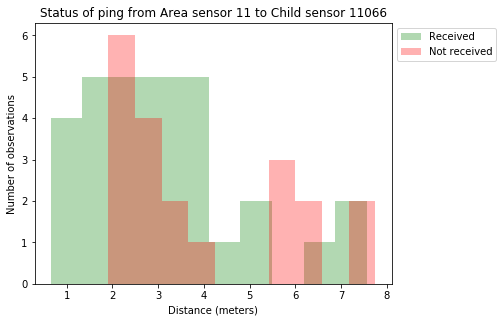

In [132]:
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    plt.hist(distances_t_sim[y_discrete_t_sim[:,y_discrete_var_index] == 0, y_discrete_var_index],
            color='green',
            alpha=0.3,
            label=ping_status_names[0])
    plt.hist(distances_t_sim[y_discrete_t_sim[:,y_discrete_var_index] == 1, y_discrete_var_index],
            color='red',
            alpha=0.3,
            label=ping_status_names[1])
    plt.title(y_discrete_names[y_discrete_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Number of observations')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For 10 randomly chosen pairs of sensors, plot the measured RSSI of the received pings versus the distance between the sensors. We should see a wide range of RSSI readings at each distance, but with a mean value that falls off with distance and a hard cut-off at -82 dB.

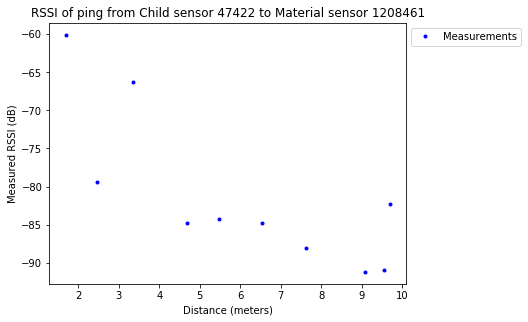

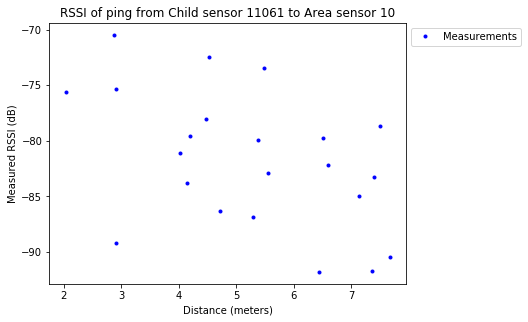

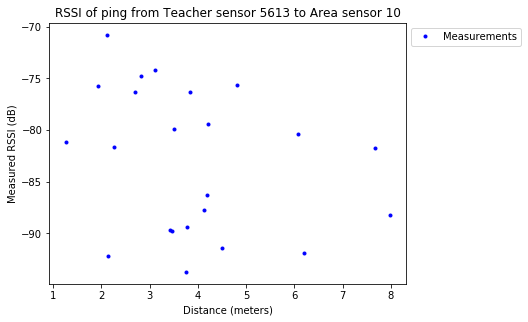

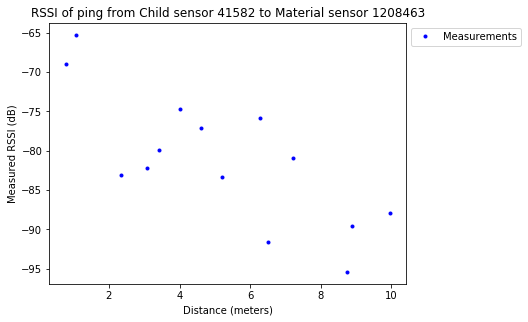

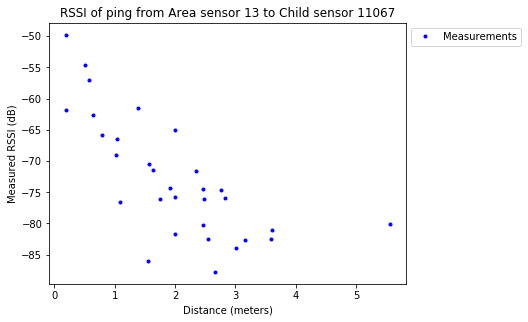

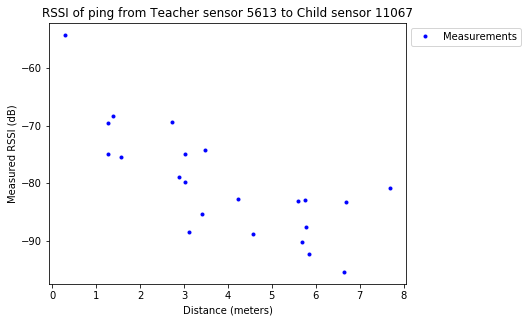

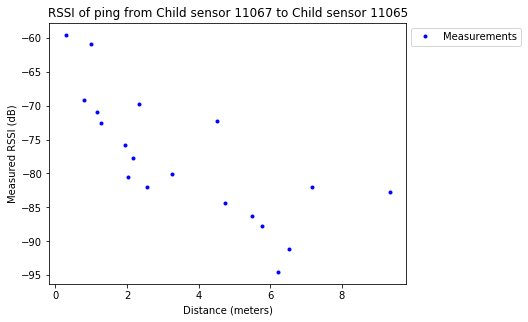

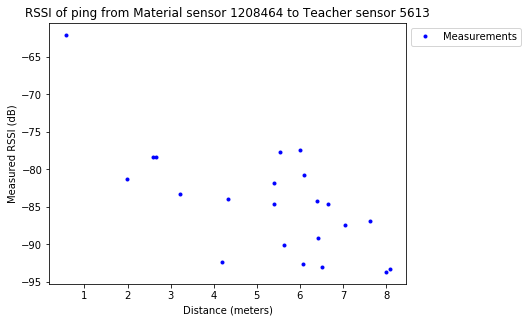

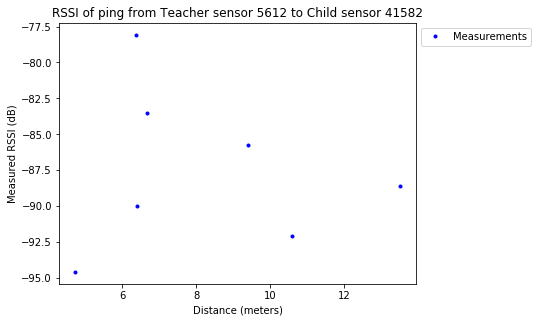

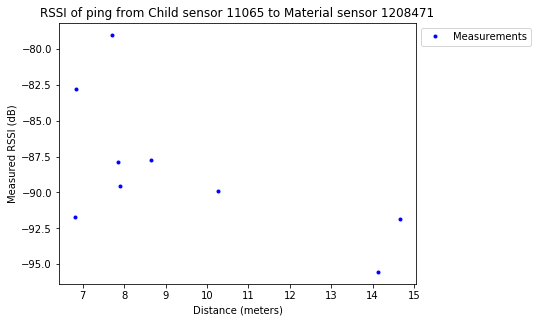

In [133]:
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    plt.plot(distances_t_sim[y_discrete_t_sim[:,y_continuous_var_index] == 0, y_continuous_var_index],
             y_continuous_t_sim[y_discrete_t_sim[:,y_continuous_var_index] == 0, y_continuous_var_index],
             'b.',
            label='Measurements')
    plt.title(y_continuous_names[y_continuous_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Measured RSSI (dB)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

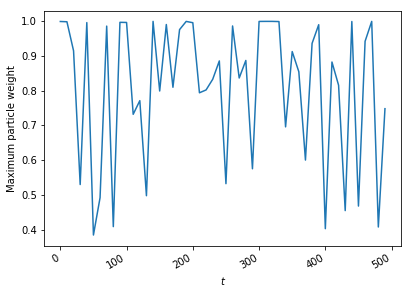

In [134]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim, max_weights_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Maximum particle weight')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

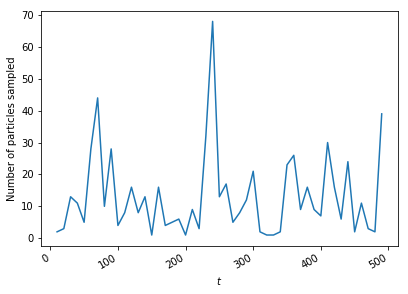

In [135]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim[1:], num_sampled_particles_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of particles sampled')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample means of the particles against the actual values of $\mathbf{X}_t$.

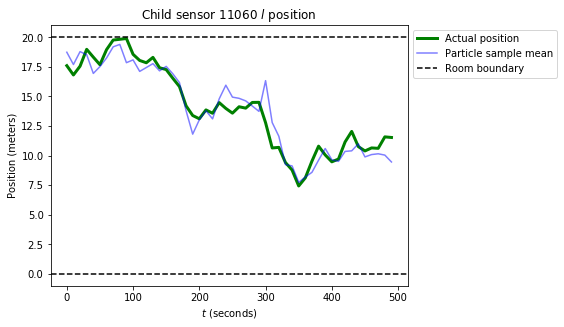

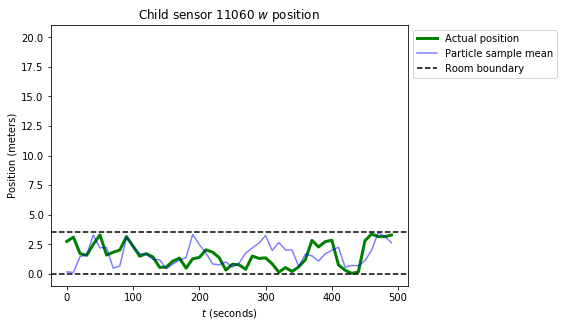

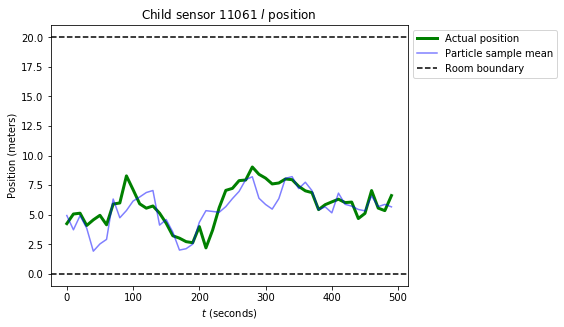

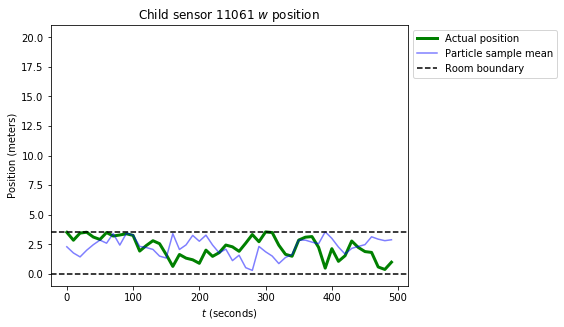

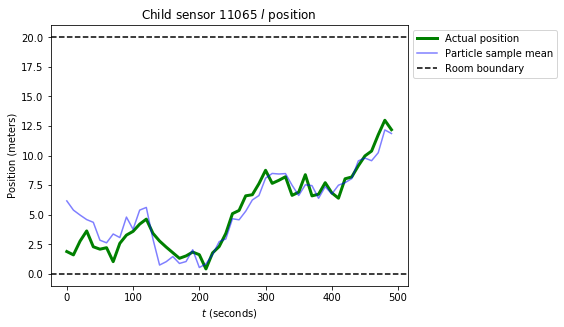

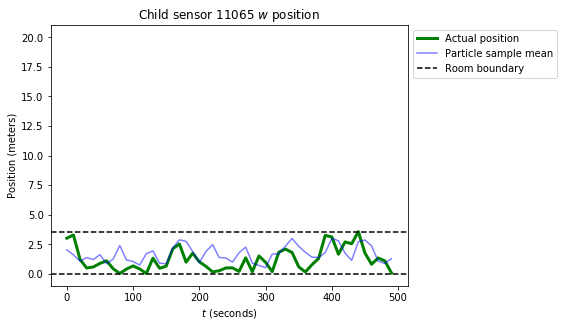

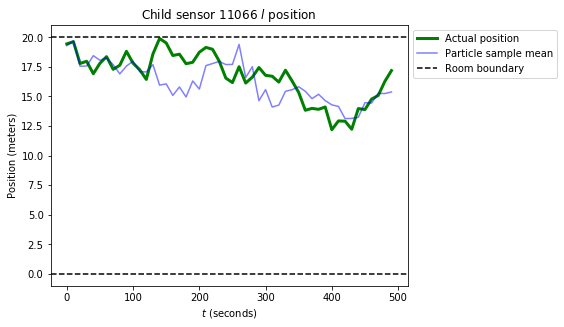

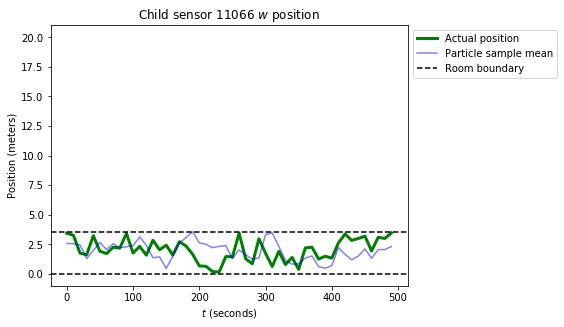

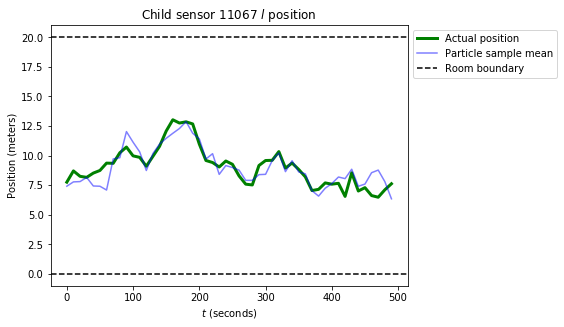

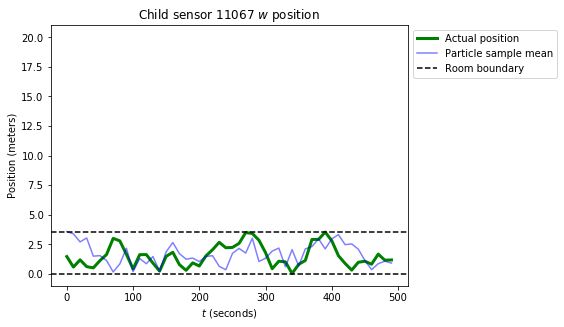

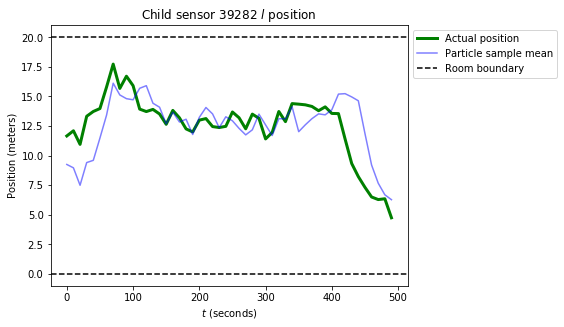

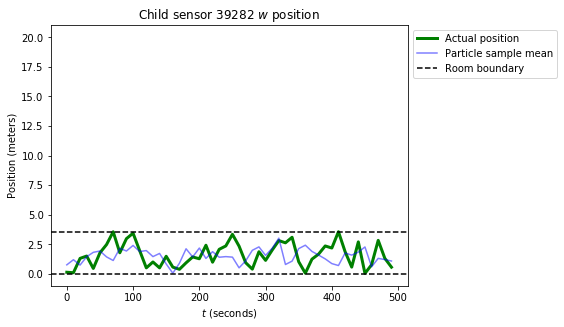

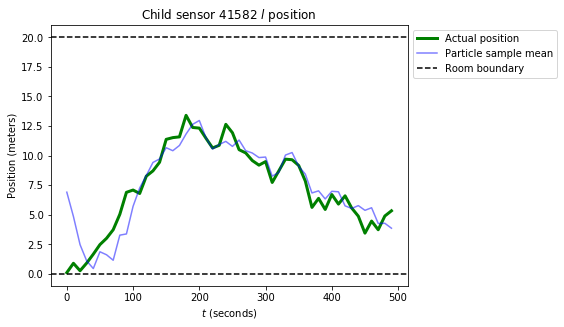

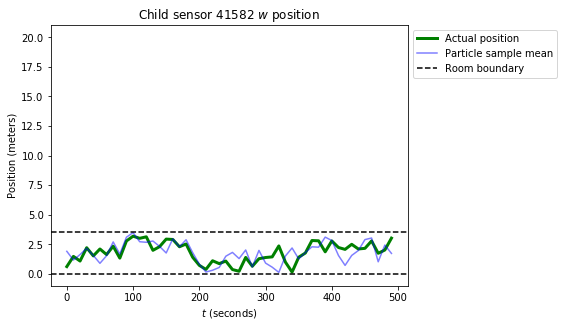

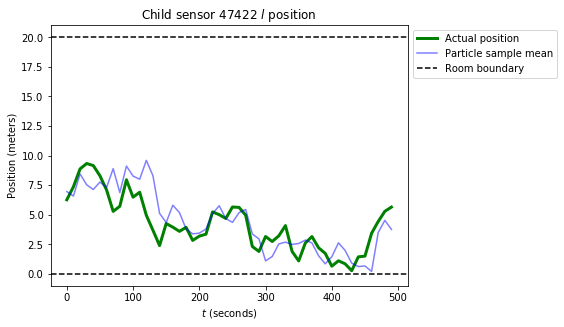

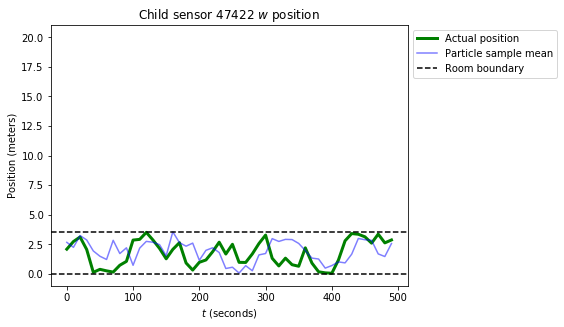

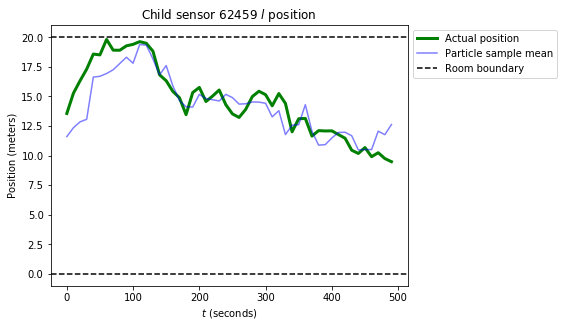

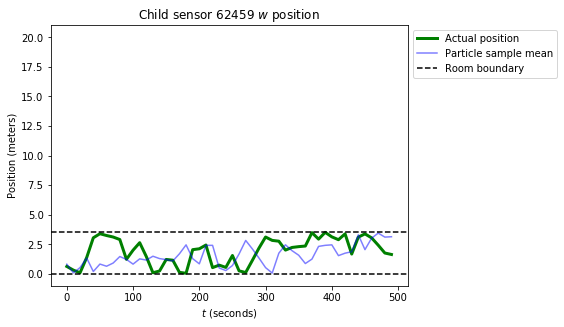

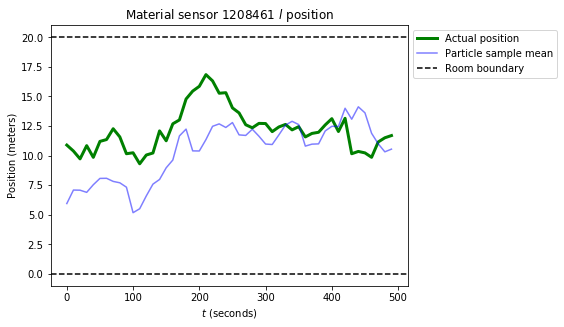

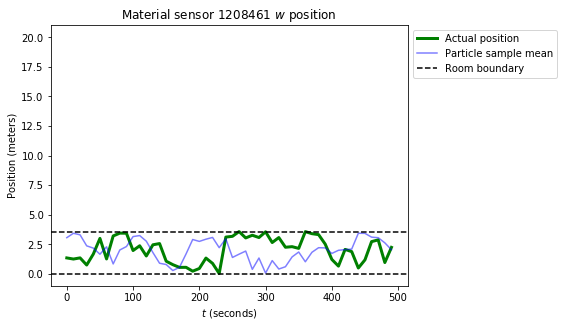

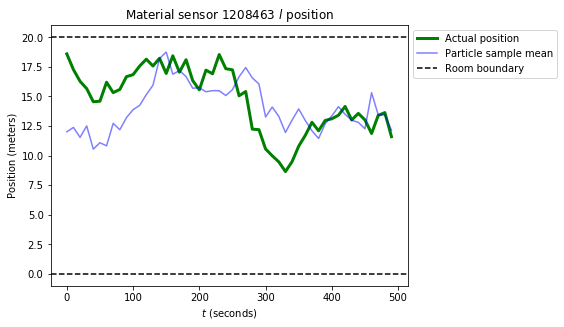

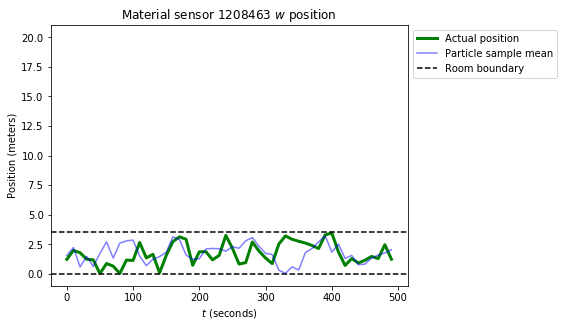

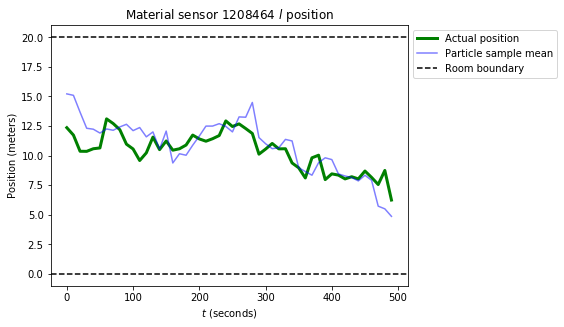

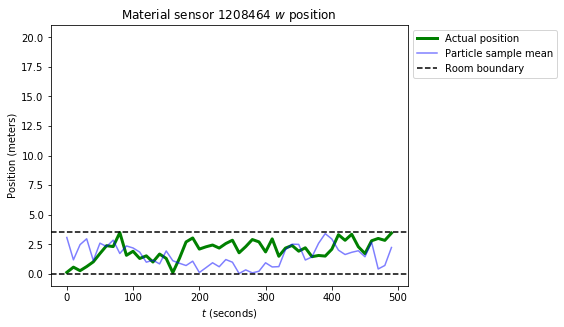

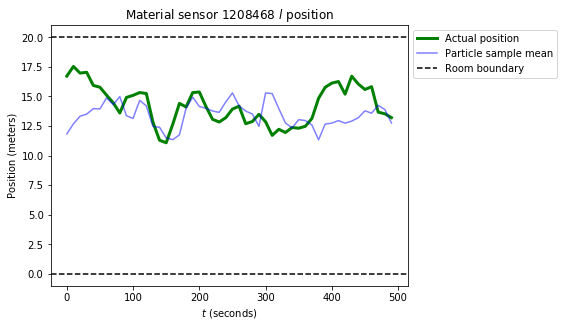

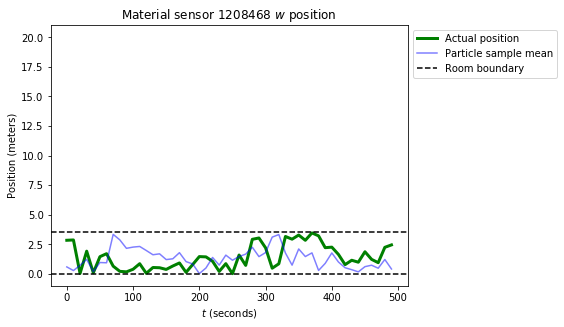

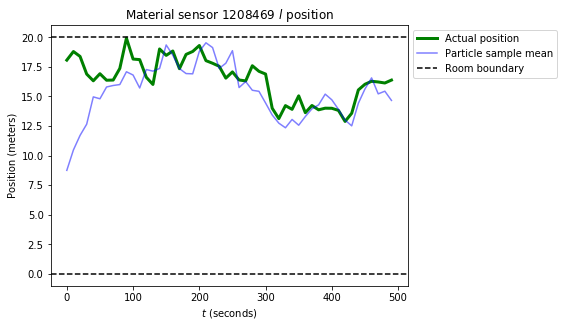

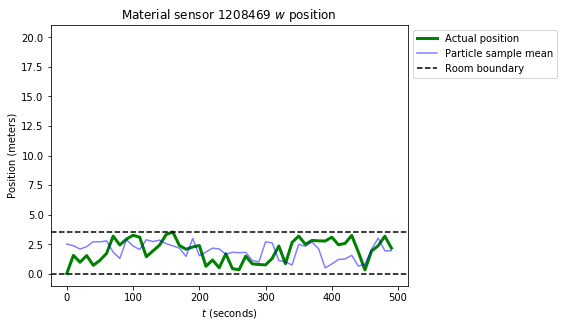

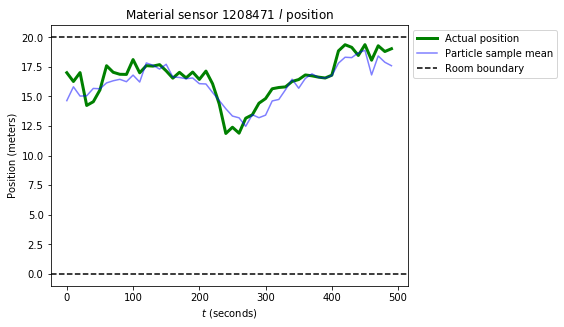

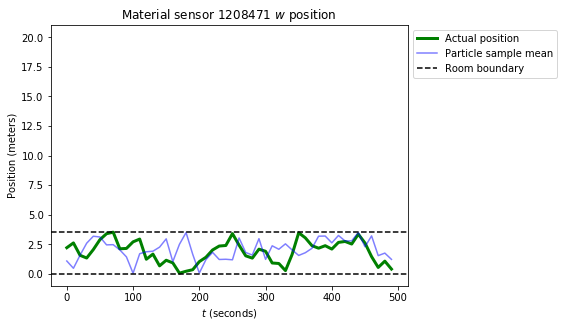

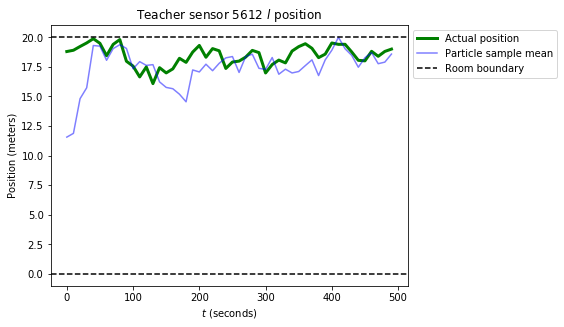

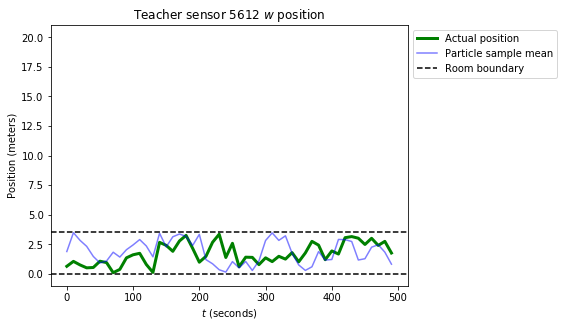

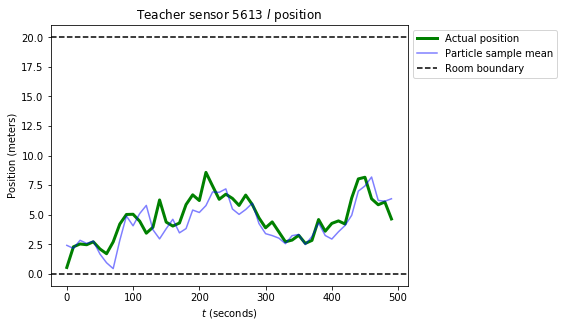

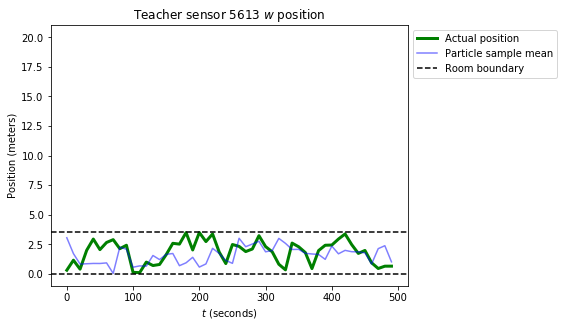

In [136]:
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.plot(t_sim, x_continuous_mean_particle_sim[:,x_var_index], 'b-', alpha=0.5, label='Particle sample mean')
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$ (seconds)')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Plot the sample confidence regions of the particles against the actual values of $\mathbf{X}_t$ (i.e., sample means plus/minus sample standard deviations)

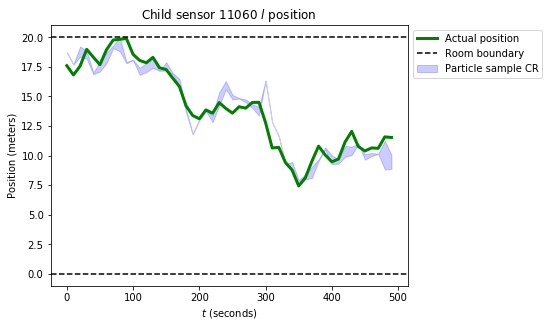

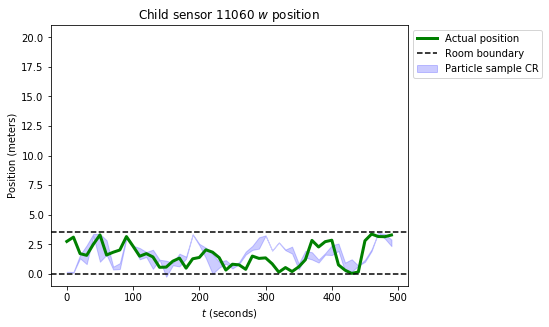

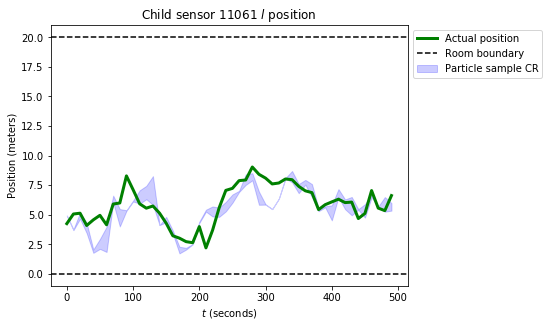

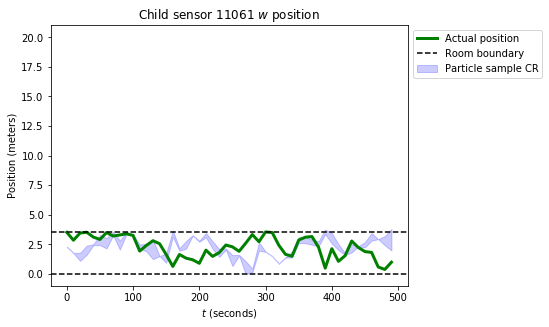

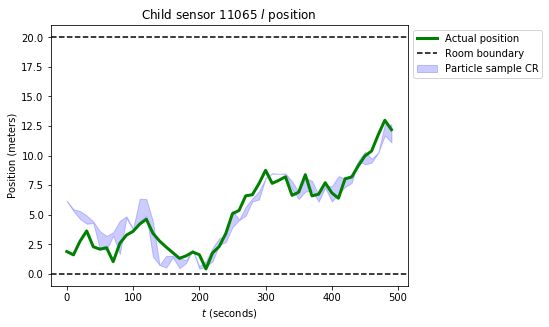

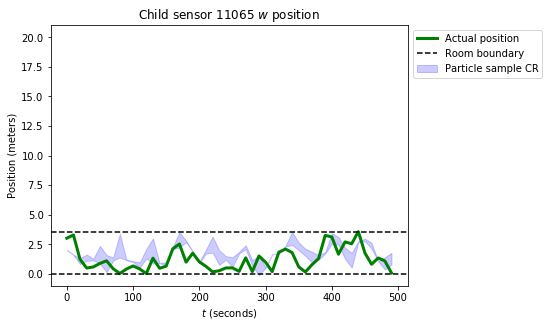

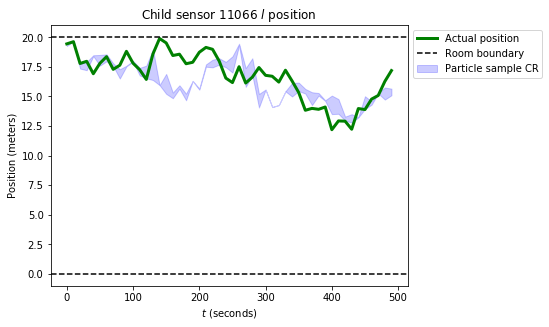

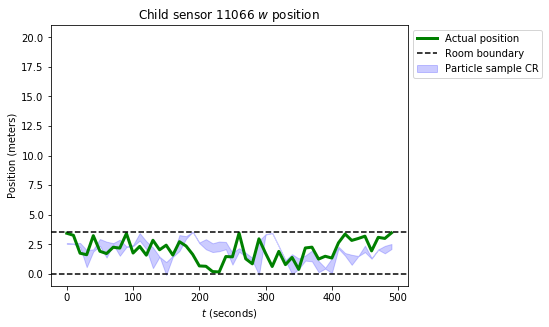

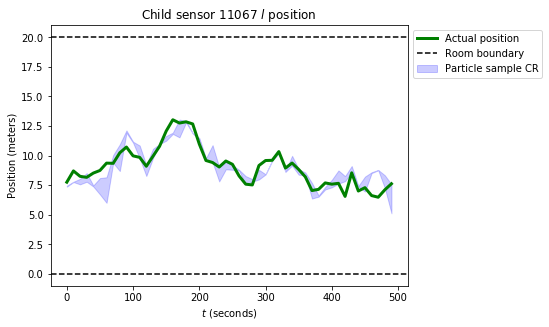

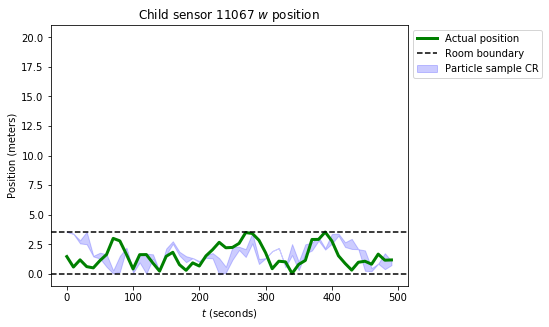

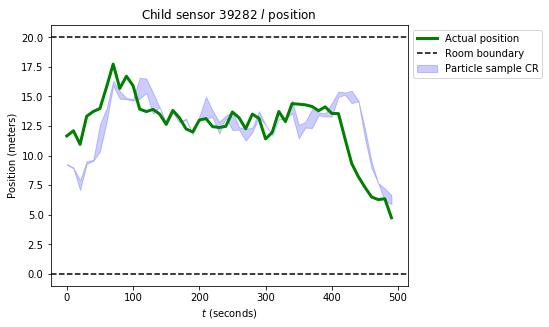

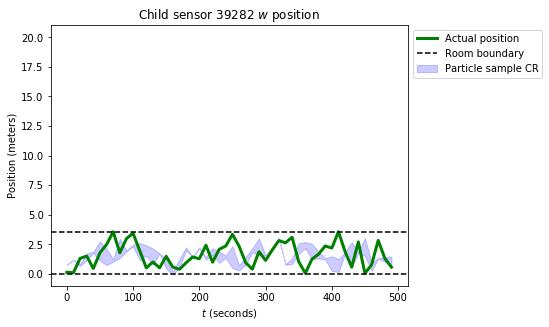

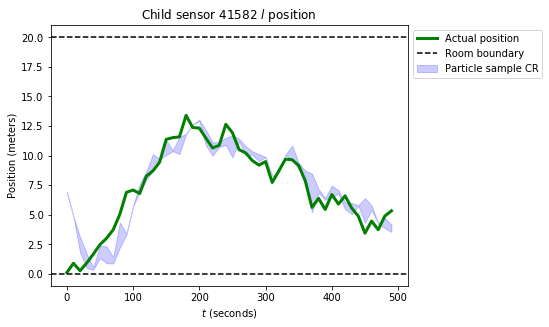

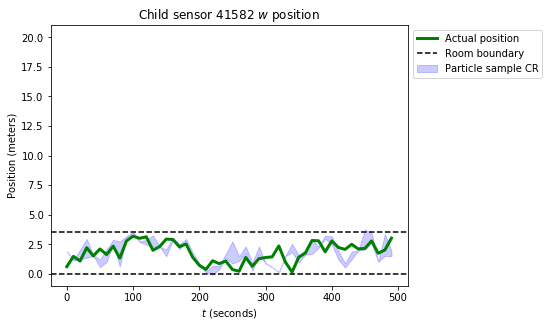

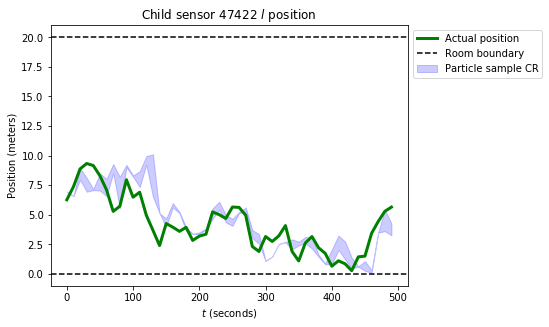

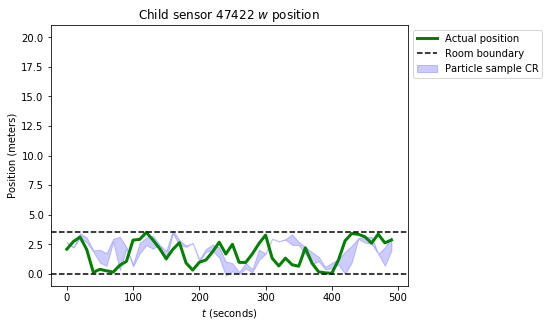

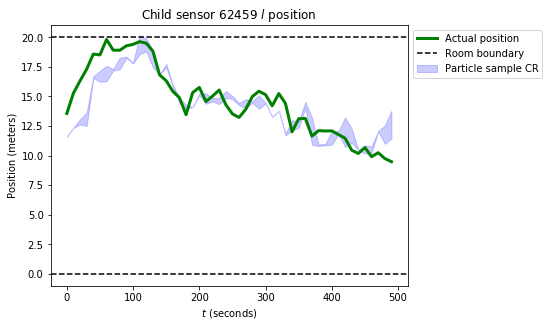

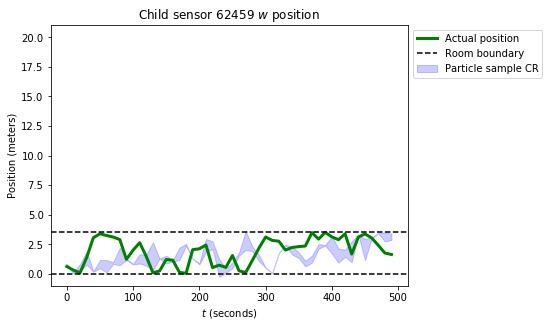

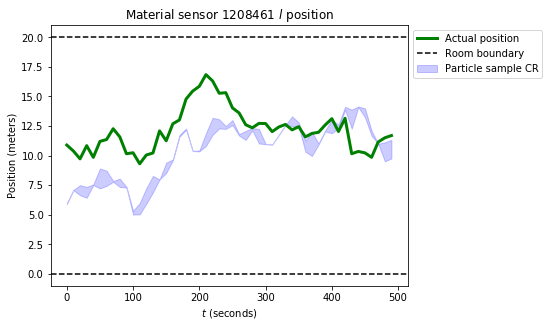

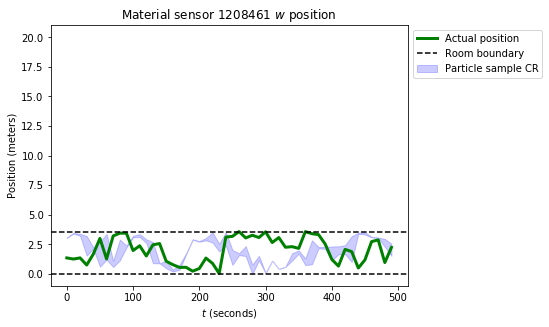

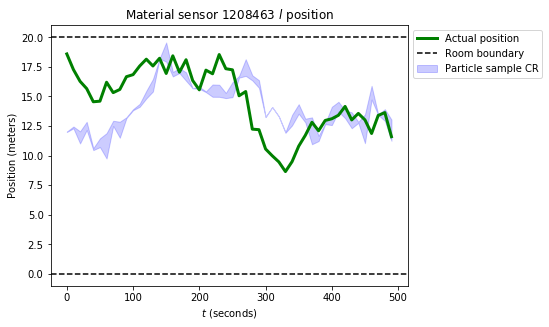

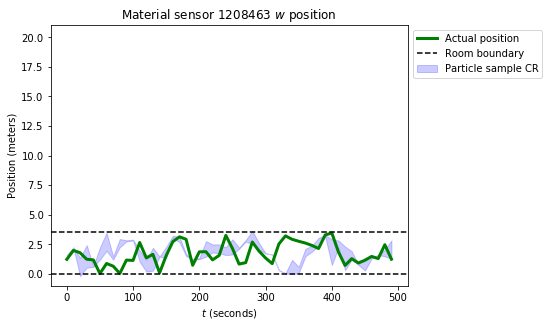

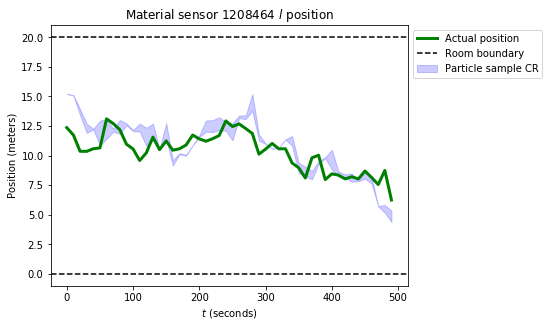

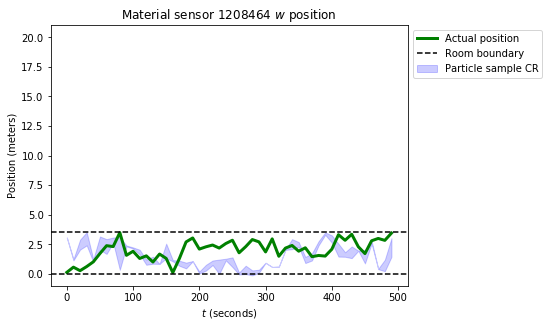

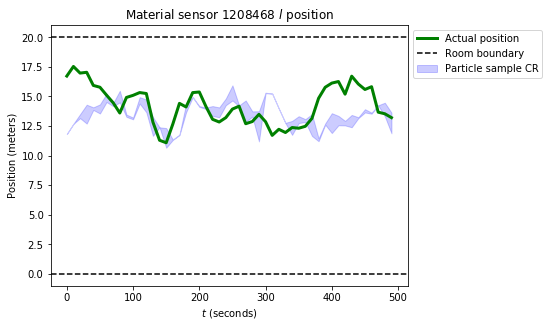

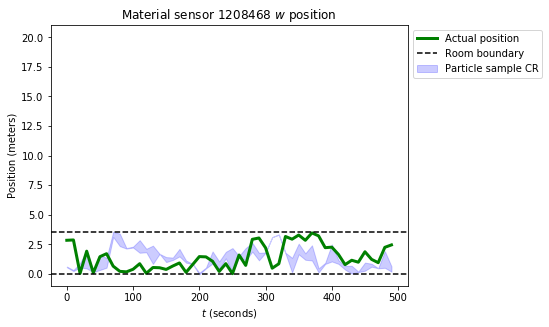

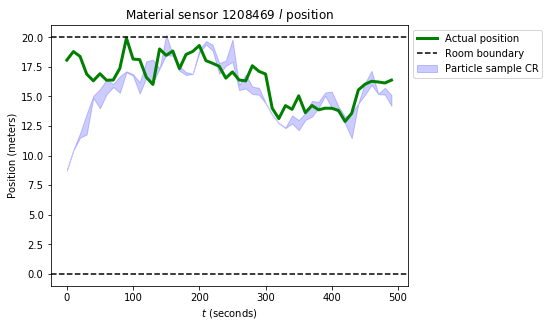

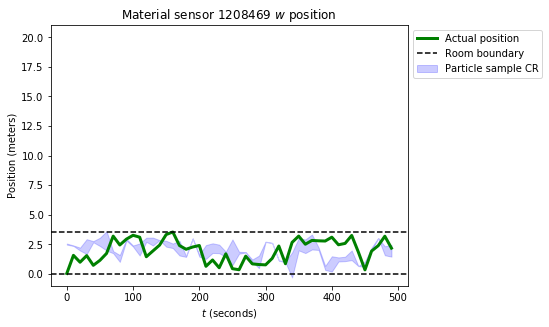

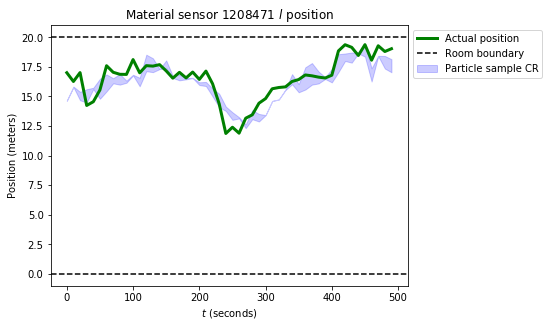

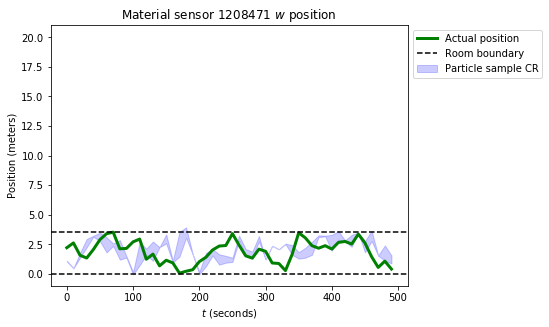

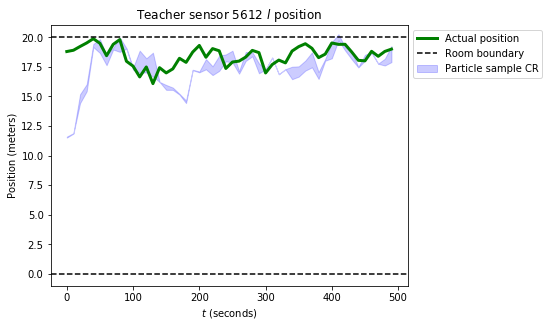

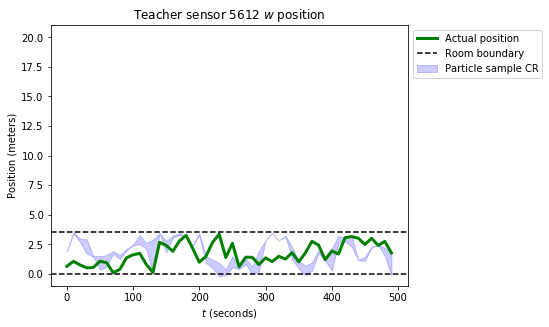

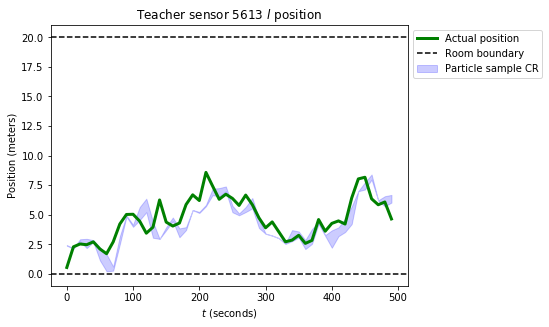

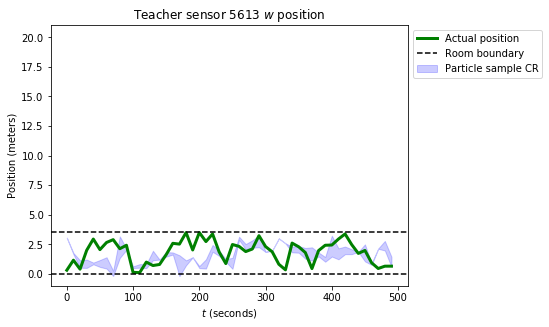

In [137]:
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.fill_between(
        t_sim,
        x_continuous_mean_particle_sim[:,x_var_index] - x_continuous_sd_particle_sim[:, x_var_index],
        x_continuous_mean_particle_sim[:,x_var_index] + x_continuous_sd_particle_sim[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$ (seconds)')
    plt.ylabel('Position (meters)')
    plt.title(x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()